##  view the infomation of fits file we use

In [3]:
from astropy.io import fits

vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac0.info()    # 查看fits文件信息

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageH

> ##  1. read data from the file    
> ##  2. calculate the metallicity using the formula from the paper   
> ##  3. use Marvin to calculate the mask   
> ##  4. plot the unmasked surface mass density   
> ##  5. plot the masked surface mass density   
> ## PS. only need to change the parameter of the plate_ifu and prop

In [1]:
######################################
### 读取fits，设置plate、ifu、prop ###
######################################

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join

# Marvin's fits.gz file Path
path_marvin_maps = '/root/bash_file/manga_maps_data'

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性

#plate and ifu ID of the galaxy
# such as 9883-3701
plate = 9876
ifu = 9101

#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
#SURFACE_MASS_DENSITY_VORONOI

In [2]:
# load data
binid = vac[5].data    # 76*76矩阵，定位各个数据的位置
basic = vac[1].data    # galaxy基本信息：
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 【定位数组】星系在2800长的数组中的位置
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

In [7]:
filename

'/root/bash_file/manga_maps_data/manga-9876-9101-MAPS-HYB10-GAU-MILESHC.fits.gz'

In [3]:
#######################
##### Marvin 开始 #####
#######################

# 导入Marvin的mask
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

# 获取数据
#new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据

#filename = '/root/bash_file/manga_maps_data/manga-8601-9101-MAPS-HYB10-GAU-MILESHC.fits.gz'
filename = join(path_marvin_maps, 'manga-{}-MAPS-HYB10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)

ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O


INFO: No release version set. Setting default to DR15


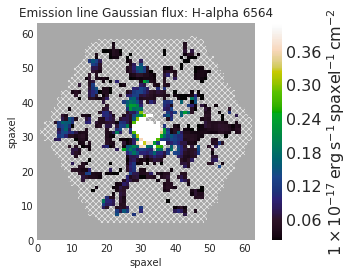

In [4]:
fig, ax = ha.plot()

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: invalid value encountered in true_divide
  return np.log10(np.e) * ivar**-0.5 / value


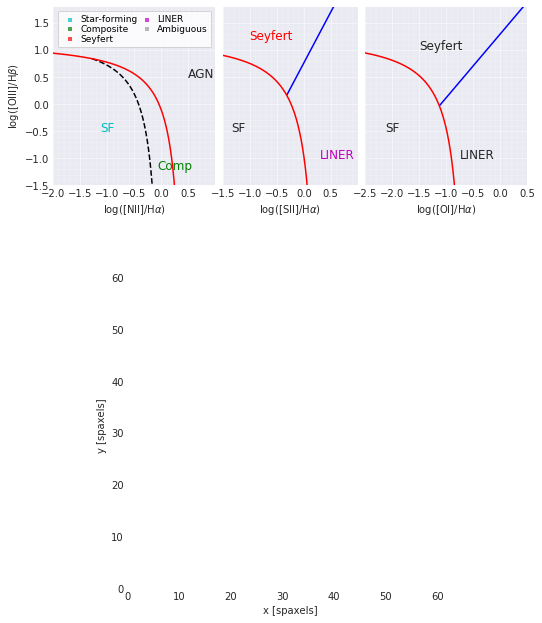

In [7]:
# 计算金属丰度
RR = (oii7+oii9) / nii    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93
# 计算mask
masks_bpt, __, __ = new_maps.get_bpt()    # 使用bpt图筛选star-forming区域
masks_bpt['sf']['global']
#RR.pixmask.schema    # 查看mask的种类列表
mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(oii7.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(oii9.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr
#######################
##### Marvin 结束 #####
#######################

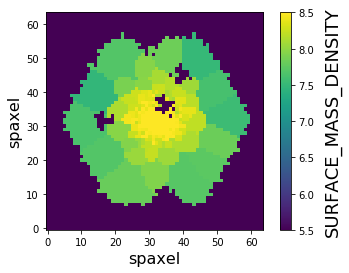

In [9]:
# 画图
image_sz = np.shape(new_mask)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

# 加mask
#masked_array = np.ma.array(maps,mask=new_mask)
masked_array = np.ma.array(maps,mask=0)

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围

In [43]:
bin1d[888]

-9999.0

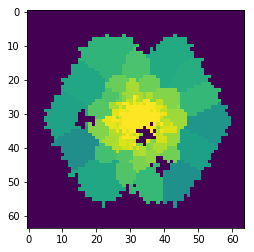

In [31]:
fig, ax = plt.subplots()
ax.imshow(maps,vmin=6.5,vmax=8.5)

In [32]:
maps.shape

(64, 64)

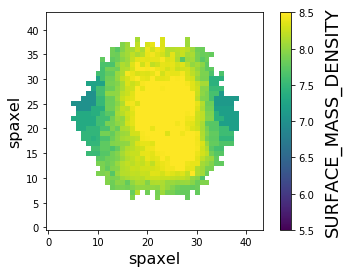

In [35]:
# 不加mask,只去除无效数据
masked_array = np.ma.array(maps,mask=(maps<-666))

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围

 - ###  做出一个星系的 metallicity and stellar surface mass density
 - ###  筛选星系
> - ###  做出筛选出的星系的所有的 metallicity and stellar surface mass density
 - ###  根据stellar mass 分组，分别作出 每一组的 metallicity 分布
> - ###  找出每个的peak，然后重叠在原图中，即可完全复原论文的图

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性

#plate and ifu ID of the galaxy
# such as 9883-3701
plate = 9883
ifu = 3701

# path of Marvin fits files
#path_marvin_data = '/root/bash_file/manga_maps_data'
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
#SURFACE_MASS_DENSITY_VORONOI

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value


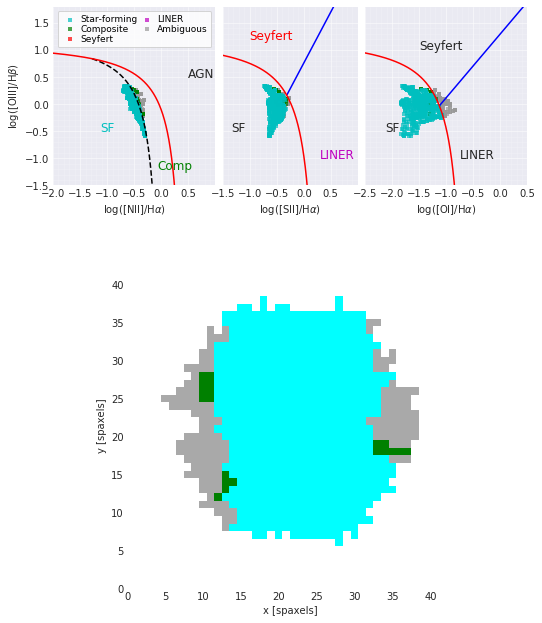

In [120]:
# 读取数据
binid = vac[5].data
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

# 导入Marvin的mask
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

# 获取数据
#new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
# 路径变量设置示例：mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O

# 计算金属丰度
RR = (oii7+oii9) / nii    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93
# 计算mask
masks_bpt, __, __ = new_maps.get_bpt()    # 使用bpt图筛选star-forming区域
#masks_bpt['sf']['global']
#RR.pixmask.schema    # 查看mask的种类列表
mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr

/root/anaconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


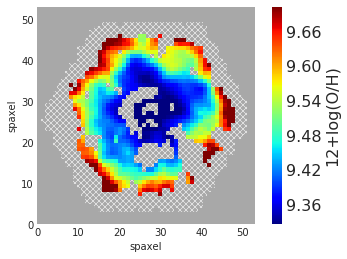

In [44]:
# 观测到的金属丰度
fig, ax = oh.plot(cmap='jet',mask=new_mask, cblabel='12+log(O/H)')

#fig, ax, cb=ha.plot(cmap='jet',cblabel='Flux( $10^{-17}$ erg s$^{-1}$) spaxel$^{-1}$ cm$^{-2}$',log_cb=True,cbrange=(0.0001,100),return_cb=True)
#cb.set_ticks([0.1, 1, 10, 100])
#cb.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$', '$10^{2}$'])

In [5]:
# 表面质量密度
image_sz = np.shape(new_mask)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

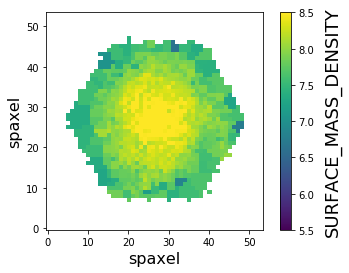

In [6]:
# 不加mask,只去除无效数据
masked_array = np.ma.array(maps,mask=(maps<-666))

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围

In [ ]:
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(lalala_x_y[:,0],lalala_x_y[:,1],bins=(10,10));
print(xbins)
print(ybins)
xbins[1]

In [ ]:
hist, xbins, ybins, cax = plt.hist

In [403]:
np.savetxt('/root/sel_galaxy.dat',sel_galaxy, fmt="%d")

In [407]:
la = np.loadtxt("/root/sel_galaxy.dat")
la.shape

(1632,)

In [ ]:
# Metallicity-surface mass density[number of spaxels]

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性


INFO: No release version set. Setting default to DR15


/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: invalid value encountered in true_divide
  return np.log10(np.e) * ivar**-0.5 / value


[6, 11.099101, 9.622461318969727, 12.099101066589355]

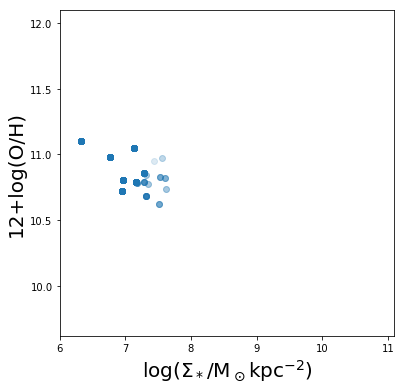

In [2]:

#plate and ifu ID of the galaxy
# such as 9883-3701
plate = 8252
ifu = 12701

# path of Marvin fits files
#path_marvin_data = '/root/bash_file/manga_maps_data'
path_marvin_data = '/root/bash_file/marvin_vor10_fits'
#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
#SURFACE_MASS_DENSITY_VORONOI
# 读取数据
binid = vac[5].data
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

# 使用Marvin
# 获取数据
#new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
# 路径变量设置示例：mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O



# 计算金属丰度
RR = (oii7+oii9) / nii;    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93;

# 利用Marvin计算mask
masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr


# 表面质量密度
image_sz = np.shape(new_mask)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

oh = oh[0:image_sz,0:image_sz]    # 调整oh金属丰度矩阵与标准mask维度一致
# x轴为maps，即 surface mass density
# y轴为oh, 即 metallicity
temp_maps = maps[new_mask == 0]
temp_oh = oh.value[new_mask == 0]
maps_min = np.min(temp_maps)    # x轴最小值
maps_max = np.max(temp_maps)    # x轴最大值
oh_min = np.min(temp_oh)    # y轴最小值
oh_max = np.max(temp_oh)    # y轴最大值

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(temp_maps, temp_oh, alpha=0.15)
ax.set_xlabel('log($\Sigma_*$/M$_\odot$kpc$^{-2}$)',fontsize=20)
ax.set_ylabel('12+log(O/H)',fontsize=20)
ax.axis([6, oh_max, oh_min-1, oh_max+1])



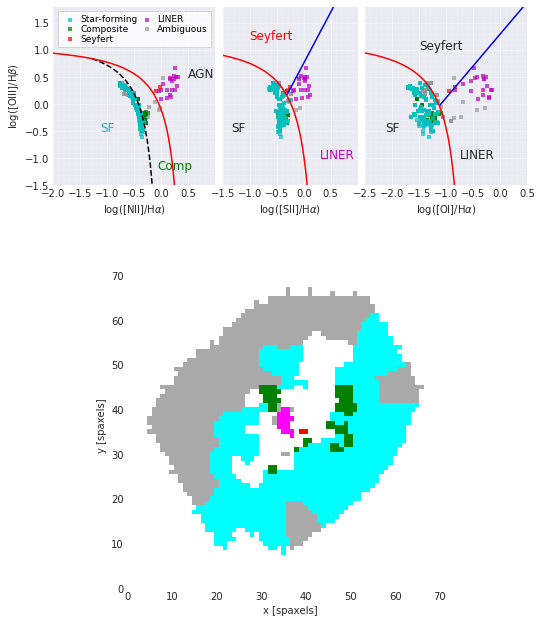

the shape of metal_all =   (1755,)
the shape of densi_all =   (2801,)


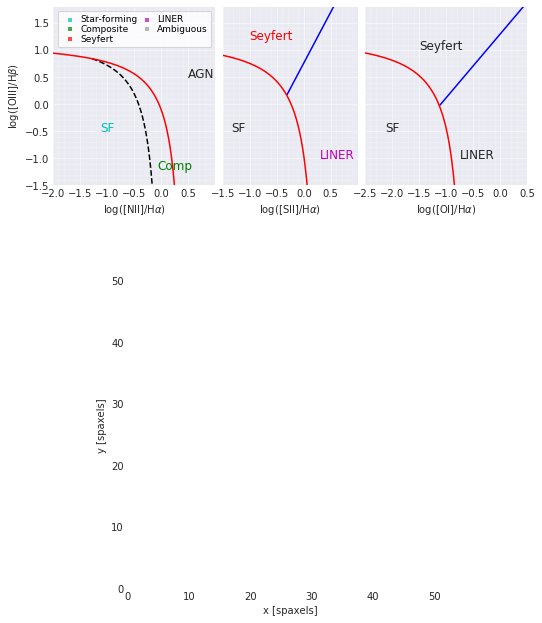

the shape of metal_all =   (1755,)
the shape of densi_all =   (1755,)


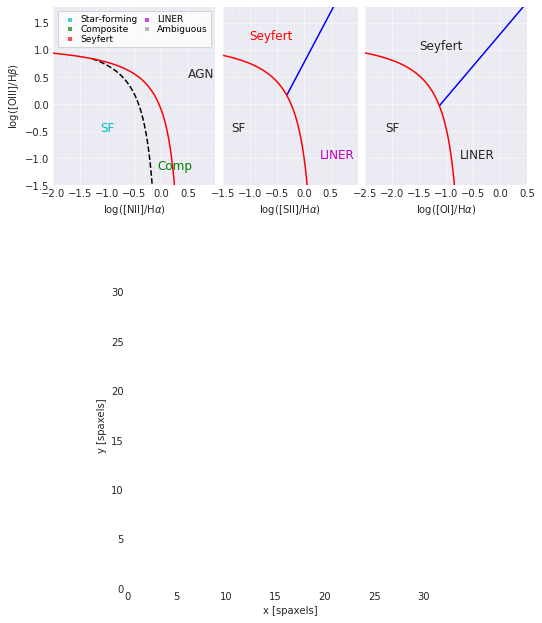

the shape of metal_all =   (1755,)
the shape of densi_all =   (1755,)


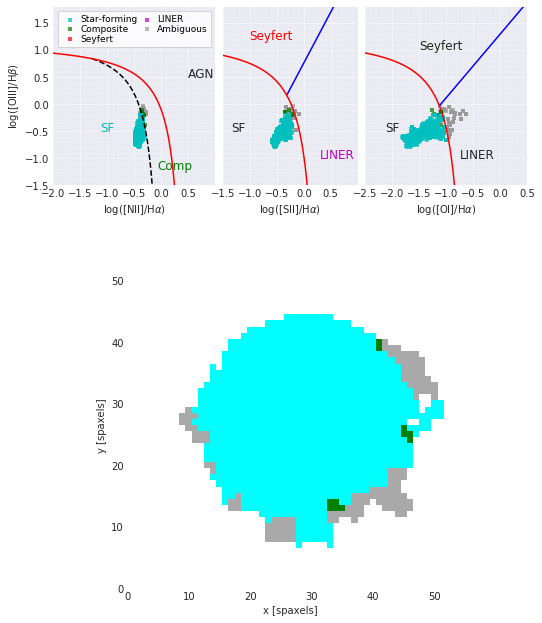

the shape of metal_all =   (2703,)
the shape of densi_all =   (3651,)


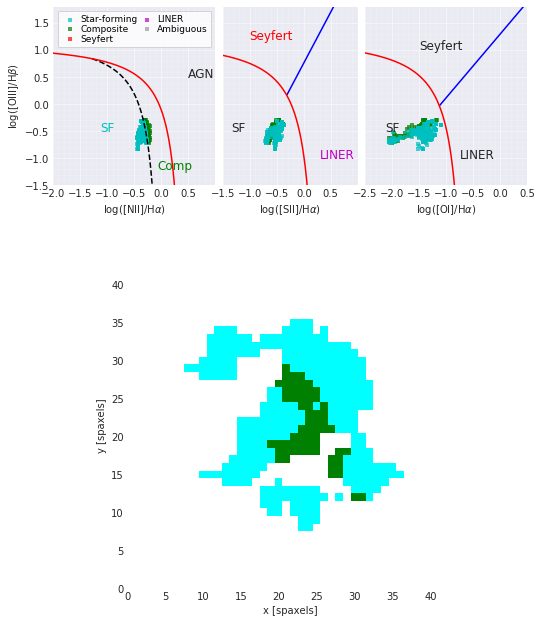

the shape of metal_all =   (2997,)
the shape of densi_all =   (3291,)


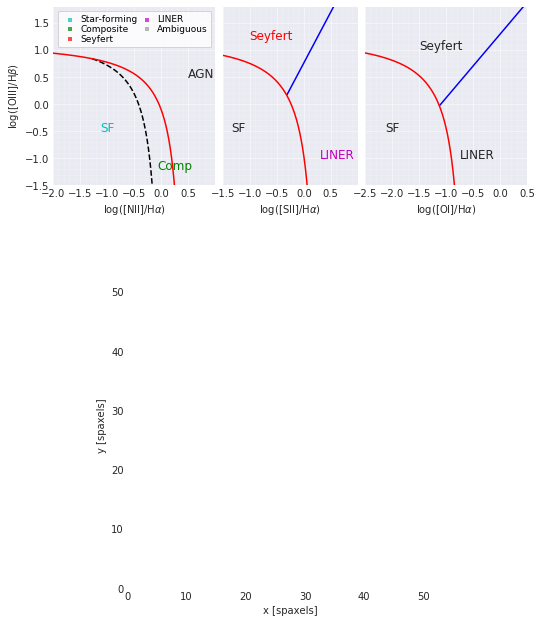

the shape of metal_all =   (2997,)
the shape of densi_all =   (2997,)


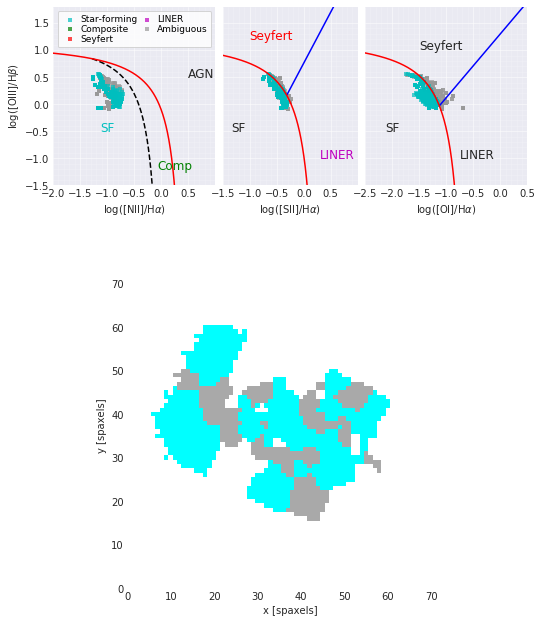

the shape of metal_all =   (3819,)
the shape of densi_all =   (4641,)


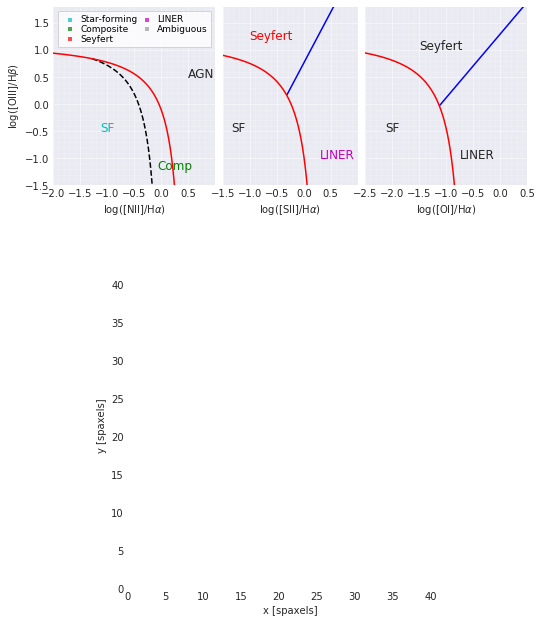

the shape of metal_all =   (3819,)
the shape of densi_all =   (3819,)


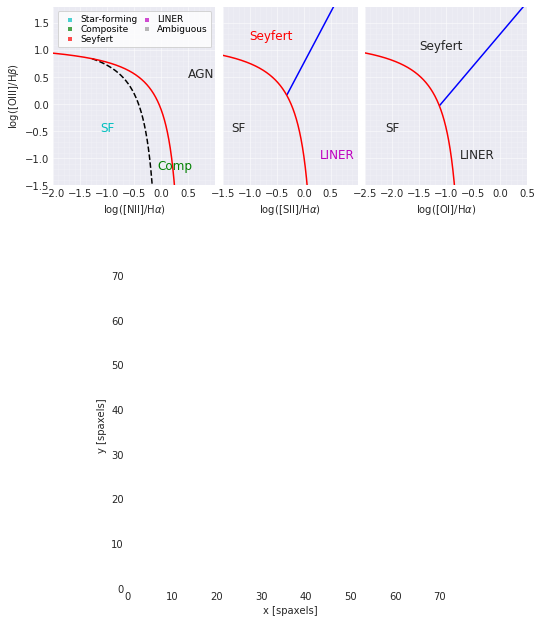

the shape of metal_all =   (3819,)
the shape of densi_all =   (3819,)


In [9]:
# 读取每个星系的metallicity和mass density
# 将所有的spaxels汇总
# 留意：若是某星系的BPT图为空，那么会出现空数组，会报错
# 因此需要使用判断语句，查看是否为空数组
# 若为空，则continue
# 若不为空，则继续

import warnings

warnings.filterwarnings('ignore')

binid = vac[5].data
basic = vac[1].data

use_galaxy = np.loadtxt("/root/sel_galaxy.dat")

total_galaxy = use_galaxy.size
pla_ifu = np.zeros([total_galaxy,2])
pla_ifu[:,0] = basic['plate'][use_galaxy]
pla_ifu[:,1] = basic['ifudsgn'][use_galaxy]


# 赋初值，仅需要第一次循环    
for i in range(0,1):
    #plate and ifu ID of the galaxy
    # such as 9883-3701
    
    plate = int(pla_ifu[i,0])
    ifu = int(pla_ifu[i,1])

    #plate and ifu ID of the galaxy
    # such as 9883-3701
    #plate = 8252
    #ifu = 12701

    # path of Marvin fits files
    #path_marvin_data = '/root/bash_file/manga_maps_data'
    path_marvin_data = '/root/bash_file/marvin_vor10_fits'
    #choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
    prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
    #SURFACE_MASS_DENSITY_VORONOI
    # 读取数据
    
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
    mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
    bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
    redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

    # 使用Marvin
    # 获取数据
    #new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
    # 路径变量设置示例：mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii
    oii7 = new_maps.emline_gflux_oii_3727    # 获取O
    oii9 = new_maps.emline_gflux_oii_3729    # 获取O



    # 计算金属丰度
    RR = (oii7+oii9) / nii;    # Oii/Nii
    # 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
    logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
    oh =  logRR + 8.93;

    # 利用Marvin计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
    new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr


    # 表面质量密度
    image_sz = np.shape(new_mask)[0]    # 图像边长
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                maps[i,j] = mass[idbin]

    oh = oh[0:image_sz,0:image_sz]    # 调整oh金属丰度矩阵与标准mask维度一致
    # x轴为maps，即 surface mass density
    # y轴为oh, 即 metallicity
    temp_maps = maps[new_mask == 0]
    temp_oh = oh.value[new_mask == 0]
    metal_all = temp_oh
    densi_all = temp_maps
    
    
# 正式开始循环
for i in range(1,10):
    #plate and ifu ID of the galaxy
    # such as 9883-3701
    
    plate = int(pla_ifu[i,0])
    ifu = int(pla_ifu[i,1])

    #plate and ifu ID of the galaxy
    # such as 9883-3701
    #plate = 8252
    #ifu = 12701

    # path of Marvin fits files
    #path_marvin_data = '/root/bash_file/manga_maps_data'
    path_marvin_data = '/root/bash_file/marvin_vor10_fits'
    #choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
    prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
    #SURFACE_MASS_DENSITY_VORONOI
    # 读取数据
    
    galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
    mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
    bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据
    redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

    # 使用Marvin
    # 获取数据
    #new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
    # 路径变量设置示例：mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    ha = new_maps.emline_gflux_ha_6564    # 获取Hα
    nii = new_maps.emline_gflux_nii_6585    # 获取Nii
    oii7 = new_maps.emline_gflux_oii_3727    # 获取O
    oii9 = new_maps.emline_gflux_oii_3729    # 获取O



    # 计算金属丰度
    RR = (oii7+oii9) / nii;    # Oii/Nii
    # 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
    logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
    oh =  logRR + 8.93;

    # 利用Marvin计算mask
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=True)    # 使用bpt图筛选star-forming区域
    mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
    mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
    new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr


    # 表面质量密度
    image_sz = np.shape(new_mask)[0]    # 图像边长
    maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
    for i in range(image_sz):
        for j in range(image_sz):
            idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
            if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
                maps[i,j] = mass[idbin]

    oh = oh[0:image_sz,0:image_sz]    # 调整oh金属丰度矩阵与标准mask维度一致
    # x轴为maps，即 surface mass density
    # y轴为oh, 即 metallicity
    temp_maps = maps[new_mask == 0]
    temp_oh = oh.value[new_mask == 0]
    metal_all = np.hstack([metal_all,temp_oh])
    densi_all = np.hstack([metal_all,temp_maps])
    print('the shape of metal_all =  ',metal_all.shape)
    print('the shape of densi_all =  ',densi_all.shape)
   # maps_min = np.min(temp_maps)    # x轴最小值
   # maps_max = np.max(temp_maps)    # x轴最大值
   # oh_min = np.min(temp_oh)    # y轴最小值
   # oh_max = np.max(temp_oh)    # y轴最大值
#
   # fig, ax = plt.subplots(figsize=(6, 6))
   # ax.scatter(temp_maps, temp_oh, alpha=0.15)
   # ax.set_xlabel('log($\Sigma_*$/M$_\odot$kpc$^{-2}$)',fontsize=20)
   # ax.set_ylabel('12+log(O/H)',fontsize=20)
   # ax.axis([6, oh_max, oh_min-1, oh_max+1])

In [14]:
binid = vac[5].data
basic = vac[1].data

use_galaxy = np.loadtxt("/root/sel_galaxy.dat")

total_galaxy = use_galaxy.size
pla_ifu = np.zeros([total_galaxy,2])
pla_ifu[:,0] = basic['plate'][use_galaxy]
pla_ifu[:,1] = basic['ifudsgn'][use_galaxy]

IndexError: arrays used as indices must be of integer (or boolean) type

In [18]:
use_galaxy[66]

165.0

In [428]:
for i in range(0,1):
    print(i)

0


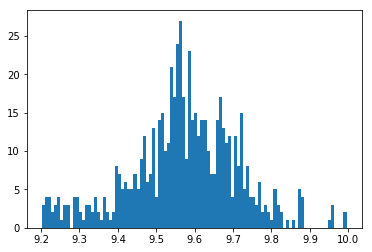

In [415]:
hist, xbins, cax = plt.hist(temp_oh,bins=100)

In [414]:
xbins

array([9.203009 , 9.210932 , 9.218856 , 9.22678  , 9.234703 , 9.242626 ,
       9.25055  , 9.258474 , 9.266397 , 9.274321 , 9.282245 , 9.290169 ,
       9.298092 , 9.306015 , 9.313939 , 9.321863 , 9.329786 , 9.337709 ,
       9.3456335, 9.353558 , 9.361481 , 9.369404 , 9.377328 , 9.385252 ,
       9.393175 , 9.401098 , 9.409022 , 9.416946 , 9.42487  , 9.432793 ,
       9.440717 , 9.448641 , 9.456564 , 9.464487 , 9.472411 , 9.480335 ,
       9.488258 , 9.4961815, 9.504106 , 9.51203  , 9.519953 , 9.527876 ,
       9.5358   , 9.543724 , 9.551647 , 9.55957  , 9.567494 , 9.575418 ,
       9.583342 , 9.591265 , 9.599189 , 9.607113 , 9.615036 , 9.622959 ,
       9.630883 , 9.638807 , 9.64673  , 9.654654 , 9.662578 , 9.670502 ,
       9.678425 , 9.686348 , 9.694272 , 9.702196 , 9.710119 , 9.718042 ,
       9.725966 , 9.733891 , 9.741814 , 9.749737 , 9.757661 , 9.765585 ,
       9.773508 , 9.781431 , 9.789355 , 9.797279 , 9.8052025, 9.813126 ,
       9.82105  , 9.828974 , 9.836897 , 9.84482  , 

In [416]:
bins

array([9.203009 , 9.210932 , 9.218856 , 9.22678  , 9.234703 , 9.242626 ,
       9.25055  , 9.258474 , 9.266397 , 9.274321 , 9.282245 , 9.290169 ,
       9.298092 , 9.306015 , 9.313939 , 9.321863 , 9.329786 , 9.337709 ,
       9.3456335, 9.353558 , 9.361481 , 9.369404 , 9.377328 , 9.385252 ,
       9.393175 , 9.401098 , 9.409022 , 9.416946 , 9.42487  , 9.432793 ,
       9.440717 , 9.448641 , 9.456564 , 9.464487 , 9.472411 , 9.480335 ,
       9.488258 , 9.4961815, 9.504106 , 9.51203  , 9.519953 , 9.527876 ,
       9.5358   , 9.543724 , 9.551647 , 9.55957  , 9.567494 , 9.575418 ,
       9.583342 , 9.591265 , 9.599189 , 9.607113 , 9.615036 , 9.622959 ,
       9.630883 , 9.638807 , 9.64673  , 9.654654 , 9.662578 , 9.670502 ,
       9.678425 , 9.686348 , 9.694272 , 9.702196 , 9.710119 , 9.718042 ,
       9.725966 , 9.733891 , 9.741814 , 9.749737 , 9.757661 , 9.765585 ,
       9.773508 , 9.781431 , 9.789355 , 9.797279 , 9.8052025, 9.813126 ,
       9.82105  , 9.828974 , 9.836897 , 9.84482  , 

In [430]:
np.hstack([xbins,bins])[66]

9.725966

####################################################
### 筛选星系 一共4675个，需要找出1222个【和论文一样】
### 10% of the star-forming spaxels
#### 25% of the galaxies in the sample
### 筛选条件:
> + #### stellar mass>10^9
> + ####  fracdeV< 0.7
> + #### b/a>=0.3
> + #### spaxels>=20

In [37]:
import time

# 每个星系至少有20个星系形成的spaxels
# for循环计算所有的mask，计算出sfr星系形成的地方，计数spaxel个数
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O

# 计算金属丰度
RR = (oii7+oii9) / nii    # Oii/Nii
# 计算mask
#masks_bpt, __, __ = new_maps.get_bpt()    # 使用bpt图筛选star-forming区域
#masks_bpt['sf']['global']
#RR.pixmask.schema    # 查看mask的种类列表
#mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
#mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
#new_mask = mask_non_sf | mask_bad_data
#######################################
# 两个方案
# 1. 只使用星系形成区域
# 2. 使用星系形成区域，并且去除bad data
#######################################

# 第一个方案，只考虑star formation 区域
#lala1_sfr = masks_bpt['sf']['global']
#num_sfr = np.shape(np.where(lala1_sfr == True))[1]
plfu_sfr = np.zeros([4675,3],dtype=int)
plfu_sfr[:,0] = basic['plate']
plfu_sfr[:,1] = basic['ifudsgn']
lalala_start = time.time()
for i in range(0,4675):
    start_for = time.time()
    plate = plfu_sfr[i,0]
    ifu = plfu_sfr[i,1]
    filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
    new_maps = Maps(filename=filename)
    masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)    # 使用bpt图筛选star-forming区域
    # 第一个方案，只考虑star formation 区域
    lala1_sfr = masks_bpt['sf']['global']
    num_sfr = np.shape(np.where(lala1_sfr == True))[1]
    plfu_sfr[i,2] = num_sfr
    end_for = time.time()
    print('用时: ',end_for-start_for,"  已经计算到第 ",i+1," 个星系   ","剩余 ",4675-i-1,' 个星系')
    
lalala_end = time.time()
print('\n\n\n总用时： ',str(lalala_end-lalala_start))
# save data to export a file
#np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat", plfu_sfr)

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))


用时:  1.9052858352661133   已经计算到第  1  个星系    剩余  4674  个星系
用时:  1.8523123264312744   已经计算到第  2  个星系    剩余  4673  个星系
用时:  1.4125912189483643   已经计算到第  3  个星系    剩余  4672  个星系
用时:  1.310802936553955   已经计算到第  4  个星系    剩余  4671  个星系
用时:  1.5257046222686768   已经计算到第  5  个星系    剩余  4670  个星系
用时:  1.3048999309539795   已经计算到第  6  个星系    剩余  4669  个星系
用时:  1.310819149017334   已经计算到第  7  个星系    剩余  4668  个星系
用时:  1.6489663124084473   已经计算到第  8  个星系    剩余  4667  个星系
用时:  1.2328901290893555   已经计算到第  9  个星系    剩余  4666  个星系
用时:  1.5743744373321533   已经计算到第  10  个星系    剩余  4665  个星系
用时:  1.3153386116027832   已经计算到第  11  个星系    剩余  4664  个星系
用时:  1.346574306488037   已经计算到第  12  个星系    剩余  4663  个星系
用时:  1.5572450160980225   已经计算到第  13  个星系    剩余  4662  个星系
用时:  1.3416213989257812   已经计算到第  14  个星系    剩余  4661  个星系
用时:  1.7341945171356201   已经计算到第  15  个星系    剩余  4660  个星系
用时:  1.4972155094146729   已经计算到第  16  个星系    剩余  4659  个星系
用时:  1.4048540592193604   已经计算到第  17  个星系    剩余  4658  个星系
用时:  1.55

用时:  1.2001018524169922   已经计算到第  140  个星系    剩余  4535  个星系
用时:  1.3733065128326416   已经计算到第  141  个星系    剩余  4534  个星系
用时:  1.335428237915039   已经计算到第  142  个星系    剩余  4533  个星系
用时:  1.3601672649383545   已经计算到第  143  个星系    剩余  4532  个星系
用时:  1.201249361038208   已经计算到第  144  个星系    剩余  4531  个星系
用时:  1.2706973552703857   已经计算到第  145  个星系    剩余  4530  个星系
用时:  1.4053113460540771   已经计算到第  146  个星系    剩余  4529  个星系
用时:  1.241295576095581   已经计算到第  147  个星系    剩余  4528  个星系
用时:  1.40598726272583   已经计算到第  148  个星系    剩余  4527  个星系
用时:  1.2335271835327148   已经计算到第  149  个星系    剩余  4526  个星系
用时:  1.3325576782226562   已经计算到第  150  个星系    剩余  4525  个星系
用时:  1.385310411453247   已经计算到第  151  个星系    剩余  4524  个星系
用时:  1.3767337799072266   已经计算到第  152  个星系    剩余  4523  个星系
用时:  1.6845011711120605   已经计算到第  153  个星系    剩余  4522  个星系
用时:  1.3707304000854492   已经计算到第  154  个星系    剩余  4521  个星系
用时:  1.331148624420166   已经计算到第  155  个星系    剩余  4520  个星系
用时:  1.7153685092926025   已经计算到第  156  个星系    剩

用时:  1.5265369415283203   已经计算到第  278  个星系    剩余  4397  个星系
用时:  1.2676312923431396   已经计算到第  279  个星系    剩余  4396  个星系
用时:  1.424389362335205   已经计算到第  280  个星系    剩余  4395  个星系
用时:  1.4364893436431885   已经计算到第  281  个星系    剩余  4394  个星系
用时:  1.289546251296997   已经计算到第  282  个星系    剩余  4393  个星系
用时:  1.4201922416687012   已经计算到第  283  个星系    剩余  4392  个星系
用时:  1.2071142196655273   已经计算到第  284  个星系    剩余  4391  个星系
用时:  1.397794246673584   已经计算到第  285  个星系    剩余  4390  个星系
用时:  1.4754929542541504   已经计算到第  286  个星系    剩余  4389  个星系
用时:  1.213042974472046   已经计算到第  287  个星系    剩余  4388  个星系
用时:  1.2666168212890625   已经计算到第  288  个星系    剩余  4387  个星系
用时:  1.3695154190063477   已经计算到第  289  个星系    剩余  4386  个星系
用时:  1.2691600322723389   已经计算到第  290  个星系    剩余  4385  个星系
用时:  1.333559274673462   已经计算到第  291  个星系    剩余  4384  个星系
用时:  1.233633279800415   已经计算到第  292  个星系    剩余  4383  个星系
用时:  1.2890169620513916   已经计算到第  293  个星系    剩余  4382  个星系
用时:  1.3886497020721436   已经计算到第  294  个星系    

用时:  1.2836496829986572   已经计算到第  416  个星系    剩余  4259  个星系
用时:  1.5174429416656494   已经计算到第  417  个星系    剩余  4258  个星系
用时:  1.3036582469940186   已经计算到第  418  个星系    剩余  4257  个星系
用时:  1.3706328868865967   已经计算到第  419  个星系    剩余  4256  个星系
用时:  1.5723083019256592   已经计算到第  420  个星系    剩余  4255  个星系
用时:  1.2768149375915527   已经计算到第  421  个星系    剩余  4254  个星系
用时:  1.4757087230682373   已经计算到第  422  个星系    剩余  4253  个星系
用时:  1.4072105884552002   已经计算到第  423  个星系    剩余  4252  个星系
用时:  1.3528997898101807   已经计算到第  424  个星系    剩余  4251  个星系
用时:  1.569685697555542   已经计算到第  425  个星系    剩余  4250  个星系
用时:  1.3981783390045166   已经计算到第  426  个星系    剩余  4249  个星系
用时:  1.514749526977539   已经计算到第  427  个星系    剩余  4248  个星系
用时:  1.1963701248168945   已经计算到第  428  个星系    剩余  4247  个星系
用时:  1.2619597911834717   已经计算到第  429  个星系    剩余  4246  个星系
用时:  1.4753601551055908   已经计算到第  430  个星系    剩余  4245  个星系
用时:  1.229820728302002   已经计算到第  431  个星系    剩余  4244  个星系
用时:  1.640242099761963   已经计算到第  432  个星系  

用时:  1.1958551406860352   已经计算到第  554  个星系    剩余  4121  个星系
用时:  1.3173103332519531   已经计算到第  555  个星系    剩余  4120  个星系
用时:  1.3500823974609375   已经计算到第  556  个星系    剩余  4119  个星系
用时:  1.212686538696289   已经计算到第  557  个星系    剩余  4118  个星系
用时:  1.4668731689453125   已经计算到第  558  个星系    剩余  4117  个星系
用时:  1.300337791442871   已经计算到第  559  个星系    剩余  4116  个星系
用时:  1.1949212551116943   已经计算到第  560  个星系    剩余  4115  个星系
用时:  1.4764738082885742   已经计算到第  561  个星系    剩余  4114  个星系
用时:  1.1981959342956543   已经计算到第  562  个星系    剩余  4113  个星系
用时:  1.370771884918213   已经计算到第  563  个星系    剩余  4112  个星系
用时:  1.352881669998169   已经计算到第  564  个星系    剩余  4111  个星系
用时:  1.3138575553894043   已经计算到第  565  个星系    剩余  4110  个星系
用时:  1.5520408153533936   已经计算到第  566  个星系    剩余  4109  个星系
用时:  1.2431178092956543   已经计算到第  567  个星系    剩余  4108  个星系
用时:  1.3422799110412598   已经计算到第  568  个星系    剩余  4107  个星系
用时:  1.16790771484375   已经计算到第  569  个星系    剩余  4106  个星系
用时:  1.4203159809112549   已经计算到第  570  个星系    

用时:  1.3772668838500977   已经计算到第  692  个星系    剩余  3983  个星系
用时:  1.224616289138794   已经计算到第  693  个星系    剩余  3982  个星系
用时:  1.1717123985290527   已经计算到第  694  个星系    剩余  3981  个星系
用时:  1.5174815654754639   已经计算到第  695  个星系    剩余  3980  个星系
用时:  1.3207156658172607   已经计算到第  696  个星系    剩余  3979  个星系
用时:  1.5608701705932617   已经计算到第  697  个星系    剩余  3978  个星系
用时:  1.28346848487854   已经计算到第  698  个星系    剩余  3977  个星系
用时:  1.3054912090301514   已经计算到第  699  个星系    剩余  3976  个星系
用时:  1.6327159404754639   已经计算到第  700  个星系    剩余  3975  个星系
用时:  1.2623474597930908   已经计算到第  701  个星系    剩余  3974  个星系
用时:  1.4586107730865479   已经计算到第  702  个星系    剩余  3973  个星系
用时:  1.2277495861053467   已经计算到第  703  个星系    剩余  3972  个星系
用时:  1.437488317489624   已经计算到第  704  个星系    剩余  3971  个星系
用时:  1.7238757610321045   已经计算到第  705  个星系    剩余  3970  个星系
用时:  1.4420578479766846   已经计算到第  706  个星系    剩余  3969  个星系
用时:  1.4755668640136719   已经计算到第  707  个星系    剩余  3968  个星系
用时:  1.4885118007659912   已经计算到第  708  个星系  

用时:  1.5177538394927979   已经计算到第  830  个星系    剩余  3845  个星系
用时:  1.3384194374084473   已经计算到第  831  个星系    剩余  3844  个星系
用时:  1.3605422973632812   已经计算到第  832  个星系    剩余  3843  个星系
用时:  1.6840200424194336   已经计算到第  833  个星系    剩余  3842  个星系
用时:  1.3013098239898682   已经计算到第  834  个星系    剩余  3841  个星系
用时:  1.2441225051879883   已经计算到第  835  个星系    剩余  3840  个星系
用时:  1.4240970611572266   已经计算到第  836  个星系    剩余  3839  个星系
用时:  1.345750331878662   已经计算到第  837  个星系    剩余  3838  个星系
用时:  1.4092085361480713   已经计算到第  838  个星系    剩余  3837  个星系
用时:  1.367685079574585   已经计算到第  839  个星系    剩余  3836  个星系
用时:  1.2253074645996094   已经计算到第  840  个星系    剩余  3835  个星系
用时:  1.3548309803009033   已经计算到第  841  个星系    剩余  3834  个星系
用时:  1.3054823875427246   已经计算到第  842  个星系    剩余  3833  个星系
用时:  1.4735560417175293   已经计算到第  843  个星系    剩余  3832  个星系
用时:  1.3093664646148682   已经计算到第  844  个星系    剩余  3831  个星系
用时:  1.2755494117736816   已经计算到第  845  个星系    剩余  3830  个星系
用时:  1.5978691577911377   已经计算到第  846  个星系

用时:  1.3575940132141113   已经计算到第  968  个星系    剩余  3707  个星系
用时:  1.2880427837371826   已经计算到第  969  个星系    剩余  3706  个星系
用时:  1.4097375869750977   已经计算到第  970  个星系    剩余  3705  个星系
用时:  1.2300896644592285   已经计算到第  971  个星系    剩余  3704  个星系
用时:  1.4855709075927734   已经计算到第  972  个星系    剩余  3703  个星系
用时:  1.2448558807373047   已经计算到第  973  个星系    剩余  3702  个星系
用时:  1.1363766193389893   已经计算到第  974  个星系    剩余  3701  个星系
用时:  1.5591373443603516   已经计算到第  975  个星系    剩余  3700  个星系
用时:  1.2685718536376953   已经计算到第  976  个星系    剩余  3699  个星系
用时:  1.3299710750579834   已经计算到第  977  个星系    剩余  3698  个星系
用时:  1.2076311111450195   已经计算到第  978  个星系    剩余  3697  个星系
用时:  1.2461214065551758   已经计算到第  979  个星系    剩余  3696  个星系
用时:  1.482903003692627   已经计算到第  980  个星系    剩余  3695  个星系
用时:  1.3296120166778564   已经计算到第  981  个星系    剩余  3694  个星系
用时:  1.4964520931243896   已经计算到第  982  个星系    剩余  3693  个星系
用时:  1.2404234409332275   已经计算到第  983  个星系    剩余  3692  个星系
用时:  1.4057540893554688   已经计算到第  984  个星

用时:  1.2414946556091309   已经计算到第  1104  个星系    剩余  3571  个星系
用时:  1.584669828414917   已经计算到第  1105  个星系    剩余  3570  个星系
用时:  1.2574074268341064   已经计算到第  1106  个星系    剩余  3569  个星系
用时:  1.5279664993286133   已经计算到第  1107  个星系    剩余  3568  个星系
用时:  1.2663531303405762   已经计算到第  1108  个星系    剩余  3567  个星系
用时:  1.2360453605651855   已经计算到第  1109  个星系    剩余  3566  个星系
用时:  1.388573408126831   已经计算到第  1110  个星系    剩余  3565  个星系
用时:  1.1509342193603516   已经计算到第  1111  个星系    剩余  3564  个星系
用时:  1.491058111190796   已经计算到第  1112  个星系    剩余  3563  个星系
用时:  1.2672381401062012   已经计算到第  1113  个星系    剩余  3562  个星系
用时:  1.3334333896636963   已经计算到第  1114  个星系    剩余  3561  个星系
用时:  1.4235014915466309   已经计算到第  1115  个星系    剩余  3560  个星系
用时:  1.3351223468780518   已经计算到第  1116  个星系    剩余  3559  个星系
用时:  1.4307482242584229   已经计算到第  1117  个星系    剩余  3558  个星系
用时:  1.215759038925171   已经计算到第  1118  个星系    剩余  3557  个星系
用时:  1.1792223453521729   已经计算到第  1119  个星系    剩余  3556  个星系
用时:  1.5175502300262451   已经

用时:  1.3074665069580078   已经计算到第  1239  个星系    剩余  3436  个星系
用时:  1.6677346229553223   已经计算到第  1240  个星系    剩余  3435  个星系
用时:  1.2604010105133057   已经计算到第  1241  个星系    剩余  3434  个星系
用时:  1.4259881973266602   已经计算到第  1242  个星系    剩余  3433  个星系
用时:  1.315101146697998   已经计算到第  1243  个星系    剩余  3432  个星系
用时:  1.2364907264709473   已经计算到第  1244  个星系    剩余  3431  个星系
用时:  1.521303415298462   已经计算到第  1245  个星系    剩余  3430  个星系
用时:  1.284625768661499   已经计算到第  1246  个星系    剩余  3429  个星系
用时:  1.4725110530853271   已经计算到第  1247  个星系    剩余  3428  个星系
用时:  1.3979237079620361   已经计算到第  1248  个星系    剩余  3427  个星系
用时:  1.1873257160186768   已经计算到第  1249  个星系    剩余  3426  个星系
用时:  1.452239751815796   已经计算到第  1250  个星系    剩余  3425  个星系
用时:  1.9258952140808105   已经计算到第  1251  个星系    剩余  3424  个星系
用时:  1.5570054054260254   已经计算到第  1252  个星系    剩余  3423  个星系
用时:  1.2333054542541504   已经计算到第  1253  个星系    剩余  3422  个星系
用时:  1.2639210224151611   已经计算到第  1254  个星系    剩余  3421  个星系
用时:  1.644700050354004   已经计

用时:  1.4843857288360596   已经计算到第  1374  个星系    剩余  3301  个星系
用时:  1.1782519817352295   已经计算到第  1375  个星系    剩余  3300  个星系
用时:  1.347712755203247   已经计算到第  1376  个星系    剩余  3299  个星系
用时:  1.5993177890777588   已经计算到第  1377  个星系    剩余  3298  个星系
用时:  1.228733777999878   已经计算到第  1378  个星系    剩余  3297  个星系
用时:  1.696448564529419   已经计算到第  1379  个星系    剩余  3296  个星系
用时:  1.277292013168335   已经计算到第  1380  个星系    剩余  3295  个星系
用时:  1.1845664978027344   已经计算到第  1381  个星系    剩余  3294  个星系
用时:  1.6848859786987305   已经计算到第  1382  个星系    剩余  3293  个星系
用时:  1.436732530593872   已经计算到第  1383  个星系    剩余  3292  个星系
用时:  1.4218811988830566   已经计算到第  1384  个星系    剩余  3291  个星系
用时:  1.2845101356506348   已经计算到第  1385  个星系    剩余  3290  个星系
用时:  1.5398187637329102   已经计算到第  1386  个星系    剩余  3289  个星系
用时:  1.4475836753845215   已经计算到第  1387  个星系    剩余  3288  个星系
用时:  1.341477394104004   已经计算到第  1388  个星系    剩余  3287  个星系
用时:  1.3998382091522217   已经计算到第  1389  个星系    剩余  3286  个星系
用时:  1.4030227661132812   已经计算

用时:  1.3717167377471924   已经计算到第  1509  个星系    剩余  3166  个星系
用时:  1.3527681827545166   已经计算到第  1510  个星系    剩余  3165  个星系
用时:  1.3757996559143066   已经计算到第  1511  个星系    剩余  3164  个星系
用时:  1.3968558311462402   已经计算到第  1512  个星系    剩余  3163  个星系
用时:  1.1698241233825684   已经计算到第  1513  个星系    剩余  3162  个星系
用时:  1.8634686470031738   已经计算到第  1514  个星系    剩余  3161  个星系
用时:  1.261575698852539   已经计算到第  1515  个星系    剩余  3160  个星系
用时:  1.379432201385498   已经计算到第  1516  个星系    剩余  3159  个星系
用时:  1.4924135208129883   已经计算到第  1517  个星系    剩余  3158  个星系
用时:  1.313016414642334   已经计算到第  1518  个星系    剩余  3157  个星系
用时:  1.523932695388794   已经计算到第  1519  个星系    剩余  3156  个星系
用时:  1.278196096420288   已经计算到第  1520  个星系    剩余  3155  个星系
用时:  1.2174150943756104   已经计算到第  1521  个星系    剩余  3154  个星系
用时:  1.4301445484161377   已经计算到第  1522  个星系    剩余  3153  个星系
用时:  1.218247652053833   已经计算到第  1523  个星系    剩余  3152  个星系
用时:  1.3339862823486328   已经计算到第  1524  个星系    剩余  3151  个星系
用时:  1.302370309829712   已经计算到

用时:  1.3618319034576416   已经计算到第  1644  个星系    剩余  3031  个星系
用时:  1.1999092102050781   已经计算到第  1645  个星系    剩余  3030  个星系
用时:  1.316786766052246   已经计算到第  1646  个星系    剩余  3029  个星系
用时:  1.5372130870819092   已经计算到第  1647  个星系    剩余  3028  个星系
用时:  1.3059501647949219   已经计算到第  1648  个星系    剩余  3027  个星系
用时:  1.4448230266571045   已经计算到第  1649  个星系    剩余  3026  个星系
用时:  1.31266450881958   已经计算到第  1650  个星系    剩余  3025  个星系
用时:  1.363551378250122   已经计算到第  1651  个星系    剩余  3024  个星系
用时:  1.3413152694702148   已经计算到第  1652  个星系    剩余  3023  个星系
用时:  1.341672658920288   已经计算到第  1653  个星系    剩余  3022  个星系
用时:  1.359914779663086   已经计算到第  1654  个星系    剩余  3021  个星系
用时:  1.2767038345336914   已经计算到第  1655  个星系    剩余  3020  个星系
用时:  1.5571062564849854   已经计算到第  1656  个星系    剩余  3019  个星系
用时:  1.7792961597442627   已经计算到第  1657  个星系    剩余  3018  个星系
用时:  1.3577470779418945   已经计算到第  1658  个星系    剩余  3017  个星系
用时:  1.8359510898590088   已经计算到第  1659  个星系    剩余  3016  个星系
用时:  1.3920257091522217   已经计算

用时:  1.698509931564331   已经计算到第  1779  个星系    剩余  2896  个星系
用时:  1.306960105895996   已经计算到第  1780  个星系    剩余  2895  个星系
用时:  1.3747472763061523   已经计算到第  1781  个星系    剩余  2894  个星系
用时:  1.2998933792114258   已经计算到第  1782  个星系    剩余  2893  个星系
用时:  1.152815580368042   已经计算到第  1783  个星系    剩余  2892  个星系
用时:  1.4617376327514648   已经计算到第  1784  个星系    剩余  2891  个星系
用时:  1.226991891860962   已经计算到第  1785  个星系    剩余  2890  个星系
用时:  1.4477286338806152   已经计算到第  1786  个星系    剩余  2889  个星系
用时:  1.2334470748901367   已经计算到第  1787  个星系    剩余  2888  个星系
用时:  1.2446181774139404   已经计算到第  1788  个星系    剩余  2887  个星系
用时:  1.4929404258728027   已经计算到第  1789  个星系    剩余  2886  个星系
用时:  1.234858512878418   已经计算到第  1790  个星系    剩余  2885  个星系
用时:  1.32645845413208   已经计算到第  1791  个星系    剩余  2884  个星系
用时:  1.3994193077087402   已经计算到第  1792  个星系    剩余  2883  个星系
用时:  1.296144962310791   已经计算到第  1793  个星系    剩余  2882  个星系
用时:  1.4632728099822998   已经计算到第  1794  个星系    剩余  2881  个星系
用时:  1.3250861167907715   已经计算到第

用时:  1.2880747318267822   已经计算到第  1914  个星系    剩余  2761  个星系
用时:  1.4121994972229004   已经计算到第  1915  个星系    剩余  2760  个星系
用时:  1.3835859298706055   已经计算到第  1916  个星系    剩余  2759  个星系
用时:  1.3728163242340088   已经计算到第  1917  个星系    剩余  2758  个星系
用时:  1.5610194206237793   已经计算到第  1918  个星系    剩余  2757  个星系
用时:  1.2450129985809326   已经计算到第  1919  个星系    剩余  2756  个星系
用时:  1.532780647277832   已经计算到第  1920  个星系    剩余  2755  个星系
用时:  1.3349380493164062   已经计算到第  1921  个星系    剩余  2754  个星系
用时:  1.4341251850128174   已经计算到第  1922  个星系    剩余  2753  个星系
用时:  1.5168752670288086   已经计算到第  1923  个星系    剩余  2752  个星系
用时:  1.281989574432373   已经计算到第  1924  个星系    剩余  2751  个星系
用时:  1.4022223949432373   已经计算到第  1925  个星系    剩余  2750  个星系
用时:  1.3052616119384766   已经计算到第  1926  个星系    剩余  2749  个星系
用时:  1.287989854812622   已经计算到第  1927  个星系    剩余  2748  个星系
用时:  1.4592585563659668   已经计算到第  1928  个星系    剩余  2747  个星系
用时:  1.3474535942077637   已经计算到第  1929  个星系    剩余  2746  个星系
用时:  1.4463176727294922   已

用时:  1.4504947662353516   已经计算到第  2049  个星系    剩余  2626  个星系
用时:  1.2396659851074219   已经计算到第  2050  个星系    剩余  2625  个星系
用时:  1.2681562900543213   已经计算到第  2051  个星系    剩余  2624  个星系
用时:  1.4374144077301025   已经计算到第  2052  个星系    剩余  2623  个星系
用时:  1.3460042476654053   已经计算到第  2053  个星系    剩余  2622  个星系
用时:  1.5296909809112549   已经计算到第  2054  个星系    剩余  2621  个星系
用时:  1.2188184261322021   已经计算到第  2055  个星系    剩余  2620  个星系
用时:  1.2417380809783936   已经计算到第  2056  个星系    剩余  2619  个星系
用时:  1.3747820854187012   已经计算到第  2057  个星系    剩余  2618  个星系
用时:  1.1656222343444824   已经计算到第  2058  个星系    剩余  2617  个星系
用时:  1.4978783130645752   已经计算到第  2059  个星系    剩余  2616  个星系
用时:  1.441640853881836   已经计算到第  2060  个星系    剩余  2615  个星系
用时:  1.2638671398162842   已经计算到第  2061  个星系    剩余  2614  个星系
用时:  1.5727522373199463   已经计算到第  2062  个星系    剩余  2613  个星系
用时:  1.2784230709075928   已经计算到第  2063  个星系    剩余  2612  个星系
用时:  1.7135186195373535   已经计算到第  2064  个星系    剩余  2611  个星系
用时:  1.2813644409179688  

用时:  1.3021864891052246   已经计算到第  2184  个星系    剩余  2491  个星系
用时:  1.435835838317871   已经计算到第  2185  个星系    剩余  2490  个星系
用时:  1.4399383068084717   已经计算到第  2186  个星系    剩余  2489  个星系
用时:  1.3571674823760986   已经计算到第  2187  个星系    剩余  2488  个星系
用时:  1.405278205871582   已经计算到第  2188  个星系    剩余  2487  个星系
用时:  1.2456755638122559   已经计算到第  2189  个星系    剩余  2486  个星系
用时:  1.2613718509674072   已经计算到第  2190  个星系    剩余  2485  个星系
用时:  1.3644402027130127   已经计算到第  2191  个星系    剩余  2484  个星系
用时:  1.33272123336792   已经计算到第  2192  个星系    剩余  2483  个星系
用时:  1.3681018352508545   已经计算到第  2193  个星系    剩余  2482  个星系
用时:  1.5595476627349854   已经计算到第  2194  个星系    剩余  2481  个星系
用时:  1.2260148525238037   已经计算到第  2195  个星系    剩余  2480  个星系
用时:  1.5744173526763916   已经计算到第  2196  个星系    剩余  2479  个星系
用时:  1.3822238445281982   已经计算到第  2197  个星系    剩余  2478  个星系
用时:  1.3241589069366455   已经计算到第  2198  个星系    剩余  2477  个星系
用时:  1.4557340145111084   已经计算到第  2199  个星系    剩余  2476  个星系
用时:  1.3229503631591797   已经

用时:  1.1691243648529053   已经计算到第  2319  个星系    剩余  2356  个星系
用时:  1.3916211128234863   已经计算到第  2320  个星系    剩余  2355  个星系
用时:  1.5529353618621826   已经计算到第  2321  个星系    剩余  2354  个星系
用时:  1.3648571968078613   已经计算到第  2322  个星系    剩余  2353  个星系
用时:  1.6316912174224854   已经计算到第  2323  个星系    剩余  2352  个星系
用时:  1.2542195320129395   已经计算到第  2324  个星系    剩余  2351  个星系
用时:  1.3443973064422607   已经计算到第  2325  个星系    剩余  2350  个星系
用时:  1.5892517566680908   已经计算到第  2326  个星系    剩余  2349  个星系
用时:  1.3185827732086182   已经计算到第  2327  个星系    剩余  2348  个星系
用时:  1.4903905391693115   已经计算到第  2328  个星系    剩余  2347  个星系
用时:  1.3158478736877441   已经计算到第  2329  个星系    剩余  2346  个星系
用时:  1.3928239345550537   已经计算到第  2330  个星系    剩余  2345  个星系
用时:  1.5584063529968262   已经计算到第  2331  个星系    剩余  2344  个星系
用时:  1.3310027122497559   已经计算到第  2332  个星系    剩余  2343  个星系
用时:  1.6095411777496338   已经计算到第  2333  个星系    剩余  2342  个星系
用时:  1.2756116390228271   已经计算到第  2334  个星系    剩余  2341  个星系
用时:  1.3719892501831055 

用时:  1.2035346031188965   已经计算到第  2454  个星系    剩余  2221  个星系
用时:  1.3967816829681396   已经计算到第  2455  个星系    剩余  2220  个星系
用时:  1.2468457221984863   已经计算到第  2456  个星系    剩余  2219  个星系
用时:  1.3510582447052002   已经计算到第  2457  个星系    剩余  2218  个星系
用时:  1.2402491569519043   已经计算到第  2458  个星系    剩余  2217  个星系
用时:  1.2719111442565918   已经计算到第  2459  个星系    剩余  2216  个星系
用时:  1.591048240661621   已经计算到第  2460  个星系    剩余  2215  个星系
用时:  1.382758617401123   已经计算到第  2461  个星系    剩余  2214  个星系
用时:  1.4656586647033691   已经计算到第  2462  个星系    剩余  2213  个星系
用时:  1.2522714138031006   已经计算到第  2463  个星系    剩余  2212  个星系
用时:  1.4169926643371582   已经计算到第  2464  个星系    剩余  2211  个星系
用时:  1.3866183757781982   已经计算到第  2465  个星系    剩余  2210  个星系
用时:  1.2761662006378174   已经计算到第  2466  个星系    剩余  2209  个星系
用时:  1.428821325302124   已经计算到第  2467  个星系    剩余  2208  个星系
用时:  1.3010406494140625   已经计算到第  2468  个星系    剩余  2207  个星系
用时:  1.2384932041168213   已经计算到第  2469  个星系    剩余  2206  个星系
用时:  1.3775057792663574   已

用时:  1.2753982543945312   已经计算到第  2589  个星系    剩余  2086  个星系
用时:  1.4215338230133057   已经计算到第  2590  个星系    剩余  2085  个星系
用时:  1.3339574337005615   已经计算到第  2591  个星系    剩余  2084  个星系
用时:  1.4646198749542236   已经计算到第  2592  个星系    剩余  2083  个星系
用时:  1.2808780670166016   已经计算到第  2593  个星系    剩余  2082  个星系
用时:  1.3037559986114502   已经计算到第  2594  个星系    剩余  2081  个星系
用时:  1.487816572189331   已经计算到第  2595  个星系    剩余  2080  个星系
用时:  1.2676348686218262   已经计算到第  2596  个星系    剩余  2079  个星系
用时:  1.3048162460327148   已经计算到第  2597  个星系    剩余  2078  个星系
用时:  1.5332245826721191   已经计算到第  2598  个星系    剩余  2077  个星系
用时:  1.3293075561523438   已经计算到第  2599  个星系    剩余  2076  个星系
用时:  1.5336740016937256   已经计算到第  2600  个星系    剩余  2075  个星系
用时:  1.2429344654083252   已经计算到第  2601  个星系    剩余  2074  个星系
用时:  1.294151782989502   已经计算到第  2602  个星系    剩余  2073  个星系
用时:  1.4525737762451172   已经计算到第  2603  个星系    剩余  2072  个星系
用时:  1.241584062576294   已经计算到第  2604  个星系    剩余  2071  个星系
用时:  1.4230687618255615   已

用时:  1.248082160949707   已经计算到第  2725  个星系    剩余  1950  个星系
用时:  1.522141695022583   已经计算到第  2726  个星系    剩余  1949  个星系
用时:  1.5039899349212646   已经计算到第  2727  个星系    剩余  1948  个星系
用时:  1.5031027793884277   已经计算到第  2728  个星系    剩余  1947  个星系
用时:  1.3364624977111816   已经计算到第  2729  个星系    剩余  1946  个星系
用时:  1.283372402191162   已经计算到第  2730  个星系    剩余  1945  个星系
用时:  1.4441204071044922   已经计算到第  2731  个星系    剩余  1944  个星系
用时:  1.3080501556396484   已经计算到第  2732  个星系    剩余  1943  个星系
用时:  1.750020980834961   已经计算到第  2733  个星系    剩余  1942  个星系
用时:  1.3476982116699219   已经计算到第  2734  个星系    剩余  1941  个星系
用时:  1.1927199363708496   已经计算到第  2735  个星系    剩余  1940  个星系
用时:  1.5309619903564453   已经计算到第  2736  个星系    剩余  1939  个星系
用时:  1.3898398876190186   已经计算到第  2737  个星系    剩余  1938  个星系
用时:  1.5711114406585693   已经计算到第  2738  个星系    剩余  1937  个星系
用时:  1.2462265491485596   已经计算到第  2739  个星系    剩余  1936  个星系
用时:  1.151949405670166   已经计算到第  2740  个星系    剩余  1935  个星系
用时:  1.5742502212524414   已经计

用时:  1.4581170082092285   已经计算到第  2860  个星系    剩余  1815  个星系
用时:  1.4129750728607178   已经计算到第  2861  个星系    剩余  1814  个星系
用时:  1.2802209854125977   已经计算到第  2862  个星系    剩余  1813  个星系
用时:  1.5136263370513916   已经计算到第  2863  个星系    剩余  1812  个星系
用时:  1.2063548564910889   已经计算到第  2864  个星系    剩余  1811  个星系
用时:  1.3646636009216309   已经计算到第  2865  个星系    剩余  1810  个星系
用时:  1.3640069961547852   已经计算到第  2866  个星系    剩余  1809  个星系
用时:  1.391164779663086   已经计算到第  2867  个星系    剩余  1808  个星系
用时:  1.3893375396728516   已经计算到第  2868  个星系    剩余  1807  个星系
用时:  1.2862248420715332   已经计算到第  2869  个星系    剩余  1806  个星系
用时:  1.4423768520355225   已经计算到第  2870  个星系    剩余  1805  个星系
用时:  1.3289384841918945   已经计算到第  2871  个星系    剩余  1804  个星系
用时:  1.3507800102233887   已经计算到第  2872  个星系    剩余  1803  个星系
用时:  1.4918742179870605   已经计算到第  2873  个星系    剩余  1802  个星系
用时:  1.2231132984161377   已经计算到第  2874  个星系    剩余  1801  个星系
用时:  1.4779386520385742   已经计算到第  2875  个星系    剩余  1800  个星系
用时:  1.2199320793151855  

用时:  1.3150036334991455   已经计算到第  2995  个星系    剩余  1680  个星系
用时:  1.213867425918579   已经计算到第  2996  个星系    剩余  1679  个星系
用时:  1.3829216957092285   已经计算到第  2997  个星系    剩余  1678  个星系
用时:  1.2141690254211426   已经计算到第  2998  个星系    剩余  1677  个星系
用时:  1.4683330059051514   已经计算到第  2999  个星系    剩余  1676  个星系
用时:  1.2922089099884033   已经计算到第  3000  个星系    剩余  1675  个星系
用时:  1.3243801593780518   已经计算到第  3001  个星系    剩余  1674  个星系
用时:  1.3691484928131104   已经计算到第  3002  个星系    剩余  1673  个星系
用时:  1.284973382949829   已经计算到第  3003  个星系    剩余  1672  个星系
用时:  1.5495011806488037   已经计算到第  3004  个星系    剩余  1671  个星系
用时:  1.2024729251861572   已经计算到第  3005  个星系    剩余  1670  个星系
用时:  1.2498271465301514   已经计算到第  3006  个星系    剩余  1669  个星系
用时:  1.4712510108947754   已经计算到第  3007  个星系    剩余  1668  个星系
用时:  1.2872178554534912   已经计算到第  3008  个星系    剩余  1667  个星系
用时:  1.4714257717132568   已经计算到第  3009  个星系    剩余  1666  个星系
用时:  1.454988718032837   已经计算到第  3010  个星系    剩余  1665  个星系
用时:  1.2258007526397705   已

用时:  1.5446734428405762   已经计算到第  3130  个星系    剩余  1545  个星系
用时:  1.474391222000122   已经计算到第  3131  个星系    剩余  1544  个星系
用时:  1.4968030452728271   已经计算到第  3132  个星系    剩余  1543  个星系
用时:  1.259181022644043   已经计算到第  3133  个星系    剩余  1542  个星系
用时:  1.2428786754608154   已经计算到第  3134  个星系    剩余  1541  个星系
用时:  1.4637985229492188   已经计算到第  3135  个星系    剩余  1540  个星系
用时:  1.2652380466461182   已经计算到第  3136  个星系    剩余  1539  个星系
用时:  1.5765504837036133   已经计算到第  3137  个星系    剩余  1538  个星系
用时:  1.339766263961792   已经计算到第  3138  个星系    剩余  1537  个星系
用时:  1.2960991859436035   已经计算到第  3139  个星系    剩余  1536  个星系
用时:  1.4746856689453125   已经计算到第  3140  个星系    剩余  1535  个星系
用时:  1.3504631519317627   已经计算到第  3141  个星系    剩余  1534  个星系
用时:  1.4900572299957275   已经计算到第  3142  个星系    剩余  1533  个星系
用时:  1.3350718021392822   已经计算到第  3143  个星系    剩余  1532  个星系
用时:  1.27622652053833   已经计算到第  3144  个星系    剩余  1531  个星系
用时:  1.4096813201904297   已经计算到第  3145  个星系    剩余  1530  个星系
用时:  1.4223222732543945   已经计

用时:  1.547191858291626   已经计算到第  3265  个星系    剩余  1410  个星系
用时:  1.3360803127288818   已经计算到第  3266  个星系    剩余  1409  个星系
用时:  1.5404798984527588   已经计算到第  3267  个星系    剩余  1408  个星系
用时:  1.2924830913543701   已经计算到第  3268  个星系    剩余  1407  个星系
用时:  1.335374116897583   已经计算到第  3269  个星系    剩余  1406  个星系
用时:  1.6636302471160889   已经计算到第  3270  个星系    剩余  1405  个星系
用时:  1.277846336364746   已经计算到第  3271  个星系    剩余  1404  个星系
用时:  1.408996820449829   已经计算到第  3272  个星系    剩余  1403  个星系
用时:  1.4091391563415527   已经计算到第  3273  个星系    剩余  1402  个星系
用时:  1.4443175792694092   已经计算到第  3274  个星系    剩余  1401  个星系
用时:  1.515925645828247   已经计算到第  3275  个星系    剩余  1400  个星系
用时:  1.2379066944122314   已经计算到第  3276  个星系    剩余  1399  个星系
用时:  1.4575796127319336   已经计算到第  3277  个星系    剩余  1398  个星系
用时:  1.1854629516601562   已经计算到第  3278  个星系    剩余  1397  个星系
用时:  1.18662428855896   已经计算到第  3279  个星系    剩余  1396  个星系
用时:  1.5621483325958252   已经计算到第  3280  个星系    剩余  1395  个星系
用时:  1.2542908191680908   已经计算到

用时:  1.4308757781982422   已经计算到第  3400  个星系    剩余  1275  个星系
用时:  1.6085498332977295   已经计算到第  3401  个星系    剩余  1274  个星系
用时:  1.3228416442871094   已经计算到第  3402  个星系    剩余  1273  个星系
用时:  1.431034803390503   已经计算到第  3403  个星系    剩余  1272  个星系
用时:  1.3263721466064453   已经计算到第  3404  个星系    剩余  1271  个星系
用时:  1.407362937927246   已经计算到第  3405  个星系    剩余  1270  个星系
用时:  1.4662365913391113   已经计算到第  3406  个星系    剩余  1269  个星系
用时:  1.25053071975708   已经计算到第  3407  个星系    剩余  1268  个星系
用时:  1.4826078414916992   已经计算到第  3408  个星系    剩余  1267  个星系
用时:  1.2767245769500732   已经计算到第  3409  个星系    剩余  1266  个星系
用时:  1.2550227642059326   已经计算到第  3410  个星系    剩余  1265  个星系
用时:  1.4588749408721924   已经计算到第  3411  个星系    剩余  1264  个星系
用时:  1.364182472229004   已经计算到第  3412  个星系    剩余  1263  个星系
用时:  1.3608531951904297   已经计算到第  3413  个星系    剩余  1262  个星系
用时:  1.2082548141479492   已经计算到第  3414  个星系    剩余  1261  个星系
用时:  1.237722396850586   已经计算到第  3415  个星系    剩余  1260  个星系
用时:  1.3388726711273193   已经计算

用时:  1.2646832466125488   已经计算到第  3535  个星系    剩余  1140  个星系
用时:  1.3027429580688477   已经计算到第  3536  个星系    剩余  1139  个星系
用时:  1.4118163585662842   已经计算到第  3537  个星系    剩余  1138  个星系
用时:  1.2347912788391113   已经计算到第  3538  个星系    剩余  1137  个星系
用时:  1.440101146697998   已经计算到第  3539  个星系    剩余  1136  个星系
用时:  1.278106689453125   已经计算到第  3540  个星系    剩余  1135  个星系
用时:  1.3010306358337402   已经计算到第  3541  个星系    剩余  1134  个星系
用时:  1.7196462154388428   已经计算到第  3542  个星系    剩余  1133  个星系
用时:  1.2119433879852295   已经计算到第  3543  个星系    剩余  1132  个星系
用时:  1.2865071296691895   已经计算到第  3544  个星系    剩余  1131  个星系
用时:  1.5583767890930176   已经计算到第  3545  个星系    剩余  1130  个星系
用时:  1.2629735469818115   已经计算到第  3546  个星系    剩余  1129  个星系
用时:  1.5849401950836182   已经计算到第  3547  个星系    剩余  1128  个星系
用时:  1.3980131149291992   已经计算到第  3548  个星系    剩余  1127  个星系
用时:  1.269073724746704   已经计算到第  3549  个星系    剩余  1126  个星系
用时:  1.5015244483947754   已经计算到第  3550  个星系    剩余  1125  个星系
用时:  1.251692295074463   已经

用时:  1.3067734241485596   已经计算到第  3670  个星系    剩余  1005  个星系
用时:  1.2096989154815674   已经计算到第  3671  个星系    剩余  1004  个星系
用时:  1.3177404403686523   已经计算到第  3672  个星系    剩余  1003  个星系
用时:  1.183962106704712   已经计算到第  3673  个星系    剩余  1002  个星系
用时:  1.3421308994293213   已经计算到第  3674  个星系    剩余  1001  个星系
用时:  1.2394115924835205   已经计算到第  3675  个星系    剩余  1000  个星系
用时:  1.3775639533996582   已经计算到第  3676  个星系    剩余  999  个星系
用时:  1.4021997451782227   已经计算到第  3677  个星系    剩余  998  个星系
用时:  1.278564691543579   已经计算到第  3678  个星系    剩余  997  个星系
用时:  1.4216301441192627   已经计算到第  3679  个星系    剩余  996  个星系
用时:  1.2493391036987305   已经计算到第  3680  个星系    剩余  995  个星系
用时:  1.2308688163757324   已经计算到第  3681  个星系    剩余  994  个星系
用时:  1.3664288520812988   已经计算到第  3682  个星系    剩余  993  个星系
用时:  1.2800672054290771   已经计算到第  3683  个星系    剩余  992  个星系
用时:  1.385023593902588   已经计算到第  3684  个星系    剩余  991  个星系
用时:  1.2846806049346924   已经计算到第  3685  个星系    剩余  990  个星系
用时:  1.2016828060150146   已经计算到第  368

用时:  1.2919507026672363   已经计算到第  3807  个星系    剩余  868  个星系
用时:  1.3241961002349854   已经计算到第  3808  个星系    剩余  867  个星系
用时:  1.4196372032165527   已经计算到第  3809  个星系    剩余  866  个星系
用时:  1.354247808456421   已经计算到第  3810  个星系    剩余  865  个星系
用时:  1.3950440883636475   已经计算到第  3811  个星系    剩余  864  个星系
用时:  1.3476183414459229   已经计算到第  3812  个星系    剩余  863  个星系
用时:  1.2639729976654053   已经计算到第  3813  个星系    剩余  862  个星系
用时:  1.3996715545654297   已经计算到第  3814  个星系    剩余  861  个星系
用时:  1.2992134094238281   已经计算到第  3815  个星系    剩余  860  个星系
用时:  1.3333444595336914   已经计算到第  3816  个星系    剩余  859  个星系
用时:  1.4298977851867676   已经计算到第  3817  个星系    剩余  858  个星系
用时:  1.269773244857788   已经计算到第  3818  个星系    剩余  857  个星系
用时:  1.5635311603546143   已经计算到第  3819  个星系    剩余  856  个星系
用时:  1.2891530990600586   已经计算到第  3820  个星系    剩余  855  个星系
用时:  1.1737239360809326   已经计算到第  3821  个星系    剩余  854  个星系
用时:  1.434971809387207   已经计算到第  3822  个星系    剩余  853  个星系
用时:  1.1755039691925049   已经计算到第  3823  个星系

用时:  1.3968267440795898   已经计算到第  3944  个星系    剩余  731  个星系
用时:  1.2713825702667236   已经计算到第  3945  个星系    剩余  730  个星系
用时:  1.4814977645874023   已经计算到第  3946  个星系    剩余  729  个星系
用时:  1.287118673324585   已经计算到第  3947  个星系    剩余  728  个星系
用时:  1.7252373695373535   已经计算到第  3948  个星系    剩余  727  个星系
用时:  1.339059591293335   已经计算到第  3949  个星系    剩余  726  个星系
用时:  1.2279608249664307   已经计算到第  3950  个星系    剩余  725  个星系
用时:  1.3923287391662598   已经计算到第  3951  个星系    剩余  724  个星系
用时:  1.2558073997497559   已经计算到第  3952  个星系    剩余  723  个星系
用时:  1.3797569274902344   已经计算到第  3953  个星系    剩余  722  个星系
用时:  1.3119120597839355   已经计算到第  3954  个星系    剩余  721  个星系
用时:  1.3030290603637695   已经计算到第  3955  个星系    剩余  720  个星系
用时:  1.5034098625183105   已经计算到第  3956  个星系    剩余  719  个星系
用时:  1.1600451469421387   已经计算到第  3957  个星系    剩余  718  个星系
用时:  1.3124094009399414   已经计算到第  3958  个星系    剩余  717  个星系
用时:  1.2140066623687744   已经计算到第  3959  个星系    剩余  716  个星系
用时:  1.2660183906555176   已经计算到第  3960  个星

用时:  1.281416654586792   已经计算到第  4082  个星系    剩余  593  个星系
用时:  1.415985107421875   已经计算到第  4083  个星系    剩余  592  个星系
用时:  1.2416138648986816   已经计算到第  4084  个星系    剩余  591  个星系
用时:  1.3301570415496826   已经计算到第  4085  个星系    剩余  590  个星系
用时:  1.1655988693237305   已经计算到第  4086  个星系    剩余  589  个星系
用时:  1.1264877319335938   已经计算到第  4087  个星系    剩余  588  个星系
用时:  1.4243760108947754   已经计算到第  4088  个星系    剩余  587  个星系
用时:  1.1713314056396484   已经计算到第  4089  个星系    剩余  586  个星系
用时:  1.283149003982544   已经计算到第  4090  个星系    剩余  585  个星系
用时:  1.182743787765503   已经计算到第  4091  个星系    剩余  584  个星系
用时:  1.1720654964447021   已经计算到第  4092  个星系    剩余  583  个星系
用时:  1.378141164779663   已经计算到第  4093  个星系    剩余  582  个星系
用时:  1.2291977405548096   已经计算到第  4094  个星系    剩余  581  个星系
用时:  1.3388347625732422   已经计算到第  4095  个星系    剩余  580  个星系
用时:  1.3078124523162842   已经计算到第  4096  个星系    剩余  579  个星系
用时:  1.3134584426879883   已经计算到第  4097  个星系    剩余  578  个星系
用时:  1.4428093433380127   已经计算到第  4098  个星系  

用时:  1.2573325634002686   已经计算到第  4220  个星系    剩余  455  个星系
用时:  1.2073867321014404   已经计算到第  4221  个星系    剩余  454  个星系
用时:  1.4678404331207275   已经计算到第  4222  个星系    剩余  453  个星系
用时:  1.191028356552124   已经计算到第  4223  个星系    剩余  452  个星系
用时:  1.4697682857513428   已经计算到第  4224  个星系    剩余  451  个星系
用时:  1.3203837871551514   已经计算到第  4225  个星系    剩余  450  个星系
用时:  1.2975363731384277   已经计算到第  4226  个星系    剩余  449  个星系
用时:  1.478705883026123   已经计算到第  4227  个星系    剩余  448  个星系
用时:  1.262592077255249   已经计算到第  4228  个星系    剩余  447  个星系
用时:  1.4607672691345215   已经计算到第  4229  个星系    剩余  446  个星系
用时:  1.3132305145263672   已经计算到第  4230  个星系    剩余  445  个星系
用时:  1.236030101776123   已经计算到第  4231  个星系    剩余  444  个星系
用时:  1.4194986820220947   已经计算到第  4232  个星系    剩余  443  个星系
用时:  1.1949875354766846   已经计算到第  4233  个星系    剩余  442  个星系
用时:  1.2105631828308105   已经计算到第  4234  个星系    剩余  441  个星系
用时:  1.3643105030059814   已经计算到第  4235  个星系    剩余  440  个星系
用时:  1.226525068283081   已经计算到第  4236  个星系  

用时:  1.2402465343475342   已经计算到第  4358  个星系    剩余  317  个星系
用时:  1.4250843524932861   已经计算到第  4359  个星系    剩余  316  个星系
用时:  1.394911766052246   已经计算到第  4360  个星系    剩余  315  个星系
用时:  1.2704858779907227   已经计算到第  4361  个星系    剩余  314  个星系
用时:  1.3930928707122803   已经计算到第  4362  个星系    剩余  313  个星系
用时:  1.3026220798492432   已经计算到第  4363  个星系    剩余  312  个星系
用时:  1.5263168811798096   已经计算到第  4364  个星系    剩余  311  个星系
用时:  1.3044226169586182   已经计算到第  4365  个星系    剩余  310  个星系
用时:  1.3340792655944824   已经计算到第  4366  个星系    剩余  309  个星系
用时:  1.4181814193725586   已经计算到第  4367  个星系    剩余  308  个星系
用时:  1.4642693996429443   已经计算到第  4368  个星系    剩余  307  个星系
用时:  1.6501741409301758   已经计算到第  4369  个星系    剩余  306  个星系
用时:  1.379711627960205   已经计算到第  4370  个星系    剩余  305  个星系
用时:  1.2727546691894531   已经计算到第  4371  个星系    剩余  304  个星系
用时:  1.5212981700897217   已经计算到第  4372  个星系    剩余  303  个星系
用时:  1.2194702625274658   已经计算到第  4373  个星系    剩余  302  个星系
用时:  1.4017090797424316   已经计算到第  4374  个星

用时:  1.4336302280426025   已经计算到第  4495  个星系    剩余  180  个星系
用时:  1.2574169635772705   已经计算到第  4496  个星系    剩余  179  个星系
用时:  1.1767847537994385   已经计算到第  4497  个星系    剩余  178  个星系
用时:  1.4369125366210938   已经计算到第  4498  个星系    剩余  177  个星系
用时:  1.2439944744110107   已经计算到第  4499  个星系    剩余  176  个星系
用时:  1.398024320602417   已经计算到第  4500  个星系    剩余  175  个星系
用时:  1.333183765411377   已经计算到第  4501  个星系    剩余  174  个星系
用时:  1.2484099864959717   已经计算到第  4502  个星系    剩余  173  个星系
用时:  1.4439003467559814   已经计算到第  4503  个星系    剩余  172  个星系
用时:  1.286949872970581   已经计算到第  4504  个星系    剩余  171  个星系
用时:  1.4778468608856201   已经计算到第  4505  个星系    剩余  170  个星系
用时:  1.2451064586639404   已经计算到第  4506  个星系    剩余  169  个星系
用时:  1.1719965934753418   已经计算到第  4507  个星系    剩余  168  个星系
用时:  1.4160804748535156   已经计算到第  4508  个星系    剩余  167  个星系
用时:  1.3082125186920166   已经计算到第  4509  个星系    剩余  166  个星系
用时:  1.4817852973937988   已经计算到第  4510  个星系    剩余  165  个星系
用时:  1.2366077899932861   已经计算到第  4511  个星系

用时:  1.3802604675292969   已经计算到第  4633  个星系    剩余  42  个星系
用时:  1.4621350765228271   已经计算到第  4634  个星系    剩余  41  个星系
用时:  1.210655689239502   已经计算到第  4635  个星系    剩余  40  个星系
用时:  1.1957695484161377   已经计算到第  4636  个星系    剩余  39  个星系
用时:  1.3762941360473633   已经计算到第  4637  个星系    剩余  38  个星系
用时:  1.3412325382232666   已经计算到第  4638  个星系    剩余  37  个星系
用时:  1.4581201076507568   已经计算到第  4639  个星系    剩余  36  个星系
用时:  1.3036248683929443   已经计算到第  4640  个星系    剩余  35  个星系
用时:  1.1975865364074707   已经计算到第  4641  个星系    剩余  34  个星系
用时:  1.3490393161773682   已经计算到第  4642  个星系    剩余  33  个星系
用时:  1.203428030014038   已经计算到第  4643  个星系    剩余  32  个星系
用时:  1.409996747970581   已经计算到第  4644  个星系    剩余  31  个星系
用时:  1.2692127227783203   已经计算到第  4645  个星系    剩余  30  个星系
用时:  1.220811367034912   已经计算到第  4646  个星系    剩余  29  个星系
用时:  1.4425225257873535   已经计算到第  4647  个星系    剩余  28  个星系
用时:  1.2761750221252441   已经计算到第  4648  个星系    剩余  27  个星系
用时:  1.4596891403198242   已经计算到第  4649  个星系    剩余  26  个星系
用

In [304]:
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_ba = nair_ba[np.where(nair_ba!=999999)]

In [311]:
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij.shape

(1131, 2)

In [399]:
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
a = plfu_sfr[:,1]
print(a.shape)
print(np.max(a))
print(np.min(a))
print(np.mean(a))

(4675,)
12705.0
1901.0
7336.551871657754


### lalala-stop
检查为何将全部的 manga_nair 匹配星系较小的nair 的b/a赋值给manga_ba，筛选结果不减反增？？？！！！
方法：新建一个空白notebook，将代码完整拷贝过去从头检查！！！

In [394]:

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])

# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################
b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a

# 星系质量筛选
# stellar mass > 10^9 太阳质量
glo_mass_id = basic_manga['PHOTOMETRIC_MASS'] > 10e8
glo_mass_id = glo_mass_id[tmp_num_ij[:,1]]    # 匹配数组维度

# 星系star-forming区域筛选
# sfr spaxels >= 20
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id = np.where(plfu_sfr[:,2]>=20)

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]

# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
fra_b_over_a[glo_mass_id,2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差 ",np.shape(sel_galaxy)[1]-1222,"个")



#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,0],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# nair_b/a中较小的值
nair_manga_id = nair_manga_id[np.where(nair_ba<=1)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=1)]


manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息

# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==nair_manga_id[j,1])and(manga_ba[i] > nair_ba[j]):
            manga_ba[i] = 0
            #manga_ba[i] = nair_ba[j]
        #if manga_id[i]==nair_manga_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果








# ###################################################################
# # 第六次筛选：nair_ba>=0.3，匹配星系在nair中小于某一值
# # 先尝试0.3，论文中的条件为：中位数0.3，平均数0.31【对于整体14000样本而言】
# # 通过循环，逐渐尝试nair_ba<x, 一直到某个x满足上述条件
# # 之后再与manga进行匹配，从manga中剔除匹配到的倾斜较大的星系


# # 读取manga vs nair 匹配数组
# last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# # 去重
# tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
# tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
# #a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
# a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
# tmp_num_ij = tmp_num_ij[last_num]
# tmp_num_ij = tmp_num_ij.astype(np.int64)
# # manga数组编号为tmp_num_ij[:,0]
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较小的值
# nair_ba = nair_ba[np.where(nair_ba<1)]
# nair_manga_id = nair_manga_id[np.where(nair_ba<1)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if (manga_id[i]==nair_manga_id[j,1])&(manga_ba[i] > nair_ba[j]):
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 六次筛选结果



# # 第七次筛选：通过限定匹配星系在nair中大于某一值
# # nair catalog 的b/a为nair_ba
# nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# # 剔除999999坏数据
# tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
# nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
# nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# # nair_b/a中较大的值
# nair_ba = nair_ba[np.where(nair_ba>0.8)]
# nair_manga_id = nair_manga_id[np.where(nair_ba>0.8)]    # 数组位置进行同步筛选

# manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
# #manga_id前面已赋值4561个星系，即所在的数组位置信息

# # for 循环将manga_ba的值替换成nair中b/a较小的值
# for i in range(0,manga_ba.size):    # 循环nsa
#     for j in range(0,nair_ba.size):    # 循环nair
#         if manga_id[i]==nair_manga_id[j,1]:
#             manga_ba[i] = nair_ba[j]
#             #fra_b_over_a[i,2]+=1
            

            
# fra_b_over_a[:,1] = manga_ba    # 替换完成
# fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
# sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 七次次筛选结果
print("已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差 ",np.shape(sel_galaxy)[1]-1222,"个")


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/nsa_v1_0_1.fits' mode='rb' closefd=True>


已从 manga 4675 个星系中找出  1510  个星系 
距论文中的 1222 个星系还差  288 个
已从 manga 4675 个星系中找出  1472  个星系 
距论文中的 1222 个星系还差  250 个


In [390]:
# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a
plt_nair_manga = np.zeros([nair_ba.size,2])
plt_nair_manga[:,0] = nair_ba


nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################
b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]
manga_ba = fra_b_over_a[:,1]

# 匹配生成画图数组
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if manga_id[i]==nair_manga_id[j,1]:
            
            plt_nair_manga[j,1] = manga_ba[i]
            
print(plt_nair_manga.shape)
print(np.min(plt_nair_manga))

(1125, 2)
0.0


In [391]:
np.shape(np.where(plt_nair_manga[:,1]!=0))

(1, 238)

In [336]:
# 第六次筛选：nair_ba>=0.3
# 先尝试0.3，论文中的条件为：中位数0.3，平均数0.31【对于整体14000样本而言】
# 通过循环，逐渐尝试nair_ba<x, 一直到某个x满足上述条件
# 之后再与manga进行匹配，从manga中剔除匹配到的倾斜较大的星系


# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

# nair_b/a中较小的值
nair_ba = nair_ba[np.where(nair_ba<=0.3)]
nair_manga_id = nair_manga_id[np.where(nair_ba<=0.3)]    # 数组位置进行同步筛选

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息

# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if manga_id[i]==nair_manga_id[j,1]:
            manga_ba[i] = nair_ba[j]

            
fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==6)    # 六次筛选结果

print("已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差 ",np.shape(sel_galaxy)[1]-1222,"个")






已从 manga 4675 个星系中找出  1860  个星系 
距论文中的 1222 个星系还差  638 个


In [355]:
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息

# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==nair_manga_id[j,1]) & (manga_ba[i] > nair_ba[j]):
            manga_ba[i] = nair_ba[j]

            
fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果

print("已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差 ",np.shape(sel_galaxy)[1]-1222,"个")



已从 manga 4675 个星系中找出  993  个星系 
距论文中的 1222 个星系还差  -229 个


In [332]:
# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_manga_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a

a=nair_manga_id
b=nair_ba
print(a.shape)
print(np.max(b))

(1125, 2)
0.993


In [137]:
i=233
plfu_sfr = np.zeros([4675,3],dtype=int)
plfu_sfr[:,0] = basic['plate']
plfu_sfr[:,1] = basic['ifudsgn']
plate = plfu_sfr[i,0]
ifu = plfu_sfr[i,1]
plfu_sfr[66:77,0]
''.join([str(plate),'-',str(ifu)])

'8439-3703'

In [59]:
sfr_id = np.where(plfu_sfr[:,2]>=20)
np.shape(sfr_id)
glo_mass_id = basic['PHOTOMETRIC_MASS'] > 10e8
glo_mass_id[sfr_id].shape

(2364,)

In [63]:
np.shape(sel_galaxy)

(1, 1632)

In [152]:
masks_bpt, __, __ = new_maps.get_bpt(show_plot=False)
masks_bpt

{'sf': {'global': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'nii': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'sii': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, Fals

In [121]:
masks_bpt?

In [116]:
np.shape(sel_galaxy)

(1, 2003)

In [26]:
lalala_galid =  basic['PHOTOMETRIC_MASS'] > 100000

In [28]:
# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')
sel_fracDeV = fracDeV[np.where(fracDeV<0.7)]    # late-type galaxies

In [75]:
# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
sel_b_over_a = np.where(b_over_a>=0.3)

In [103]:
fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a[:,1] = b_over_a

fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1

sel_galaxy = np.where(fra_b_over_a[:,2]==2)

In [91]:
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1

sel_galaxy = np.where(fra_b_over_a[:,2]==2)

In [104]:
np.shape(sel_galaxy)

(1, 2268)

In [51]:
import math
(2/(((QQ**2+UU**2)**0.5)+1))-1

4.0

In [60]:
2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1

array([0.85124633, 0.68426807, 0.79767208, ..., 0.75380264, 0.70195384,
       0.56631757])

In [61]:
2/2+1

2.0

In [ ]:
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 【定位数组】星系在2800长的数组中的位置

In [ ]:
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据

In [ ]:
redshift = basic['REDSHIFT'][galid][0]    # galaxy红移

In [25]:
glo_mass = basic['PHOTOMETRIC_MASS']
glo_mass[5]

12431000000.0

In [16]:
basic

FITS_rec([('1-138087', '8252-12701', 8252, '12701', 144.23926 ,  4.8294117e+01, 0.0251821, 1.40308e+09, 'v2_4_3', 'v2_2_1', 'v1_1_0'),
          ('1-210173', '8979-12701', 8979, '12701', 241.34177 ,  4.2488312e+01, 0.0782043, 4.32497e+10, 'v2_4_3', 'v2_2_1', 'v1_1_0'),
          ('1-456925', '8933-6102', 8933, '6102', 194.85555 ,  2.7967939e+01, 0.0256044, 6.19020e+09, 'v2_4_3', 'v2_2_1', 'v1_1_0'),
          ...,
          ('1-604052', '8084-3702', 8084, '3702',  50.636642, -1.2126936e-03, 0.0219891, 4.59672e+09, 'v2_4_3', 'v2_2_1', 'v1_1_0'),
          ('1-109308', '8082-12704', 8082, '12704',  49.949562, -2.2114541e-01, 0.13193  , 1.08103e+11, 'v2_4_3', 'v2_2_1', 'v1_1_0'),
          ('1-209287', '8485-12704', 8485, '12704', 233.68521 ,  4.8731522e+01, 0.0415373, 1.60425e+09, 'v2_4_3', 'v2_2_1', 'v1_1_0')],
         dtype=(numpy.record, [('MANGAID', 'S20'), ('PLATEIFU', 'S20'), ('PLATE', '>i2'), ('IFUDSGN', 'S20'), ('OBJRA', '>f4'), ('OBJDEC', '>f4'), ('REDSHIFT', '>f4'), ('PHOTOMET

In [27]:
lalala_galid

array([ True,  True,  True, ...,  True,  True,  True])

In [11]:
obj_ra = basic['OBJRA']
obj_dec = basic['OBJDEC']

In [46]:
np.savetxt('/root/manga_obj_ra.csv', obj_ra, delimiter = ',')
np.savetxt('/root/manga_obj_dec.csv', obj_dec, delimiter = ',')

In [12]:
np.savetxt('/root/manga_obj_ra.dat', obj_ra)
np.savetxt('/root/manga_obj_dec.dat', obj_dec)

################################################
### 显示b/a以及image

             b/a =       0.312


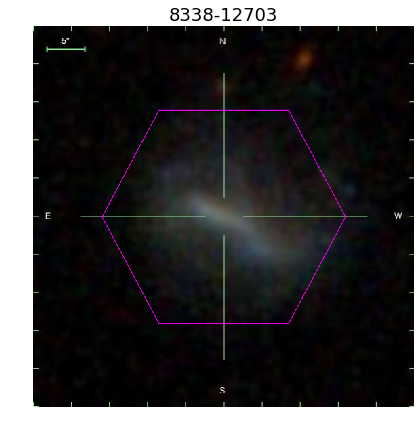

In [21]:
# check b/a whether correct
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
import random
import matplotlib.pyplot as plt
from marvin.tools.image import Image
 
temp_plate = basic['plate']
temp_ifu = basic['ifudsgn']
temp_id = random.randint(0,4674)
# b/a为负数的三个星系的数组位置：334,  883, 3234
# 原因推测：Stokes Parameter，Q和U计算有瑕疵导致的
temp_id =3234
plate = temp_plate[temp_id]
ifu = temp_ifu[temp_id]

# 获取数据
#new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
# 路径变量设置示例：mstar = pd.read_csv(join(path_data, 'manga-{}_mstar.csv'.format(maps.plateifu)))
filename = join(path_marvin_data, 'manga-{}-MAPS-VOR10-GAU-MILESHC.fits.gz'.format(''.join([str(plate),'-',str(ifu)])))
new_maps = Maps(filename=filename)
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
# 将部分b/a<0的值重新计算
# 由于这几个特殊情况 b>a，因此出现了负数
#minus_b_over_a = np.where(b_over_a<0)
#for i in range(0,np.size(minus_b_over_a)):
#    ii = minus_b_over_a[0][i]
#    b_over_a[ii] = 2/(-(q_u[ii,0]**2+q_u[ii,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)
#print('plate-ifu: ',''.join([str(plate),'-',str(ifu)]),'\nb/a =      ',"%.3f"%b_over_a[temp_id])
print('             b/a =      ',"%.3f"%b_over_a[temp_id])

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
path_image_data = '/root/cosmos/data/images'
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])

temp_image = mpimg.imread(image_path)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [216]:
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
# 将部分b/a<0的值重新计算
# 由于这几个特殊情况 b>a，因此出现了负数
minus_b_over_a = np.where(b_over_a<0)
for i in range(0,np.size(minus_b_over_a)):
    ii = minus_b_over_a[0][i]
    b_over_a[ii] = 2/(-(q_u[ii,0]**2+q_u[ii,1]**2)**0.5+1)-1

In [215]:
minus_b_over_a = np.where(b_over_a<0)
minus_b_over_a[0][1]

883

In [221]:
np.where(b_over_a<0)

(array([ 334,  883, 3234]),)

In [229]:
ii = 883
2/((((q_u[ii,0]**2+q_u[ii,1]**2)**0.5)+1))-1

-0.12164255216112874

In [230]:
q_u[ii,0]

0.827349

In [231]:
q_u[ii,1]

0.97271

############################################################
### 通过下载4675个星系的images，读取并显示任一星系的image

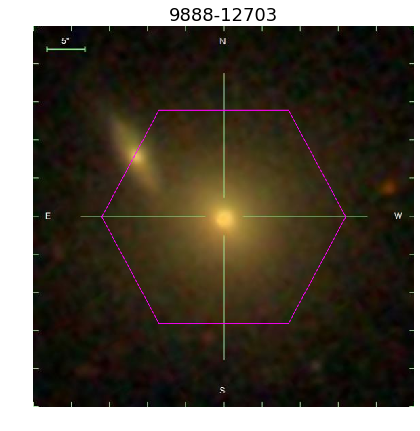

In [166]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#9888-12703
plate = 9888
ifu = 12703
path_image_data = '/root/cosmos/data/images'
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])

temp_image = mpimg.imread(image_path)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


####################################
### 椭圆率ellipticity 的大概分布

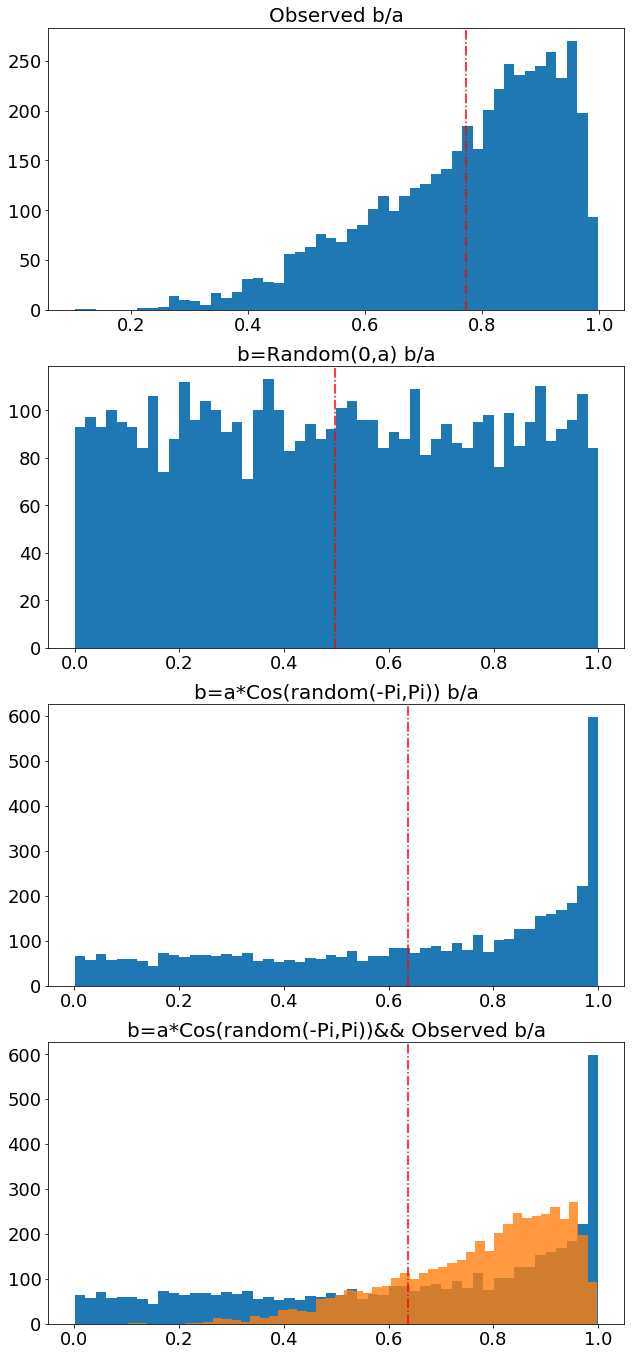

In [13]:
# b/a的分布
# 观测到的b/a
# 随机(0,a),以a为标准
# 随机(-Pi,Pi),以a为标准
from pylab import *
import math
import random
# observed b/a[q_r and u_r]
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)

# random (0,a)
ran_b_o_a = np.zeros([b_over_a.size,3])
ran_b_o_a[:,0] = 1/b_over_a    # 第一列存储A
ran_b_o_a[:,1] = np.random.rand(b_over_a.size) *  ran_b_o_a[:,0]  # 第二列存储随机的B=A*random(0,1)
ran_b_o_a[:,2] = ran_b_o_a[:,1]/ran_b_o_a[:,0]# 第三列存储b/a

# random(-Pi,Pi)
ran_pi_a_b = np.zeros([b_over_a.size,3])
ran_pi_a_b[:,0] = 1/b_over_a    # 第一列存储A
# 第二列存储随机的B=A*Cos(random(-Pi,Pi))
#ran_pi_a_b[:,1] = np.abs(np.cos(np.random.rand(b_over_a.size)*math.pi*2-math.pi) *  ran_pi_a_b[:,0])
temp_test = np.random.rand(b_over_a.size)
ran_pi_a_b[:,1] = np.abs(np.cos(temp_test * math.pi*2-math.pi) *  ran_pi_a_b[:,0])

ran_pi_a_b[:,2] = ran_pi_a_b[:,1]/ran_pi_a_b[:,0]# 第三列存储b/a

## random(0,Pi/2)
#ran_pi2_a_b = np.zeros([b_over_a.size,3])
#ran_pi2_a_b[:,0] = 1/b_over_a    # 第一列存储A
## 第二列存储随机的B=A*Cos(random(-Pi,Pi))
##ran_pi2_a_b[:,1] = np.abs(np.cos(np.random.rand(b_over_a.size)*math.pi/2) *  ran_pi2_a_b[:,0])
#ran_pi2_a_b[:,1] = np.abs(np.cos(temp_test*math.pi/2) *  ran_pi2_a_b[:,0])
#ran_pi2_a_b[:,2] = ran_pi2_a_b[:,1]/ran_pi2_a_b[:,0]# 第三列存储b/a

plt.figure(figsize=(10,15))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

plt.subplot(4,1,1)
plt.hist(b_over_a,bins=50);
plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');       
plt.title('Observed b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(4,1,2)
plt.hist(ran_b_o_a[:,2],bins=50);
plt.axvline(np.mean(ran_b_o_a[:,2]),color='r',linestyle='-.');
plt.title('b=Random(0,a) b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(4,1,3)
plt.hist(ran_pi_a_b[:,2],bins=50);
plt.axvline(np.mean(ran_pi_a_b[:,2]),color='r',linestyle='-.');
plt.title('b=a*Cos(random(-Pi,Pi)) b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(4,1,4)

plt.hist(ran_pi_a_b[:,2],bins=50);
plt.hist(b_over_a,bins=50,alpha=0.8);
plt.axvline(np.mean(ran_pi_a_b[:,2]),color='r',linestyle='-.');
plt.title('b=a*Cos(random(-Pi,Pi))&& Observed b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.show()

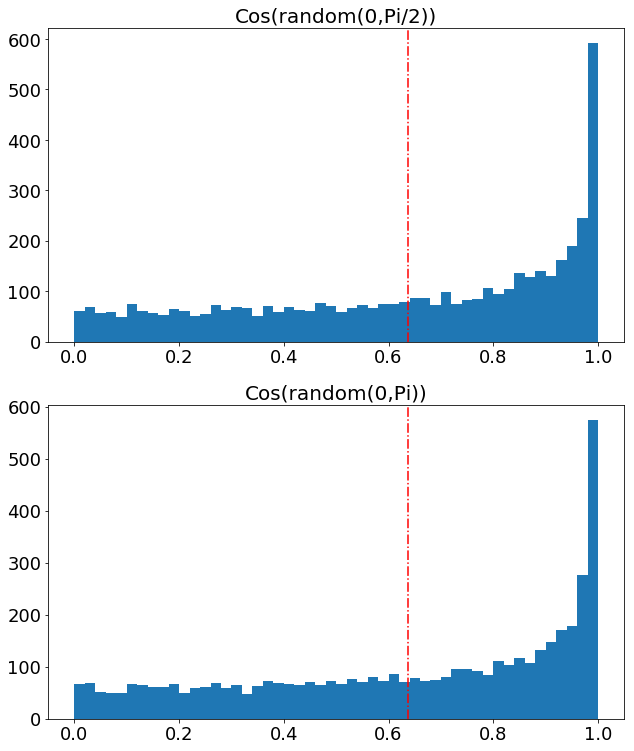

In [384]:
random_size = 4675
# 第二列存储随机的B=A*Cos(random(-Pi,Pi))
#ran_pi2_a_b[:,1] = np.abs(np.cos(np.random.rand(b_over_a.size)*math.pi/2) *  ran_pi2_a_b[:,0])
temp_test = np.random.rand(random_size)
ran_pi2_a_b = np.abs(np.cos(temp_test*math.pi/2))
ran_pi_a_b = np.abs(np.cos(temp_test*math.pi))

plt.figure(figsize=(10,8))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

plt.subplot(2,1,1)
plt.hist(ran_pi2_a_b,bins=50);
plt.axvline(np.mean(ran_pi2_a_b),color='r',linestyle='-.');
plt.title('Cos(random(0,Pi/2))',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(2,1,2)
plt.hist(ran_pi_a_b,bins=50);
plt.axvline(np.mean(ran_pi_a_b),color='r',linestyle='-.');
plt.title('Cos(random(0,Pi))',fontsize=20);
plt.tick_params(labelsize=18)

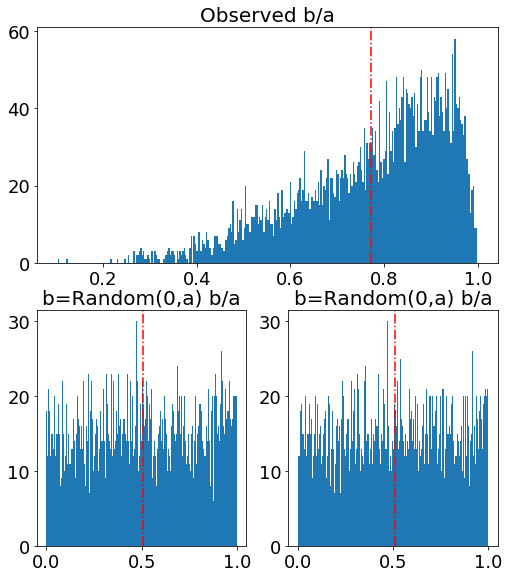

In [346]:
plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)
plt.subplot(2,1,1)
plt.hist(b_over_a,bins=300);
plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');       
plt.title('Observed b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(2,2,3)
plt.hist(ran_b_o_a[:,2],bins=300);
plt.axvline(np.mean(ran_b_o_a[:,2]),color='r',linestyle='-.');
plt.title('b=Random(0,a) b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.subplot(2,2,4)
plt.hist(ran_b_o_a[:,2],bins=300);
plt.axvline(np.mean(ran_b_o_a[:,2]),color='r',linestyle='-.');
plt.title('b=Random(0,a) b/a',fontsize=20);
plt.tick_params(labelsize=18)

plt.show()

In [350]:
import math
math.cos(math.pi/2)

6.123233995736766e-17

In [355]:
ran_b_o_a = np.zeros([b_over_a.size,3])
ran_b_o_a[:,0] = 1/b_over_a    # 第一列存储A，第二列存储随机的B，第三列存储b/a
ran_b_o_a[:,0]
np.cos([math.pi,60,30])

array([-1.        , -0.95241298,  0.15425145])

In [300]:
import random
random.uniform(0,)

7.0488870141352145

In [296]:
random.uniform(1, 10)
np.random.rand(4)

array([0.20553652, 0.79813567, 0.28061854, 0.14584401])

In [187]:
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1

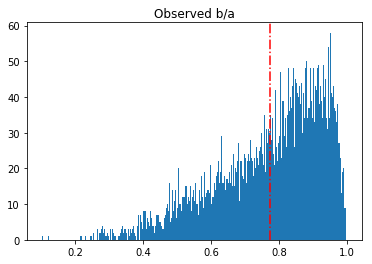

In [272]:
plt.hist(b_over_a,bins=300);
plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');
plt.title('Observed b/a');

In [260]:
plt.axvline?linestyle='--'

In [195]:
# b/a 的平均值
mean_b_over_a = np.sum(b_over_a)

(array([ 334,  883, 3234]),)

In [202]:
b_over_a.size

4675

In [205]:
np.abs(b_over_a)

array([0.85124633, 0.68426807, 0.79767208, ..., 0.75380264, 0.70195384,
       0.56631757])

In [112]:
lala = np.array([0,1,1,1,2,3,4,5,6,9,8,88])
for i in range(0,lala.size):
    if (lala[i]>0) & (lala[i]<10)& (lala[i]<6) :
        print(lala[i])

1
1
1
2
3
4
5


In [288]:
###########################
# 寻找manga与Nair & Abraham (2010)中一样的星系
###########################
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pylab import *
import copy
#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性
basic = vac[1].data 
# 获取ra和dec信息
old_ra = basic['OBJRA']
old_dec = basic['OBJDEC']

# read the new data of ra and dec
# 0 = ra, dec = 1, b/a = 2
new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

old_same_gal = np.zeros((old_ra.size,1))
new_same_gal = np.zeros((new_ra_dec[:,0].size,1))
last_same_gal =  np.zeros((old_ra.size,2))-999
delta_radec = 0.001
for i in range(0,old_ra.size):
#for i in range(0,50):
    for j in range(0,new_ra_dec[:,0].size):
        if (old_ra[i]<new_ra_dec[j,0]+delta_radec) and (old_ra[i]>new_ra_dec[j,0]-delta_radec) and (old_dec[i]>new_ra_dec[j,1]-delta_radec) and (old_dec[i]<new_ra_dec[j,1]+delta_radec):
            old_same_gal[i,0] += 1
            new_same_gal[j,0] += 1
            last_same_gal[i,0] = i
            last_same_gal[i,1] = j
            #print("find **** one same *******")
            print("Bingo!  ","i = ",i,"j = ",j)
#            print("finish ",i," galaxies, there're ",old_ra.size-i," remaining")






'''
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

#print(old_num_same_gal)
#print(new_num_same_gal)

# 根据编号取出 b_over_a数据
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)
old_ba = b_over_a[old_num_same_gal]    #Manga数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[new_num_same_gal]    #Nair catalog数据中的b/a

last_num = last_num.astype(np.int32)
sdss_ba = b_over_a[last_same_gal[last_num,0]]
nair_ba = tmp_new_ba[last_same_gal[last_num,1]]

'''
'''
画图
'''

'''
plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

# 检查数组形状
print("old_ba数组形状为 ",old_ba.shape)
print("new_ba数组形状为 ",new_ba.shape)

# 去除nair catalog数据中无效数据999999
tmp_new_ba = new_ba[np.where(new_ba<=1)]
delta_bins = 50    # 设置分组大小

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)

plt.subplot(3,1,1)
plt.hist(old_ba,bins=delta_bins);
plt.axvline(np.mean(old_ba),color='r',linestyle='-.');
plt.title('MaNGA data(old)');

plt.subplot(3,1,2)
plt.hist(tmp_new_ba,bins=delta_bins);
plt.axvline(np.mean(tmp_new_ba),color='r',linestyle='-.');
plt.title('Nair data(new)');

plt.subplot(3,1,3)
plt.hist(tmp_new_ba,bins=delta_bins);
plt.hist(old_ba,bins=delta_bins,alpha=0.8);


plt.title('MaNGA && Nair b/a',fontsize=20);
plt.tick_params(labelsize=18)


# 使用hist2D画出 b/a_sdss vs. b/a_Nair
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
print(xbins)
print(ybins)
xbins[1]

'''

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits' mode='rb' closefd=True>
  # Remove the CWD from sys.path while we load stuff.


Bingo!   i =  1 j =  9450
Bingo!   i =  8 j =  9510
Bingo!   i =  11 j =  3492
Bingo!   i =  13 j =  1678
Bingo!   i =  15 j =  9770
Bingo!   i =  16 j =  1645
Bingo!   i =  25 j =  11146
Bingo!   i =  26 j =  9615
Bingo!   i =  28 j =  9373
Bingo!   i =  29 j =  5796
Bingo!   i =  35 j =  6177
Bingo!   i =  37 j =  5196
Bingo!   i =  43 j =  12095
Bingo!   i =  49 j =  6828
Bingo!   i =  57 j =  12075
Bingo!   i =  66 j =  4721
Bingo!   i =  67 j =  8073
Bingo!   i =  68 j =  6121
Bingo!   i =  70 j =  11459
Bingo!   i =  72 j =  4677
Bingo!   i =  78 j =  1924
Bingo!   i =  83 j =  1321
Bingo!   i =  89 j =  3173
Bingo!   i =  99 j =  5611
Bingo!   i =  100 j =  9920
Bingo!   i =  104 j =  13609
Bingo!   i =  107 j =  7397
Bingo!   i =  108 j =  5381
Bingo!   i =  115 j =  9848
Bingo!   i =  118 j =  9474
Bingo!   i =  123 j =  11089
Bingo!   i =  129 j =  6618
Bingo!   i =  130 j =  1450
Bingo!   i =  131 j =  6705
Bingo!   i =  135 j =  13526
Bingo!   i =  136 j =  13155
Bingo!   i

Bingo!   i =  1206 j =  3040
Bingo!   i =  1212 j =  13793
Bingo!   i =  1214 j =  13522
Bingo!   i =  1215 j =  9852
Bingo!   i =  1221 j =  9250
Bingo!   i =  1229 j =  7832
Bingo!   i =  1233 j =  1384
Bingo!   i =  1234 j =  4710
Bingo!   i =  1237 j =  3835
Bingo!   i =  1240 j =  11123
Bingo!   i =  1242 j =  1146
Bingo!   i =  1252 j =  9043
Bingo!   i =  1253 j =  13170
Bingo!   i =  1254 j =  4233
Bingo!   i =  1256 j =  1714
Bingo!   i =  1257 j =  4689
Bingo!   i =  1261 j =  12528
Bingo!   i =  1279 j =  3805
Bingo!   i =  1289 j =  1723
Bingo!   i =  1291 j =  10018
Bingo!   i =  1300 j =  9961
Bingo!   i =  1304 j =  11453
Bingo!   i =  1307 j =  1317
Bingo!   i =  1321 j =  9692
Bingo!   i =  1325 j =  10020
Bingo!   i =  1328 j =  9093
Bingo!   i =  1334 j =  8788
Bingo!   i =  1339 j =  8873
Bingo!   i =  1343 j =  7128
Bingo!   i =  1351 j =  1667
Bingo!   i =  1352 j =  13863
Bingo!   i =  1358 j =  10777
Bingo!   i =  1359 j =  12118
Bingo!   i =  1360 j =  13528
Bi

Bingo!   i =  2372 j =  6983
Bingo!   i =  2375 j =  7668
Bingo!   i =  2382 j =  1102
Bingo!   i =  2389 j =  8025
Bingo!   i =  2391 j =  7827
Bingo!   i =  2394 j =  1473
Bingo!   i =  2398 j =  12375
Bingo!   i =  2400 j =  7698
Bingo!   i =  2405 j =  6877
Bingo!   i =  2407 j =  5573
Bingo!   i =  2408 j =  13895
Bingo!   i =  2409 j =  12335
Bingo!   i =  2410 j =  7981
Bingo!   i =  2425 j =  9498
Bingo!   i =  2426 j =  9201
Bingo!   i =  2427 j =  5173
Bingo!   i =  2431 j =  8875
Bingo!   i =  2432 j =  3411
Bingo!   i =  2435 j =  9921
Bingo!   i =  2436 j =  9367
Bingo!   i =  2438 j =  9780
Bingo!   i =  2439 j =  13862
Bingo!   i =  2446 j =  13178
Bingo!   i =  2447 j =  13280
Bingo!   i =  2449 j =  10719
Bingo!   i =  2450 j =  9376
Bingo!   i =  2456 j =  9262
Bingo!   i =  2459 j =  12631
Bingo!   i =  2467 j =  9647
Bingo!   i =  2469 j =  5555
Bingo!   i =  2472 j =  12534
Bingo!   i =  2473 j =  13320
Bingo!   i =  2476 j =  6830
Bingo!   i =  2478 j =  11356
Bin

Bingo!   i =  3452 j =  9498
Bingo!   i =  3453 j =  6769
Bingo!   i =  3458 j =  1489
Bingo!   i =  3465 j =  5249
Bingo!   i =  3468 j =  5619
Bingo!   i =  3469 j =  11270
Bingo!   i =  3475 j =  12581
Bingo!   i =  3476 j =  9162
Bingo!   i =  3478 j =  1644
Bingo!   i =  3481 j =  8835
Bingo!   i =  3482 j =  9548
Bingo!   i =  3486 j =  1444
Bingo!   i =  3497 j =  1163
Bingo!   i =  3502 j =  9299
Bingo!   i =  3503 j =  6149
Bingo!   i =  3512 j =  11654
Bingo!   i =  3513 j =  6517
Bingo!   i =  3517 j =  4221
Bingo!   i =  3518 j =  5383
Bingo!   i =  3528 j =  11373
Bingo!   i =  3531 j =  1274
Bingo!   i =  3534 j =  12094
Bingo!   i =  3535 j =  7313
Bingo!   i =  3543 j =  9610
Bingo!   i =  3545 j =  8172
Bingo!   i =  3552 j =  7282
Bingo!   i =  3556 j =  4712
Bingo!   i =  3559 j =  9551
Bingo!   i =  3560 j =  1695
Bingo!   i =  3562 j =  9097
Bingo!   i =  3563 j =  10583
Bingo!   i =  3567 j =  10479
Bingo!   i =  3577 j =  13887
Bingo!   i =  3582 j =  9711
Bingo!

Bingo!   i =  4568 j =  7055
Bingo!   i =  4570 j =  8163
Bingo!   i =  4571 j =  11999
Bingo!   i =  4577 j =  10498
Bingo!   i =  4580 j =  13025
Bingo!   i =  4581 j =  9851
Bingo!   i =  4582 j =  12660
Bingo!   i =  4583 j =  13328
Bingo!   i =  4590 j =  12000
Bingo!   i =  4593 j =  1666
Bingo!   i =  4594 j =  7827
Bingo!   i =  4597 j =  6604
Bingo!   i =  4600 j =  7405
Bingo!   i =  4606 j =  7094
Bingo!   i =  4615 j =  7626
Bingo!   i =  4617 j =  12455
Bingo!   i =  4628 j =  1174
Bingo!   i =  4629 j =  3831
Bingo!   i =  4636 j =  4242
Bingo!   i =  4637 j =  1099
Bingo!   i =  4638 j =  13604
Bingo!   i =  4639 j =  4718
Bingo!   i =  4642 j =  12003
Bingo!   i =  4645 j =  12533
Bingo!   i =  4651 j =  5432
Bingo!   i =  4663 j =  11756
Bingo!   i =  4667 j =  5970


'\nplt.figure(figsize=(8,6))\nsubplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)\n\n# 检查数组形状\nprint("old_ba数组形状为 ",old_ba.shape)\nprint("new_ba数组形状为 ",new_ba.shape)\n\n# 去除nair catalog数据中无效数据999999\ntmp_new_ba = new_ba[np.where(new_ba<=1)]\ndelta_bins = 50    # 设置分组大小\n\nplt.figure(figsize=(8,6))\nsubplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)\n\nplt.subplot(3,1,1)\nplt.hist(old_ba,bins=delta_bins);\nplt.axvline(np.mean(old_ba),color=\'r\',linestyle=\'-.\');\nplt.title(\'MaNGA data(old)\');\n\nplt.subplot(3,1,2)\nplt.hist(tmp_new_ba,bins=delta_bins);\nplt.axvline(np.mean(tmp_new_ba),color=\'r\',linestyle=\'-.\');\nplt.title(\'Nair data(new)\');\n\nplt.subplot(3,1,3)\nplt.hist(tmp_new_ba,bins=delta_bins);\nplt.hist(old_ba,bins=delta_bins,alpha=0.8);\n\n\nplt.title(\'MaNGA && Nair b/a\',fontsize=20);\nplt.tick_params(labelsize=18)\n\n\n# 使用hist2D画出 b/a_sdss vs. b/a_Nair\nplt.figure(figsize=(7,7))\nhist, xbins, ybins, cax = plt.hist2

In [293]:
# 暂存4675个匹配结果
# 第一列：manga中的数组位置
# 第二列：nair中的数组位置
# manga vs Nair & Abraham
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat",last_same_gal)
# 读取 ASA-Sloan catalog v1 0 1 vs Nair & Abraham
#np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_nair.dat",last_same_gal)

In [ ]:
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_ba = nair_ba[np.where(nair_ba!=999999)]

In [299]:
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

In [302]:
# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
nair_ba = nair_ba[np.where(nair_ba!=999999)]

# 筛选出
# # 暂时检测
# a = nair_ba
# print(a.shape)
# print(np.max(a))
# print(np.min(a))

(1125,)
0.993
0.122


In [292]:
print(last_same_gal.shape)
print(np.unique(last_same_gal[:,0]).shape)
print(np.unique(last_same_gal[:,1]).shape)

(4675, 2)
(1160,)
(1132,)


In [7]:
# 临时变量，取出ra dec一致的星系编号
# 去除重复筛选出的编号
#old_num_same_gal = np.unique(np.where(old_same_gal[:,0]!=0))
#new_num_same_gal = np.unique(np.where(new_same_gal[:,0]!=0))
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]



In [8]:
last_num.shape

(1199,)

In [81]:
print(tmp_num_ij)
print(tmp_num_ij.shape)
print(np.unique(tmp_num_ij[:,1]).shape)

[[ 3936    50]
 [ 2840    66]
 [ 3798    99]
 ...
 [  359 13931]
 [ 2965 14006]
 [ 3942 14014]]
(1199, 2)
(1199,)


In [116]:
tmp_num_ij.shape

(1131, 2)

In [240]:
tmp_num_ij.shape

(4500, 2)

In [242]:
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

# 根据编号取出 b_over_a数据
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)
old_ba = b_over_a[tmp_num_ij[:,0]]    #Manga数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[tmp_num_ij[:,1]]    #Nair catalog数据中的b/a
#tmp_new_ba = new_ba[np.where(new_ba<=1)]    # 去除nair catalog数据中无效数据999999


#last_num = last_num.astype(np.int32)
# sdss_ba = old_ba[np.where(new_ba<=1)]
# nair_ba = new_ba[np.where(new_ba<=1)]
sdss_ba = old_ba
nair_ba = new_ba
print("sdss_ba = ",sdss_ba)
print("nair_ba = ",nair_ba)
print("sdss_ba数组形状为 ",sdss_ba.shape)
print("nair_ba数组形状为 ",nair_ba.shape)

'''
画图
'''
plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

# 检查数组
print("old_ba = ",old_ba)
print("new_ba = ",new_ba)
print("old_ba数组形状为 ",old_ba.shape)
print("new_ba数组形状为 ",new_ba.shape)


delta_bins = 50    # 设置分组大小

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)

plt.subplot(3,1,1)
plt.hist(old_ba,bins=delta_bins);
plt.axvline(np.mean(old_ba),color='r',linestyle='-.');
plt.title('MaNGA data(old)');

plt.subplot(3,1,2)
plt.hist(nair_ba,bins=delta_bins);
plt.axvline(np.mean(nair_ba),color='r',linestyle='-.');
plt.title('Nair data(new)');

plt.subplot(3,1,3)
plt.hist(nair_ba,bins=delta_bins);
plt.hist(old_ba,bins=delta_bins,alpha=0.8);


plt.title('MaNGA && Nair b/a',fontsize=20);
plt.tick_params(labelsize=18)


# 使用hist2D画出 b/a_sdss vs. b/a_Nair
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
#print(xbins)
#print(ybins)
#xbins[1]



IndexError: index 138087 is out of bounds for axis 1 with size 4675

In [254]:
tmp_num_ij.shape

(4500, 2)

(0, 1)

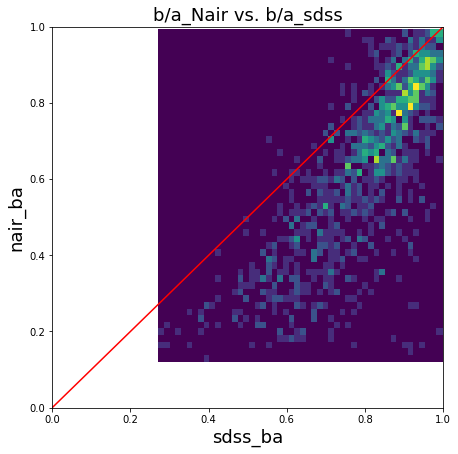

In [115]:
plt.figure(figsize=(7,7))
xx=np.linspace(0,1,10)
plt.plot(xx,xx,color = 'r')
plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
plt.xlabel("sdss_ba",fontsize = 18)
plt.ylabel("nair_ba",fontsize = 18)
plt.title("b/a_Nair vs. b/a_sdss",fontsize = 18)
plt.xlim(0, 1)
plt.ylim(0, 1)


In [133]:
# 找出0.2~1 的星系，找到ra dec，再找到plate-ifu，再读取图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


# 寻找nair_ba and sdss_ba中0.2~1的星系编号
temp_plate = basic['plate']    # 读取plate
temp_ifu = basic['ifudsgn']    # 读取ifu
old_ra = basic['OBJRA']
old_dec = basic['OBJDEC']

sel_image = np.zeros((b_over_a.size,6))
sel_image[:,0] = temp_plate    # 第1列存储plate，源于Manga
sel_image[:,1] = temp_ifu    # 第2列存储ifu，源于Manga
sel_image[:,2] = old_ra    # 第3列存储ra，源于Manga
sel_image[:,3] = old_dec    # 第4列存储dec，源于Manga
sel_image[:,4] = b_over_a    # 第5列存储b/a，源于Manga
# 第6列存储b/a，源于nair catalog
#############################################################

old_ba = b_over_a[tmp_num_ij[:,0]]    #Manga数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[tmp_num_ij[:,1]]    #Nair catalog数据中的b/a
num_sel_np = tmp_num_ij[np.where(new_ba<=1)]    # 最终的数组编号位置
print(num_sel_np.shape)

(1194, 2)


In [170]:
# Hsiang-Chih Hwang1, Jorge K. Barrera-Ballesteros1 2018
# Manga中的金属丰度反常区域是由于吸积所造成的吗？
# 读取NASA-Sloan catalog v1 0 1中的 ra dec b/a数据
# catalog简介：https://www.sdss.org/dr13/manga/manga-target-selection/nsa/
# Catalog参数详细说明：https://data.sdss.org/datamodel/files/ATLAS_DATA/ATLAS_MAJOR_VERSION/nsa.html#hdu0
# 下载地址：https://data.sdss.org/sas/dr13/sdss/atlas/v1/nsa_v1_0_1.fits
# 本地文件路径 /root/cosmos/data/nsa_v1_0_1.fits
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pylab import *
import copy
# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic = nsa101[1].data

# get data and remove the read-only property
nsa_ra = copy.copy(basic['RA'])
nsa_dec = copy.copy(basic['DEC'])
nsa_ra2 = copy.copy(basic['PLUG_RA'])
nsa_dec2 = copy.copy(basic['PLUG_DEC'])
nsa_ba = copy.copy(basic['PETRO_BA90'])

###################################################################
# 寻找ASA-Sloan catalog v1 0 1与Nair & Abraham (2010)中一样的星系##
###################################################################


# 获取ra和dec信息
old_ra = nsa_ra
old_dec = nsa_dec

# read the new data of ra and dec
# 0 = ra, dec = 1, b/a = 2
new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

old_same_gal = np.zeros((old_ra.size,1))
new_same_gal = np.zeros((new_ra_dec[:,0].size,1))
last_same_gal =  np.zeros((old_ra.size,2))-999
delta_radec = 0.001
for i in range(0,old_ra.size):
#for i in range(0,50):
    for j in range(0,new_ra_dec[:,0].size):
        if (old_ra[i]<new_ra_dec[j,0]+delta_radec) and (old_ra[i]>new_ra_dec[j,0]-delta_radec) and (old_dec[i]>new_ra_dec[j,1]-delta_radec) and (old_dec[i]<new_ra_dec[j,1]+delta_radec):
            old_same_gal[i,0] += 1
            new_same_gal[j,0] += 1
            last_same_gal[i,0] = i
            last_same_gal[i,1] = j
            #print("find **** one same *******")
            print("Bingo!  ","i = ",i,"j = ",j)
#            print("finish ",i," galaxies, there're ",old_ra.size-i," remaining")





Bingo!   i =  21 j =  240
Bingo!   i =  73 j =  337
Bingo!   i =  76 j =  336
Bingo!   i =  92 j =  1072
Bingo!   i =  245 j =  465
Bingo!   i =  250 j =  1078
Bingo!   i =  273 j =  466
Bingo!   i =  286 j =  1080
Bingo!   i =  325 j =  468
Bingo!   i =  337 j =  397
Bingo!   i =  350 j =  4382
Bingo!   i =  415 j =  339
Bingo!   i =  499 j =  1067
Bingo!   i =  531 j =  2180
Bingo!   i =  554 j =  398
Bingo!   i =  585 j =  3586
Bingo!   i =  604 j =  1079
Bingo!   i =  626 j =  469
Bingo!   i =  630 j =  4401
Bingo!   i =  638 j =  3587
Bingo!   i =  648 j =  4416
Bingo!   i =  652 j =  470
Bingo!   i =  735 j =  341
Bingo!   i =  747 j =  340
Bingo!   i =  762 j =  241
Bingo!   i =  811 j =  4383
Bingo!   i =  818 j =  4395
Bingo!   i =  915 j =  399
Bingo!   i =  944 j =  4394
Bingo!   i =  999 j =  473
Bingo!   i =  1038 j =  474
Bingo!   i =  1042 j =  4403
Bingo!   i =  1113 j =  342
Bingo!   i =  1216 j =  4396
Bingo!   i =  1293 j =  4404
Bingo!   i =  1313 j =  403
Bingo!   

Bingo!   i =  11156 j =  23
Bingo!   i =  11182 j =  442
Bingo!   i =  11230 j =  180
Bingo!   i =  11371 j =  369
Bingo!   i =  11490 j =  510
Bingo!   i =  11583 j =  511
Bingo!   i =  11594 j =  135
Bingo!   i =  11624 j =  87
Bingo!   i =  11632 j =  278
Bingo!   i =  11656 j =  86
Bingo!   i =  11659 j =  46
Bingo!   i =  11736 j =  134
Bingo!   i =  11797 j =  545
Bingo!   i =  11801 j =  546
Bingo!   i =  11816 j =  136
Bingo!   i =  11823 j =  137
Bingo!   i =  11835 j =  50
Bingo!   i =  11842 j =  283
Bingo!   i =  11856 j =  51
Bingo!   i =  11886 j =  49
Bingo!   i =  11909 j =  24
Bingo!   i =  11910 j =  282
Bingo!   i =  11940 j =  371
Bingo!   i =  11945 j =  323
Bingo!   i =  11951 j =  90
Bingo!   i =  11960 j =  280
Bingo!   i =  11977 j =  89
Bingo!   i =  11986 j =  48
Bingo!   i =  11996 j =  47
Bingo!   i =  12001 j =  322
Bingo!   i =  12010 j =  279
Bingo!   i =  12020 j =  88
Bingo!   i =  12032 j =  226
Bingo!   i =  12036 j =  512
Bingo!   i =  12133 j =  22

Bingo!   i =  21007 j =  2
Bingo!   i =  21022 j =  4
Bingo!   i =  21047 j =  3
Bingo!   i =  21058 j =  201
Bingo!   i =  21086 j =  202
Bingo!   i =  21196 j =  0
Bingo!   i =  22219 j =  1250
Bingo!   i =  22249 j =  1211
Bingo!   i =  22341 j =  1252
Bingo!   i =  22383 j =  1217
Bingo!   i =  22410 j =  1210
Bingo!   i =  22413 j =  1259
Bingo!   i =  22440 j =  1273
Bingo!   i =  22447 j =  1246
Bingo!   i =  22448 j =  1279
Bingo!   i =  22459 j =  1628
Bingo!   i =  22540 j =  1709
Bingo!   i =  22558 j =  1691
Bingo!   i =  22563 j =  1708
Bingo!   i =  22662 j =  1278
Bingo!   i =  22694 j =  1683
Bingo!   i =  22704 j =  1689
Bingo!   i =  22761 j =  1730
Bingo!   i =  23023 j =  1280
Bingo!   i =  23081 j =  1713
Bingo!   i =  23109 j =  1711
Bingo!   i =  23110 j =  1712
Bingo!   i =  23114 j =  1694
Bingo!   i =  23115 j =  1693
Bingo!   i =  23121 j =  1684
Bingo!   i =  23156 j =  1281
Bingo!   i =  23204 j =  1641
Bingo!   i =  23226 j =  1690
Bingo!   i =  23236 j = 

Bingo!   i =  28870 j =  10035
Bingo!   i =  28886 j =  6350
Bingo!   i =  28888 j =  6325
Bingo!   i =  28912 j =  6389
Bingo!   i =  28913 j =  10037
Bingo!   i =  28915 j =  10038
Bingo!   i =  28917 j =  10036
Bingo!   i =  29043 j =  6224
Bingo!   i =  29044 j =  6225
Bingo!   i =  29065 j =  6223
Bingo!   i =  29123 j =  10039
Bingo!   i =  29137 j =  9974
Bingo!   i =  29159 j =  6351
Bingo!   i =  29160 j =  6390
Bingo!   i =  29204 j =  9932
Bingo!   i =  29206 j =  9931
Bingo!   i =  29216 j =  6258
Bingo!   i =  29245 j =  6257
Bingo!   i =  29246 j =  9718
Bingo!   i =  29248 j =  6228
Bingo!   i =  29289 j =  6256
Bingo!   i =  29305 j =  6255
Bingo!   i =  29310 j =  6254
Bingo!   i =  29311 j =  9863
Bingo!   i =  29319 j =  6227
Bingo!   i =  29345 j =  6289
Bingo!   i =  29372 j =  6327
Bingo!   i =  29401 j =  10040
Bingo!   i =  29409 j =  10041
Bingo!   i =  29492 j =  6392
Bingo!   i =  29496 j =  6329
Bingo!   i =  29512 j =  6261
Bingo!   i =  29535 j =  9788
Bin

Bingo!   i =  34271 j =  9996
Bingo!   i =  34320 j =  6530
Bingo!   i =  34325 j =  9893
Bingo!   i =  34330 j =  6479
Bingo!   i =  34335 j =  6480
Bingo!   i =  34364 j =  9956
Bingo!   i =  34394 j =  9749
Bingo!   i =  34405 j =  6478
Bingo!   i =  34415 j =  9817
Bingo!   i =  34426 j =  9816
Bingo!   i =  34509 j =  10057
Bingo!   i =  34578 j =  10058
Bingo!   i =  34586 j =  6678
Bingo!   i =  34598 j =  6716
Bingo!   i =  34601 j =  10059
Bingo!   i =  34664 j =  6481
Bingo!   i =  34722 j =  9894
Bingo!   i =  34726 j =  6531
Bingo!   i =  34748 j =  6591
Bingo!   i =  34758 j =  6588
Bingo!   i =  34765 j =  6589
Bingo!   i =  34780 j =  6679
Bingo!   i =  34839 j =  6636
Bingo!   i =  34876 j =  6680
Bingo!   i =  34944 j =  6593
Bingo!   i =  34968 j =  9752
Bingo!   i =  34985 j =  9751
Bingo!   i =  35024 j =  9750
Bingo!   i =  35032 j =  6482
Bingo!   i =  35054 j =  9820
Bingo!   i =  35078 j =  9819
Bingo!   i =  35092 j =  9895
Bingo!   i =  35142 j =  6717
Bingo! 

Bingo!   i =  38267 j =  9923
Bingo!   i =  38272 j =  9778
Bingo!   i =  38293 j =  9857
Bingo!   i =  38299 j =  9858
Bingo!   i =  38309 j =  9856
Bingo!   i =  38313 j =  9855
Bingo!   i =  38322 j =  6561
Bingo!   i =  38328 j =  6560
Bingo!   i =  38335 j =  9854
Bingo!   i =  38347 j =  6622
Bingo!   i =  38348 j =  6558
Bingo!   i =  38351 j =  6559
Bingo!   i =  38378 j =  6557
Bingo!   i =  38381 j =  9777
Bingo!   i =  38398 j =  6619
Bingo!   i =  38428 j =  9968
Bingo!   i =  38435 j =  6701
Bingo!   i =  38437 j =  6700
Bingo!   i =  38441 j =  9969
Bingo!   i =  38463 j =  6662
Bingo!   i =  38470 j =  9970
Bingo!   i =  38475 j =  9971
Bingo!   i =  38486 j =  10084
Bingo!   i =  38495 j =  10028
Bingo!   i =  38506 j =  6703
Bingo!   i =  38509 j =  10027
Bingo!   i =  38511 j =  6663
Bingo!   i =  38521 j =  9783
Bingo!   i =  38543 j =  6563
Bingo!   i =  38545 j =  6564
Bingo!   i =  38550 j =  9780
Bingo!   i =  38552 j =  9782
Bingo!   i =  38553 j =  6516
Bingo! 

Bingo!   i =  43610 j =  1083
Bingo!   i =  43651 j =  1739
Bingo!   i =  43654 j =  1507
Bingo!   i =  43656 j =  1752
Bingo!   i =  43672 j =  1549
Bingo!   i =  43718 j =  1762
Bingo!   i =  43723 j =  1763
Bingo!   i =  43724 j =  1764
Bingo!   i =  43733 j =  1766
Bingo!   i =  43741 j =  1767
Bingo!   i =  43754 j =  1765
Bingo!   i =  43763 j =  1582
Bingo!   i =  43773 j =  1550
Bingo!   i =  43783 j =  1753
Bingo!   i =  43784 j =  1508
Bingo!   i =  43830 j =  1085
Bingo!   i =  43834 j =  1287
Bingo!   i =  43864 j =  1099
Bingo!   i =  43865 j =  1084
Bingo!   i =  43878 j =  1100
Bingo!   i =  43906 j =  1148
Bingo!   i =  43909 j =  1392
Bingo!   i =  43962 j =  1149
Bingo!   i =  43996 j =  1346
Bingo!   i =  44001 j =  1345
Bingo!   i =  44007 j =  1119
Bingo!   i =  44014 j =  1101
Bingo!   i =  44031 j =  1120
Bingo!   i =  44034 j =  1347
Bingo!   i =  44100 j =  1510
Bingo!   i =  44101 j =  1511
Bingo!   i =  44108 j =  1741
Bingo!   i =  44109 j =  1471
Bingo!   i

Bingo!   i =  49567 j =  1185
Bingo!   i =  49650 j =  784
Bingo!   i =  49743 j =  818
Bingo!   i =  49754 j =  2799
Bingo!   i =  49758 j =  817
Bingo!   i =  49799 j =  816
Bingo!   i =  49840 j =  855
Bingo!   i =  49903 j =  819
Bingo!   i =  49908 j =  856
Bingo!   i =  49926 j =  838
Bingo!   i =  49941 j =  2803
Bingo!   i =  49965 j =  2802
Bingo!   i =  49968 j =  802
Bingo!   i =  49972 j =  2850
Bingo!   i =  49973 j =  2851
Bingo!   i =  49977 j =  2852
Bingo!   i =  49979 j =  785
Bingo!   i =  49984 j =  786
Bingo!   i =  49985 j =  2800
Bingo!   i =  50012 j =  2849
Bingo!   i =  50015 j =  820
Bingo!   i =  50019 j =  2801
Bingo!   i =  50094 j =  2947
Bingo!   i =  50104 j =  857
Bingo!   i =  50126 j =  2897
Bingo!   i =  50128 j =  2896
Bingo!   i =  50132 j =  2991
Bingo!   i =  50135 j =  2992
Bingo!   i =  50147 j =  867
Bingo!   i =  50150 j =  2993
Bingo!   i =  50155 j =  839
Bingo!   i =  50172 j =  789
Bingo!   i =  50201 j =  2763
Bingo!   i =  50206 j =  2

Bingo!   i =  54829 j =  395
Bingo!   i =  54854 j =  2178
Bingo!   i =  54893 j =  3600
Bingo!   i =  54894 j =  3601
Bingo!   i =  54950 j =  2176
Bingo!   i =  54968 j =  2175
Bingo!   i =  54982 j =  3640
Bingo!   i =  54993 j =  2421
Bingo!   i =  55021 j =  3626
Bingo!   i =  55048 j =  2422
Bingo!   i =  55063 j =  2423
Bingo!   i =  55093 j =  2353
Bingo!   i =  55174 j =  2352
Bingo!   i =  55182 j =  3613
Bingo!   i =  55214 j =  2424
Bingo!   i =  55271 j =  2354
Bingo!   i =  55307 j =  3627
Bingo!   i =  55309 j =  2356
Bingo!   i =  55352 j =  2247
Bingo!   i =  55371 j =  2246
Bingo!   i =  55385 j =  2245
Bingo!   i =  55399 j =  2244
Bingo!   i =  55436 j =  2357
Bingo!   i =  55449 j =  2358
Bingo!   i =  55472 j =  3614
Bingo!   i =  55482 j =  3628
Bingo!   i =  55529 j =  1907
Bingo!   i =  55534 j =  1908
Bingo!   i =  55572 j =  1920
Bingo!   i =  55574 j =  1618
Bingo!   i =  55601 j =  1932
Bingo!   i =  55616 j =  1933
Bingo!   i =  55636 j =  1934
Bingo!   i 

Bingo!   i =  63862 j =  2154
Bingo!   i =  63866 j =  2004
Bingo!   i =  64051 j =  2320
Bingo!   i =  64162 j =  2157
Bingo!   i =  64168 j =  1980
Bingo!   i =  64181 j =  2213
Bingo!   i =  64192 j =  2045
Bingo!   i =  64197 j =  2155
Bingo!   i =  64201 j =  2156
Bingo!   i =  64207 j =  1979
Bingo!   i =  64211 j =  2209
Bingo!   i =  64212 j =  2212
Bingo!   i =  64215 j =  2208
Bingo!   i =  64218 j =  2011
Bingo!   i =  64226 j =  1978
Bingo!   i =  64231 j =  2211
Bingo!   i =  64239 j =  2207
Bingo!   i =  64293 j =  2044
Bingo!   i =  64294 j =  2043
Bingo!   i =  64330 j =  2322
Bingo!   i =  64372 j =  2080
Bingo!   i =  64529 j =  2265
Bingo!   i =  64694 j =  2096
Bingo!   i =  64700 j =  2129
Bingo!   i =  64723 j =  2323
Bingo!   i =  64752 j =  2389
Bingo!   i =  64755 j =  2390
Bingo!   i =  64826 j =  2012
Bingo!   i =  64837 j =  2159
Bingo!   i =  64845 j =  1981
Bingo!   i =  64974 j =  2391
Bingo!   i =  64976 j =  2097
Bingo!   i =  65014 j =  2392
Bingo!   i

Bingo!   i =  71801 j =  3395
Bingo!   i =  71872 j =  3825
Bingo!   i =  71891 j =  3827
Bingo!   i =  71937 j =  3850
Bingo!   i =  71939 j =  3849
Bingo!   i =  71953 j =  3848
Bingo!   i =  71974 j =  3851
Bingo!   i =  71986 j =  3852
Bingo!   i =  72004 j =  3414
Bingo!   i =  72029 j =  3839
Bingo!   i =  72056 j =  3828
Bingo!   i =  72133 j =  3814
Bingo!   i =  72147 j =  3392
Bingo!   i =  72166 j =  3391
Bingo!   i =  72183 j =  3398
Bingo!   i =  72188 j =  3399
Bingo!   i =  72199 j =  3831
Bingo!   i =  72207 j =  3830
Bingo!   i =  72210 j =  3404
Bingo!   i =  72212 j =  3829
Bingo!   i =  72241 j =  3397
Bingo!   i =  72275 j =  3415
Bingo!   i =  72303 j =  3840
Bingo!   i =  72307 j =  3416
Bingo!   i =  72325 j =  3841
Bingo!   i =  72327 j =  3842
Bingo!   i =  72350 j =  3405
Bingo!   i =  72393 j =  3393
Bingo!   i =  72400 j =  3832
Bingo!   i =  72416 j =  3815
Bingo!   i =  72476 j =  3808
Bingo!   i =  72559 j =  3843
Bingo!   i =  72562 j =  3809
Bingo!   i

Bingo!   i =  78834 j =  4015
Bingo!   i =  78839 j =  4151
Bingo!   i =  78858 j =  4152
Bingo!   i =  78868 j =  4111
Bingo!   i =  78873 j =  4188
Bingo!   i =  78876 j =  4016
Bingo!   i =  78880 j =  4017
Bingo!   i =  78943 j =  4070
Bingo!   i =  78949 j =  3919
Bingo!   i =  78958 j =  3918
Bingo!   i =  79040 j =  4189
Bingo!   i =  79052 j =  4190
Bingo!   i =  79145 j =  2430
Bingo!   i =  79189 j =  4072
Bingo!   i =  79236 j =  3947
Bingo!   i =  79265 j =  4032
Bingo!   i =  79311 j =  3972
Bingo!   i =  79331 j =  4154
Bingo!   i =  79334 j =  4153
Bingo!   i =  79335 j =  4112
Bingo!   i =  79345 j =  4155
Bingo!   i =  79383 j =  4114
Bingo!   i =  79397 j =  3973
Bingo!   i =  79484 j =  3921
Bingo!   i =  79489 j =  3950
Bingo!   i =  79496 j =  4074
Bingo!   i =  79500 j =  3949
Bingo!   i =  79512 j =  3948
Bingo!   i =  79593 j =  4073
Bingo!   i =  79596 j =  4113
Bingo!   i =  79606 j =  4202
Bingo!   i =  79612 j =  4203
Bingo!   i =  79646 j =  4191
Bingo!   i

Bingo!   i =  83914 j =  4475
Bingo!   i =  83930 j =  4528
Bingo!   i =  83991 j =  2606
Bingo!   i =  84018 j =  2590
Bingo!   i =  84025 j =  4647
Bingo!   i =  84027 j =  4646
Bingo!   i =  84121 j =  2591
Bingo!   i =  84134 j =  4648
Bingo!   i =  84136 j =  4650
Bingo!   i =  84139 j =  4651
Bingo!   i =  84142 j =  4649
Bingo!   i =  84152 j =  4615
Bingo!   i =  84184 j =  2561
Bingo!   i =  84195 j =  4533
Bingo!   i =  84256 j =  2538
Bingo!   i =  84257 j =  2560
Bingo!   i =  84284 j =  4532
Bingo!   i =  84297 j =  4531
Bingo!   i =  84335 j =  4529
Bingo!   i =  84353 j =  2592
Bingo!   i =  84375 j =  4616
Bingo!   i =  84399 j =  4617
Bingo!   i =  84429 j =  2593
Bingo!   i =  84430 j =  4652
Bingo!   i =  84437 j =  4618
Bingo!   i =  84442 j =  2594
Bingo!   i =  84459 j =  2595
Bingo!   i =  84462 j =  4619
Bingo!   i =  84509 j =  4654
Bingo!   i =  84511 j =  4653
Bingo!   i =  84569 j =  2608
Bingo!   i =  84647 j =  2540
Bingo!   i =  84657 j =  2539
Bingo!   i

Bingo!   i =  92550 j =  1381
Bingo!   i =  92552 j =  5164
Bingo!   i =  92561 j =  5147
Bingo!   i =  92587 j =  5128
Bingo!   i =  92622 j =  1340
Bingo!   i =  92626 j =  5127
Bingo!   i =  92661 j =  1307
Bingo!   i =  92664 j =  1336
Bingo!   i =  92665 j =  5146
Bingo!   i =  92667 j =  5126
Bingo!   i =  92670 j =  1335
Bingo!   i =  92675 j =  1339
Bingo!   i =  92679 j =  1338
Bingo!   i =  92684 j =  1377
Bingo!   i =  92687 j =  1378
Bingo!   i =  92706 j =  1380
Bingo!   i =  92707 j =  1379
Bingo!   i =  92718 j =  5163
Bingo!   i =  92749 j =  1415
Bingo!   i =  92763 j =  5183
Bingo!   i =  92777 j =  1436
Bingo!   i =  92782 j =  5220
Bingo!   i =  92856 j =  1892
Bingo!   i =  92863 j =  1891
Bingo!   i =  92866 j =  4677
Bingo!   i =  92902 j =  1838
Bingo!   i =  92908 j =  1836
Bingo!   i =  92916 j =  1834
Bingo!   i =  92937 j =  5219
Bingo!   i =  92956 j =  5216
Bingo!   i =  92957 j =  5217
Bingo!   i =  92987 j =  1817
Bingo!   i =  93082 j =  4703
Bingo!   i

Bingo!   i =  99395 j =  2739
Bingo!   i =  99541 j =  3425
Bingo!   i =  99553 j =  3426
Bingo!   i =  99588 j =  3428
Bingo!   i =  99630 j =  3420
Bingo!   i =  99647 j =  3423
Bingo!   i =  99659 j =  2817
Bingo!   i =  99728 j =  3431
Bingo!   i =  99746 j =  3422
Bingo!   i =  99833 j =  3429
Bingo!   i =  99852 j =  2742
Bingo!   i =  99853 j =  2741
Bingo!   i =  99875 j =  2818
Bingo!   i =  100121 j =  2919
Bingo!   i =  100139 j =  2962
Bingo!   i =  100163 j =  3301
Bingo!   i =  100177 j =  2777
Bingo!   i =  100182 j =  3212
Bingo!   i =  100195 j =  2776
Bingo!   i =  100219 j =  2819
Bingo!   i =  100326 j =  3258
Bingo!   i =  100336 j =  3257
Bingo!   i =  100436 j =  3242
Bingo!   i =  100448 j =  2963
Bingo!   i =  100523 j =  3213
Bingo!   i =  100725 j =  3216
Bingo!   i =  100746 j =  2744
Bingo!   i =  100779 j =  3215
Bingo!   i =  100853 j =  2778
Bingo!   i =  100871 j =  3214
Bingo!   i =  100885 j =  3259
Bingo!   i =  100906 j =  2872
Bingo!   i =  100932 

Bingo!   i =  105529 j =  2988
Bingo!   i =  105533 j =  2987
Bingo!   i =  105538 j =  3435
Bingo!   i =  105559 j =  3436
Bingo!   i =  105566 j =  3439
Bingo!   i =  105577 j =  3437
Bingo!   i =  105599 j =  2760
Bingo!   i =  105668 j =  2845
Bingo!   i =  105686 j =  2758
Bingo!   i =  105721 j =  3433
Bingo!   i =  105756 j =  3379
Bingo!   i =  105764 j =  2894
Bingo!   i =  105765 j =  3381
Bingo!   i =  105771 j =  3377
Bingo!   i =  105774 j =  3380
Bingo!   i =  105790 j =  3382
Bingo!   i =  105793 j =  3375
Bingo!   i =  105814 j =  3374
Bingo!   i =  105853 j =  3384
Bingo!   i =  105855 j =  3385
Bingo!   i =  105874 j =  2797
Bingo!   i =  105878 j =  2798
Bingo!   i =  105912 j =  2848
Bingo!   i =  105938 j =  3373
Bingo!   i =  105948 j =  3372
Bingo!   i =  105958 j =  2761
Bingo!   i =  105962 j =  2847
Bingo!   i =  105977 j =  2846
Bingo!   i =  106006 j =  3386
Bingo!   i =  106026 j =  3378
Bingo!   i =  106034 j =  2989
Bingo!   i =  106065 j =  3376
Bingo!  

Bingo!   i =  115345 j =  6004
Bingo!   i =  115357 j =  3186
Bingo!   i =  115358 j =  3121
Bingo!   i =  115365 j =  6005
Bingo!   i =  115372 j =  6008
Bingo!   i =  115377 j =  3188
Bingo!   i =  115380 j =  3151
Bingo!   i =  115381 j =  6007
Bingo!   i =  115386 j =  6009
Bingo!   i =  115394 j =  6010
Bingo!   i =  115397 j =  3189
Bingo!   i =  115418 j =  3152
Bingo!   i =  115427 j =  3122
Bingo!   i =  115437 j =  5979
Bingo!   i =  115540 j =  5867
Bingo!   i =  115560 j =  5921
Bingo!   i =  115638 j =  3190
Bingo!   i =  115650 j =  5948
Bingo!   i =  115934 j =  5868
Bingo!   i =  116035 j =  5980
Bingo!   i =  116170 j =  5869
Bingo!   i =  116198 j =  5922
Bingo!   i =  116211 j =  3070
Bingo!   i =  116283 j =  3097
Bingo!   i =  116299 j =  3153
Bingo!   i =  116316 j =  3154
Bingo!   i =  116383 j =  3124
Bingo!   i =  116555 j =  5949
Bingo!   i =  116661 j =  6012
Bingo!   i =  116706 j =  3047
Bingo!   i =  116725 j =  5873
Bingo!   i =  116728 j =  5897
Bingo!  

Bingo!   i =  122002 j =  4241
Bingo!   i =  122006 j =  4323
Bingo!   i =  122038 j =  4248
Bingo!   i =  122069 j =  4249
Bingo!   i =  122087 j =  4351
Bingo!   i =  122126 j =  4324
Bingo!   i =  122138 j =  4234
Bingo!   i =  122141 j =  4290
Bingo!   i =  122155 j =  4326
Bingo!   i =  122206 j =  4236
Bingo!   i =  122227 j =  4312
Bingo!   i =  122246 j =  4235
Bingo!   i =  122250 j =  4327
Bingo!   i =  122262 j =  4328
Bingo!   i =  122276 j =  4325
Bingo!   i =  122279 j =  4253
Bingo!   i =  122284 j =  4252
Bingo!   i =  122300 j =  4251
Bingo!   i =  122304 j =  4250
Bingo!   i =  122340 j =  4353
Bingo!   i =  122400 j =  4243
Bingo!   i =  122465 j =  4786
Bingo!   i =  122518 j =  4850
Bingo!   i =  122531 j =  4851
Bingo!   i =  122611 j =  3826
Bingo!   i =  122623 j =  4938
Bingo!   i =  122626 j =  4889
Bingo!   i =  122645 j =  4354
Bingo!   i =  122671 j =  4852
Bingo!   i =  122704 j =  4853
Bingo!   i =  122707 j =  4329
Bingo!   i =  122711 j =  4330
Bingo!  

Bingo!   i =  128752 j =  5333
Bingo!   i =  128792 j =  5334
Bingo!   i =  128822 j =  5284
Bingo!   i =  128891 j =  5456
Bingo!   i =  128911 j =  5473
Bingo!   i =  128932 j =  5350
Bingo!   i =  129029 j =  5530
Bingo!   i =  129075 j =  5285
Bingo!   i =  129094 j =  5317
Bingo!   i =  129274 j =  5508
Bingo!   i =  129287 j =  5366
Bingo!   i =  129293 j =  5335
Bingo!   i =  129308 j =  5510
Bingo!   i =  129327 j =  5511
Bingo!   i =  129330 j =  5352
Bingo!   i =  129368 j =  5531
Bingo!   i =  129375 j =  5532
Bingo!   i =  129392 j =  5286
Bingo!   i =  129406 j =  5339
Bingo!   i =  129460 j =  5318
Bingo!   i =  129493 j =  5464
Bingo!   i =  129504 j =  5305
Bingo!   i =  129529 j =  5336
Bingo!   i =  129549 j =  5337
Bingo!   i =  129573 j =  5338
Bingo!   i =  129596 j =  5513
Bingo!   i =  129602 j =  5512
Bingo!   i =  129603 j =  5514
Bingo!   i =  129609 j =  5533
Bingo!   i =  129616 j =  5353
Bingo!   i =  129623 j =  5367
Bingo!   i =  129675 j =  5340
Bingo!  

Bingo!   i =  136819 j =  6761
Bingo!   i =  136908 j =  6762
Bingo!   i =  136926 j =  6784
Bingo!   i =  136957 j =  6911
Bingo!   i =  136977 j =  6821
Bingo!   i =  136981 j =  6820
Bingo!   i =  136990 j =  6822
Bingo!   i =  137007 j =  6823
Bingo!   i =  137012 j =  6804
Bingo!   i =  137053 j =  6884
Bingo!   i =  137056 j =  6854
Bingo!   i =  137058 j =  6853
Bingo!   i =  137082 j =  6866
Bingo!   i =  137114 j =  6785
Bingo!   i =  137136 j =  6885
Bingo!   i =  137160 j =  6865
Bingo!   i =  137166 j =  6824
Bingo!   i =  137181 j =  6834
Bingo!   i =  137189 j =  6835
Bingo!   i =  137190 j =  6833
Bingo!   i =  137200 j =  6836
Bingo!   i =  137210 j =  6838
Bingo!   i =  137225 j =  6837
Bingo!   i =  137280 j =  6786
Bingo!   i =  137320 j =  6763
Bingo!   i =  137324 j =  6855
Bingo!   i =  137326 j =  6764
Bingo!   i =  137334 j =  6766
Bingo!   i =  137345 j =  6765
Bingo!   i =  137360 j =  6787
Bingo!   i =  137372 j =  6805
Bingo!   i =  137392 j =  6903
Bingo!  

Bingo!   i =  143781 j =  4628
Bingo!   i =  143881 j =  5116
Bingo!   i =  143908 j =  4629
Bingo!   i =  143921 j =  4630
Bingo!   i =  144000 j =  5036
Bingo!   i =  144002 j =  5037
Bingo!   i =  144040 j =  5117
Bingo!   i =  144069 j =  5090
Bingo!   i =  144108 j =  5091
Bingo!   i =  144140 j =  4590
Bingo!   i =  144191 j =  5005
Bingo!   i =  144192 j =  5004
Bingo!   i =  144203 j =  4548
Bingo!   i =  144216 j =  4484
Bingo!   i =  144232 j =  4483
Bingo!   i =  144239 j =  4982
Bingo!   i =  144264 j =  4981
Bingo!   i =  144265 j =  4980
Bingo!   i =  144294 j =  4631
Bingo!   i =  144298 j =  5062
Bingo!   i =  144299 j =  5063
Bingo!   i =  144334 j =  4591
Bingo!   i =  144337 j =  5065
Bingo!   i =  144359 j =  5066
Bingo!   i =  144371 j =  5092
Bingo!   i =  144376 j =  5067
Bingo!   i =  144415 j =  4595
Bingo!   i =  144416 j =  4594
Bingo!   i =  144417 j =  5093
Bingo!   i =  144421 j =  4593
Bingo!   i =  144422 j =  4596
Bingo!   i =  144443 j =  5040
Bingo!  

Bingo!   i =  149882 j =  7698
Bingo!   i =  149887 j =  7725
Bingo!   i =  149894 j =  7475
Bingo!   i =  149896 j =  7476
Bingo!   i =  149946 j =  7770
Bingo!   i =  149969 j =  7751
Bingo!   i =  150005 j =  7477
Bingo!   i =  150029 j =  7771
Bingo!   i =  150034 j =  7441
Bingo!   i =  150038 j =  7752
Bingo!   i =  150063 j =  7409
Bingo!   i =  150069 j =  7442
Bingo!   i =  150073 j =  7753
Bingo!   i =  150120 j =  7331
Bingo!   i =  150183 j =  7368
Bingo!   i =  150245 j =  7286
Bingo!   i =  150259 j =  7726
Bingo!   i =  150304 j =  7440
Bingo!   i =  150365 j =  7443
Bingo!   i =  150370 j =  7785
Bingo!   i =  150371 j =  7772
Bingo!   i =  150397 j =  7754
Bingo!   i =  150408 j =  7445
Bingo!   i =  150423 j =  7786
Bingo!   i =  150447 j =  7411
Bingo!   i =  150463 j =  7478
Bingo!   i =  150472 j =  7410
Bingo!   i =  150491 j =  7756
Bingo!   i =  150544 j =  7369
Bingo!   i =  150586 j =  7332
Bingo!   i =  150685 j =  7699
Bingo!   i =  150701 j =  7773
Bingo!  

Bingo!   i =  155343 j =  7127
Bingo!   i =  155368 j =  7147
Bingo!   i =  155371 j =  7145
Bingo!   i =  155384 j =  7176
Bingo!   i =  155392 j =  7564
Bingo!   i =  155397 j =  7177
Bingo!   i =  155411 j =  7566
Bingo!   i =  155447 j =  7568
Bingo!   i =  155450 j =  7534
Bingo!   i =  155456 j =  7533
Bingo!   i =  155463 j =  7128
Bingo!   i =  155479 j =  7520
Bingo!   i =  155497 j =  7509
Bingo!   i =  155523 j =  7111
Bingo!   i =  155528 j =  7489
Bingo!   i =  155538 j =  7521
Bingo!   i =  155551 j =  7535
Bingo!   i =  155573 j =  7532
Bingo!   i =  155609 j =  7567
Bingo!   i =  155615 j =  7570
Bingo!   i =  155650 j =  7551
Bingo!   i =  155658 j =  7496
Bingo!   i =  155662 j =  7497
Bingo!   i =  155670 j =  7498
Bingo!   i =  155695 j =  7552
Bingo!   i =  155726 j =  7510
Bingo!   i =  155736 j =  7511
Bingo!   i =  155738 j =  7512
Bingo!   i =  155756 j =  7487
Bingo!   i =  155757 j =  7486
Bingo!   i =  155764 j =  7488
Bingo!   i =  155775 j =  7522
Bingo!  

Bingo!   i =  161439 j =  5727
Bingo!   i =  161463 j =  5810
Bingo!   i =  161475 j =  5726
Bingo!   i =  161531 j =  5725
Bingo!   i =  161537 j =  5698
Bingo!   i =  161552 j =  5832
Bingo!   i =  161553 j =  5860
Bingo!   i =  161596 j =  5780
Bingo!   i =  161636 j =  5834
Bingo!   i =  161711 j =  5818
Bingo!   i =  161713 j =  5728
Bingo!   i =  161718 j =  5699
Bingo!   i =  161722 j =  5712
Bingo!   i =  161739 j =  5812
Bingo!   i =  161764 j =  5817
Bingo!   i =  161789 j =  5811
Bingo!   i =  161886 j =  5752
Bingo!   i =  161887 j =  5751
Bingo!   i =  161908 j =  5835
Bingo!   i =  161910 j =  5854
Bingo!   i =  161949 j =  5729
Bingo!   i =  161953 j =  5820
Bingo!   i =  161994 j =  5819
Bingo!   i =  162042 j =  5753
Bingo!   i =  162082 j =  5754
Bingo!   i =  162093 j =  5836
Bingo!   i =  162129 j =  5824
Bingo!   i =  162188 j =  5823
Bingo!   i =  162212 j =  5813
Bingo!   i =  162223 j =  5821
Bingo!   i =  162224 j =  5822
Bingo!   i =  162265 j =  5837
Bingo!  

Bingo!   i =  167823 j =  8312
Bingo!   i =  167965 j =  8333
Bingo!   i =  167996 j =  8334
Bingo!   i =  167998 j =  4829
Bingo!   i =  168048 j =  4770
Bingo!   i =  168081 j =  4830
Bingo!   i =  168107 j =  8342
Bingo!   i =  168137 j =  8341
Bingo!   i =  168164 j =  4908
Bingo!   i =  168224 j =  8354
Bingo!   i =  168242 j =  4909
Bingo!   i =  168246 j =  4873
Bingo!   i =  168267 j =  4874
Bingo!   i =  168297 j =  4911
Bingo!   i =  168299 j =  4910
Bingo!   i =  168306 j =  8335
Bingo!   i =  168321 j =  4806
Bingo!   i =  168359 j =  4831
Bingo!   i =  168368 j =  4805
Bingo!   i =  168415 j =  8315
Bingo!   i =  168436 j =  8329
Bingo!   i =  168455 j =  4950
Bingo!   i =  168457 j =  4949
Bingo!   i =  168462 j =  8355
Bingo!   i =  168476 j =  8356
Bingo!   i =  168505 j =  4913
Bingo!   i =  168509 j =  4914
Bingo!   i =  168519 j =  8344
Bingo!   i =  168550 j =  4951
Bingo!   i =  168591 j =  4775
Bingo!   i =  168593 j =  4773
Bingo!   i =  168609 j =  4771
Bingo!  

Bingo!   i =  174632 j =  8081
Bingo!   i =  174638 j =  8031
Bingo!   i =  174641 j =  8138
Bingo!   i =  174647 j =  8034
Bingo!   i =  174652 j =  8033
Bingo!   i =  174682 j =  7938
Bingo!   i =  174759 j =  8797
Bingo!   i =  174781 j =  7982
Bingo!   i =  174794 j =  7937
Bingo!   i =  174803 j =  8795
Bingo!   i =  174825 j =  8032
Bingo!   i =  174829 j =  8792
Bingo!   i =  174842 j =  8774
Bingo!   i =  174849 j =  7980
Bingo!   i =  174854 j =  8791
Bingo!   i =  174945 j =  8809
Bingo!   i =  174947 j =  8810
Bingo!   i =  174951 j =  8035
Bingo!   i =  174959 j =  8842
Bingo!   i =  174987 j =  8811
Bingo!   i =  175020 j =  7941
Bingo!   i =  175050 j =  7940
Bingo!   i =  175052 j =  8762
Bingo!   i =  175053 j =  8761
Bingo!   i =  175058 j =  7985
Bingo!   i =  175128 j =  7939
Bingo!   i =  175137 j =  8776
Bingo!   i =  175169 j =  8139
Bingo!   i =  175184 j =  8141
Bingo!   i =  175191 j =  8144
Bingo!   i =  175209 j =  8145
Bingo!   i =  175227 j =  8146
Bingo!  

Bingo!   i =  180382 j =  6309
Bingo!   i =  180433 j =  6247
Bingo!   i =  180549 j =  6370
Bingo!   i =  180621 j =  6165
Bingo!   i =  180632 j =  6371
Bingo!   i =  180657 j =  6173
Bingo!   i =  180749 j =  6136
Bingo!   i =  180813 j =  6248
Bingo!   i =  181017 j =  8478
Bingo!   i =  181028 j =  8477
Bingo!   i =  181049 j =  8220
Bingo!   i =  181137 j =  8240
Bingo!   i =  181141 j =  8527
Bingo!   i =  181144 j =  8528
Bingo!   i =  181146 j =  8294
Bingo!   i =  181147 j =  8529
Bingo!   i =  181160 j =  8271
Bingo!   i =  181172 j =  8517
Bingo!   i =  181209 j =  8518
Bingo!   i =  181294 j =  8447
Bingo!   i =  181324 j =  8446
Bingo!   i =  181329 j =  8479
Bingo!   i =  181420 j =  8480
Bingo!   i =  181486 j =  8481
Bingo!   i =  181589 j =  8448
Bingo!   i =  181609 j =  8295
Bingo!   i =  181633 j =  8530
Bingo!   i =  181637 j =  8531
Bingo!   i =  181677 j =  8274
Bingo!   i =  181687 j =  8276
Bingo!   i =  181700 j =  8275
Bingo!   i =  181724 j =  8277
Bingo!  

Bingo!   i =  188058 j =  7017
Bingo!   i =  188061 j =  8955
Bingo!   i =  188075 j =  8959
Bingo!   i =  188094 j =  8992
Bingo!   i =  188110 j =  6995
Bingo!   i =  188113 j =  6993
Bingo!   i =  188116 j =  8960
Bingo!   i =  188139 j =  8962
Bingo!   i =  188140 j =  6996
Bingo!   i =  188159 j =  8934
Bingo!   i =  188163 j =  8932
Bingo!   i =  188165 j =  8933
Bingo!   i =  188177 j =  6936
Bingo!   i =  188291 j =  8909
Bingo!   i =  188303 j =  8876
Bingo!   i =  188327 j =  6975
Bingo!   i =  188330 j =  6952
Bingo!   i =  188380 j =  8989
Bingo!   i =  188416 j =  8990
Bingo!   i =  188425 j =  7018
Bingo!   i =  188449 j =  8961
Bingo!   i =  188450 j =  8958
Bingo!   i =  188461 j =  6994
Bingo!   i =  188479 j =  7020
Bingo!   i =  188509 j =  6998
Bingo!   i =  188531 j =  7000
Bingo!   i =  188572 j =  8935
Bingo!   i =  188583 j =  8860
Bingo!   i =  188584 j =  6954
Bingo!   i =  188598 j =  8859
Bingo!   i =  188606 j =  6938
Bingo!   i =  188623 j =  8858
Bingo!  

Bingo!   i =  198664 j =  9070
Bingo!   i =  198672 j =  9046
Bingo!   i =  198741 j =  9071
Bingo!   i =  198747 j =  9243
Bingo!   i =  198751 j =  9205
Bingo!   i =  198790 j =  9244
Bingo!   i =  198831 j =  9115
Bingo!   i =  198911 j =  9074
Bingo!   i =  198949 j =  9052
Bingo!   i =  198983 j =  9113
Bingo!   i =  199025 j =  9073
Bingo!   i =  199052 j =  9206
Bingo!   i =  199059 j =  9138
Bingo!   i =  199067 j =  9139
Bingo!   i =  199071 j =  9099
Bingo!   i =  199073 j =  9207
Bingo!   i =  199189 j =  9076
Bingo!   i =  199246 j =  9168
Bingo!   i =  199273 j =  9167
Bingo!   i =  199276 j =  9166
Bingo!   i =  199277 j =  9053
Bingo!   i =  199286 j =  9165
Bingo!   i =  199287 j =  9162
Bingo!   i =  199288 j =  9163
Bingo!   i =  199290 j =  9164
Bingo!   i =  199349 j =  9246
Bingo!   i =  199352 j =  9245
Bingo!   i =  199368 j =  9247
Bingo!   i =  199377 j =  9100
Bingo!   i =  199397 j =  9223
Bingo!   i =  199399 j =  9224
Bingo!   i =  199403 j =  9222
Bingo!  

Bingo!   i =  210135 j =  9610
Bingo!   i =  210152 j =  9468
Bingo!   i =  210154 j =  9609
Bingo!   i =  210173 j =  9450
Bingo!   i =  210212 j =  9532
Bingo!   i =  210226 j =  9677
Bingo!   i =  210254 j =  9499
Bingo!   i =  210323 j =  5250
Bingo!   i =  210327 j =  5255
Bingo!   i =  210346 j =  9582
Bingo!   i =  210349 j =  9581
Bingo!   i =  210352 j =  9580
Bingo!   i =  210355 j =  9579
Bingo!   i =  210356 j =  9708
Bingo!   i =  210366 j =  9653
Bingo!   i =  210369 j =  9652
Bingo!   i =  210379 j =  9578
Bingo!   i =  210382 j =  9629
Bingo!   i =  210383 j =  9503
Bingo!   i =  210385 j =  9502
Bingo!   i =  210394 j =  9534
Bingo!   i =  210403 j =  9628
Bingo!   i =  210412 j =  9473
Bingo!   i =  210415 j =  9651
Bingo!   i =  210428 j =  9649
Bingo!   i =  210437 j =  9650
Bingo!   i =  210440 j =  9500
Bingo!   i =  210441 j =  9648
Bingo!   i =  210452 j =  9627
Bingo!   i =  210455 j =  9472
Bingo!   i =  210476 j =  9612
Bingo!   i =  210497 j =  9452
Bingo!  

Bingo!   i =  215357 j =  10256
Bingo!   i =  215360 j =  8674
Bingo!   i =  215395 j =  8611
Bingo!   i =  215423 j =  8572
Bingo!   i =  215509 j =  10257
Bingo!   i =  215738 j =  8714
Bingo!   i =  215743 j =  8648
Bingo!   i =  215782 j =  10260
Bingo!   i =  215833 j =  8649
Bingo!   i =  215837 j =  10253
Bingo!   i =  215847 j =  10259
Bingo!   i =  215874 j =  10258
Bingo!   i =  216030 j =  7300
Bingo!   i =  216037 j =  7588
Bingo!   i =  216050 j =  7301
Bingo!   i =  216066 j =  7601
Bingo!   i =  216088 j =  7344
Bingo!   i =  216098 j =  7614
Bingo!   i =  216118 j =  7425
Bingo!   i =  216155 j =  7426
Bingo!   i =  216170 j =  7643
Bingo!   i =  216171 j =  7642
Bingo!   i =  216253 j =  7304
Bingo!   i =  216297 j =  7593
Bingo!   i =  216355 j =  7620
Bingo!   i =  216358 j =  7351
Bingo!   i =  216375 j =  7388
Bingo!   i =  216420 j =  7465
Bingo!   i =  216425 j =  7466
Bingo!   i =  216441 j =  7655
Bingo!   i =  216497 j =  7619
Bingo!   i =  216505 j =  7354
Bi

Bingo!   i =  222019 j =  10359
Bingo!   i =  222021 j =  10356
Bingo!   i =  222035 j =  10375
Bingo!   i =  222046 j =  8657
Bingo!   i =  222052 j =  10414
Bingo!   i =  222066 j =  8728
Bingo!   i =  222073 j =  8730
Bingo!   i =  222074 j =  8729
Bingo!   i =  222084 j =  8682
Bingo!   i =  222107 j =  10396
Bingo!   i =  222126 j =  8658
Bingo!   i =  222127 j =  8659
Bingo!   i =  222136 j =  8684
Bingo!   i =  222138 j =  8685
Bingo!   i =  222153 j =  10376
Bingo!   i =  222174 j =  8660
Bingo!   i =  222183 j =  10399
Bingo!   i =  222238 j =  8625
Bingo!   i =  222252 j =  10342
Bingo!   i =  222256 j =  10362
Bingo!   i =  222347 j =  10341
Bingo!   i =  222366 j =  10398
Bingo!   i =  222430 j =  8687
Bingo!   i =  222441 j =  10377
Bingo!   i =  222485 j =  8661
Bingo!   i =  222488 j =  8688
Bingo!   i =  222491 j =  8689
Bingo!   i =  222503 j =  8732
Bingo!   i =  222504 j =  10400
Bingo!   i =  222513 j =  10378
Bingo!   i =  222526 j =  8557
Bingo!   i =  222535 j = 

Bingo!   i =  229458 j =  10736
Bingo!   i =  229467 j =  10735
Bingo!   i =  229615 j =  10811
Bingo!   i =  229649 j =  10773
Bingo!   i =  229651 j =  10814
Bingo!   i =  229680 j =  10774
Bingo!   i =  229705 j =  10752
Bingo!   i =  229718 j =  10775
Bingo!   i =  229731 j =  10820
Bingo!   i =  229796 j =  10754
Bingo!   i =  229814 j =  10816
Bingo!   i =  229827 j =  10821
Bingo!   i =  229862 j =  10753
Bingo!   i =  229898 j =  10776
Bingo!   i =  229940 j =  10828
Bingo!   i =  229944 j =  10755
Bingo!   i =  229945 j =  10756
Bingo!   i =  229961 j =  10757
Bingo!   i =  229966 j =  10822
Bingo!   i =  229983 j =  10758
Bingo!   i =  230037 j =  10818
Bingo!   i =  230042 j =  10760
Bingo!   i =  230043 j =  10759
Bingo!   i =  230051 j =  10817
Bingo!   i =  230090 j =  10738
Bingo!   i =  230100 j =  10777
Bingo!   i =  230146 j =  10825
Bingo!   i =  230149 j =  10823
Bingo!   i =  230151 j =  10824
Bingo!   i =  230153 j =  10761
Bingo!   i =  230252 j =  10739
Bingo!  

Bingo!   i =  236045 j =  11356
Bingo!   i =  236059 j =  8057
Bingo!   i =  236064 j =  11346
Bingo!   i =  236073 j =  7962
Bingo!   i =  236086 j =  7960
Bingo!   i =  236087 j =  7959
Bingo!   i =  236110 j =  7958
Bingo!   i =  236129 j =  11342
Bingo!   i =  236144 j =  8165
Bingo!   i =  236240 j =  8001
Bingo!   i =  236268 j =  8058
Bingo!   i =  236271 j =  8104
Bingo!   i =  236277 j =  8106
Bingo!   i =  236309 j =  11351
Bingo!   i =  236322 j =  8107
Bingo!   i =  236330 j =  11358
Bingo!   i =  236366 j =  8108
Bingo!   i =  236391 j =  8060
Bingo!   i =  236406 j =  8003
Bingo!   i =  236410 j =  8002
Bingo!   i =  236414 j =  8059
Bingo!   i =  236532 j =  8167
Bingo!   i =  236544 j =  8168
Bingo!   i =  236567 j =  8005
Bingo!   i =  236624 j =  8004
Bingo!   i =  236802 j =  10896
Bingo!   i =  236814 j =  10895
Bingo!   i =  236820 j =  10894
Bingo!   i =  236864 j =  10625
Bingo!   i =  236865 j =  10892
Bingo!   i =  236880 j =  10901
Bingo!   i =  236891 j =  10

Bingo!   i =  243651 j =  11911
Bingo!   i =  243732 j =  11878
Bingo!   i =  243733 j =  11775
Bingo!   i =  243739 j =  11938
Bingo!   i =  243773 j =  11897
Bingo!   i =  243788 j =  11701
Bingo!   i =  243806 j =  11860
Bingo!   i =  243966 j =  11972
Bingo!   i =  244099 j =  11678
Bingo!   i =  244115 j =  11879
Bingo!   i =  244124 j =  11900
Bingo!   i =  244145 j =  11899
Bingo!   i =  244169 j =  11703
Bingo!   i =  244205 j =  11702
Bingo!   i =  244224 j =  11896
Bingo!   i =  244271 j =  11937
Bingo!   i =  244285 j =  11844
Bingo!   i =  244289 j =  11774
Bingo!   i =  244335 j =  11776
Bingo!   i =  244372 j =  11915
Bingo!   i =  244377 j =  11778
Bingo!   i =  244422 j =  11705
Bingo!   i =  244424 j =  11916
Bingo!   i =  244439 j =  11739
Bingo!   i =  244469 j =  11740
Bingo!   i =  244499 j =  11704
Bingo!   i =  244527 j =  11898
Bingo!   i =  244577 j =  11807
Bingo!   i =  244614 j =  11975
Bingo!   i =  244621 j =  11777
Bingo!   i =  244629 j =  11913
Bingo!  

Bingo!   i =  248795 j =  9354
Bingo!   i =  248799 j =  9355
Bingo!   i =  248822 j =  11700
Bingo!   i =  248826 j =  9351
Bingo!   i =  248831 j =  9380
Bingo!   i =  248848 j =  9392
Bingo!   i =  248869 j =  11834
Bingo!   i =  248872 j =  11761
Bingo!   i =  248883 j =  11762
Bingo!   i =  248915 j =  9393
Bingo!   i =  248916 j =  9395
Bingo!   i =  248918 j =  9394
Bingo!   i =  248927 j =  11794
Bingo!   i =  248929 j =  11793
Bingo!   i =  248947 j =  9419
Bingo!   i =  248956 j =  11795
Bingo!   i =  248964 j =  11837
Bingo!   i =  248965 j =  11838
Bingo!   i =  248973 j =  11836
Bingo!   i =  248976 j =  11839
Bingo!   i =  248980 j =  9423
Bingo!   i =  248995 j =  11840
Bingo!   i =  248997 j =  9422
Bingo!   i =  249015 j =  9424
Bingo!   i =  249021 j =  11734
Bingo!   i =  249023 j =  11733
Bingo!   i =  249049 j =  11768
Bingo!   i =  249062 j =  9359
Bingo!   i =  249079 j =  9358
Bingo!   i =  249082 j =  9360
Bingo!   i =  249083 j =  9260
Bingo!   i =  249084 j =

Bingo!   i =  256203 j =  12625
Bingo!   i =  256204 j =  12624
Bingo!   i =  256215 j =  12410
Bingo!   i =  256234 j =  12584
Bingo!   i =  256263 j =  12412
Bingo!   i =  256267 j =  12458
Bingo!   i =  256287 j =  12585
Bingo!   i =  256293 j =  12375
Bingo!   i =  256346 j =  13027
Bingo!   i =  256469 j =  12456
Bingo!   i =  256480 j =  11364
Bingo!   i =  256494 j =  12411
Bingo!   i =  256498 j =  12457
Bingo!   i =  256506 j =  12626
Bingo!   i =  256517 j =  12627
Bingo!   i =  256564 j =  12586
Bingo!   i =  256923 j =  12587
Bingo!   i =  256929 j =  12376
Bingo!   i =  256946 j =  12413
Bingo!   i =  256988 j =  12559
Bingo!   i =  257035 j =  12379
Bingo!   i =  257041 j =  12300
Bingo!   i =  257052 j =  12378
Bingo!   i =  257053 j =  12377
Bingo!   i =  257073 j =  12299
Bingo!   i =  257134 j =  12588
Bingo!   i =  257137 j =  12414
Bingo!   i =  257157 j =  12415
Bingo!   i =  257177 j =  12589
Bingo!   i =  257244 j =  12628
Bingo!   i =  257265 j =  12302
Bingo!  

Bingo!   i =  261763 j =  13084
Bingo!   i =  261788 j =  13311
Bingo!   i =  261803 j =  12325
Bingo!   i =  261814 j =  12326
Bingo!   i =  261816 j =  13161
Bingo!   i =  261826 j =  13122
Bingo!   i =  261873 j =  13179
Bingo!   i =  261880 j =  13162
Bingo!   i =  261895 j =  13411
Bingo!   i =  261919 j =  13366
Bingo!   i =  261975 j =  13339
Bingo!   i =  262001 j =  13314
Bingo!   i =  262094 j =  13338
Bingo!   i =  262105 j =  13388
Bingo!   i =  262174 j =  13181
Bingo!   i =  262179 j =  13180
Bingo!   i =  262211 j =  13090
Bingo!   i =  262220 j =  13369
Bingo!   i =  262230 j =  13368
Bingo!   i =  262247 j =  13340
Bingo!   i =  262261 j =  13124
Bingo!   i =  262264 j =  13089
Bingo!   i =  262299 j =  13316
Bingo!   i =  262300 j =  13064
Bingo!   i =  262307 j =  13315
Bingo!   i =  262322 j =  13063
Bingo!   i =  262364 j =  13367
Bingo!   i =  262399 j =  13137
Bingo!   i =  262422 j =  13412
Bingo!   i =  262714 j =  13138
Bingo!   i =  262883 j =  13389
Bingo!  

Bingo!   i =  270488 j =  13649
Bingo!   i =  270489 j =  13651
Bingo!   i =  270492 j =  13650
Bingo!   i =  270510 j =  13652
Bingo!   i =  270519 j =  13653
Bingo!   i =  270565 j =  13442
Bingo!   i =  270584 j =  13465
Bingo!   i =  270631 j =  13657
Bingo!   i =  270650 j =  13658
Bingo!   i =  270655 j =  12155
Bingo!   i =  270669 j =  13659
Bingo!   i =  270684 j =  12156
Bingo!   i =  270697 j =  13685
Bingo!   i =  270733 j =  13593
Bingo!   i =  270739 j =  13700
Bingo!   i =  270748 j =  13564
Bingo!   i =  270793 j =  13636
Bingo!   i =  270945 j =  13552
Bingo!   i =  270966 j =  13660
Bingo!   i =  271073 j =  13687
Bingo!   i =  271076 j =  13688
Bingo!   i =  271103 j =  13547
Bingo!   i =  271124 j =  13553
Bingo!   i =  271142 j =  13661
Bingo!   i =  271182 j =  12159
Bingo!   i =  271210 j =  13637
Bingo!   i =  271227 j =  13565
Bingo!   i =  271297 j =  13703
Bingo!   i =  271322 j =  13704
Bingo!   i =  271342 j =  13555
Bingo!   i =  271353 j =  13567
Bingo!  

Bingo!   i =  275798 j =  11204
Bingo!   i =  275884 j =  11233
Bingo!   i =  275902 j =  11231
Bingo!   i =  275923 j =  11562
Bingo!   i =  275954 j =  11671
Bingo!   i =  275955 j =  11672
Bingo!   i =  275963 j =  11639
Bingo!   i =  275982 j =  11638
Bingo!   i =  276108 j =  11641
Bingo!   i =  276118 j =  11237
Bingo!   i =  276128 j =  11673
Bingo!   i =  276173 j =  11544
Bingo!   i =  276190 j =  12960
Bingo!   i =  276197 j =  11542
Bingo!   i =  276198 j =  11543
Bingo!   i =  276205 j =  11541
Bingo!   i =  276230 j =  11151
Bingo!   i =  276250 j =  11205
Bingo!   i =  276272 j =  11175
Bingo!   i =  276282 j =  11568
Bingo!   i =  276318 j =  11584
Bingo!   i =  276336 j =  11563
Bingo!   i =  276338 j =  11613
Bingo!   i =  276416 j =  11272
Bingo!   i =  276424 j =  11236
Bingo!   i =  276451 j =  11238
Bingo!   i =  276465 j =  13000
Bingo!   i =  276478 j =  11273
Bingo!   i =  276497 j =  13001
Bingo!   i =  276570 j =  12654
Bingo!   i =  276574 j =  11377
Bingo!  

Bingo!   i =  282417 j =  13073
Bingo!   i =  282449 j =  13105
Bingo!   i =  282462 j =  13104
Bingo!   i =  282482 j =  12956
Bingo!   i =  282487 j =  13103
Bingo!   i =  282497 j =  13049
Bingo!   i =  282506 j =  13071
Bingo!   i =  282517 j =  12987
Bingo!   i =  282582 j =  13008
Bingo!   i =  282627 j =  12989
Bingo!   i =  282630 j =  13009
Bingo!   i =  282663 j =  11441
Bingo!   i =  282669 j =  11394
Bingo!   i =  282676 j =  12031
Bingo!   i =  282680 j =  12030
Bingo!   i =  282695 j =  12012
Bingo!   i =  282706 j =  12011
Bingo!   i =  282713 j =  11417
Bingo!   i =  282732 j =  11416
Bingo!   i =  282733 j =  12009
Bingo!   i =  282758 j =  11393
Bingo!   i =  282762 j =  12008
Bingo!   i =  282785 j =  12084
Bingo!   i =  282806 j =  11485
Bingo!   i =  282850 j =  11466
Bingo!   i =  282860 j =  12045
Bingo!   i =  282862 j =  12044
Bingo!   i =  282865 j =  11467
Bingo!   i =  282871 j =  11486
Bingo!   i =  282878 j =  11468
Bingo!   i =  282880 j =  12046
Bingo!  

Bingo!   i =  294681 j =  13354
Bingo!   i =  294729 j =  13513
Bingo!   i =  294733 j =  13353
Bingo!   i =  294776 j =  13778
Bingo!   i =  294782 j =  13512
Bingo!   i =  294783 j =  13531
Bingo!   i =  294795 j =  13776
Bingo!   i =  294860 j =  13852
Bingo!   i =  294886 j =  13779
Bingo!   i =  294899 j =  13532
Bingo!   i =  294925 j =  13546
Bingo!   i =  294937 j =  13775
Bingo!   i =  294941 j =  13530
Bingo!   i =  294957 j =  13529
Bingo!   i =  294995 j =  13379
Bingo!   i =  294998 j =  13755
Bingo!   i =  295000 j =  13756
Bingo!   i =  295044 j =  13757
Bingo!   i =  295070 j =  13750
Bingo!   i =  297031 j =  13541
Bingo!   i =  297464 j =  13747
Bingo!   i =  297509 j =  13749
Bingo!   i =  297519 j =  12484
Bingo!   i =  297610 j =  12446
Bingo!   i =  297620 j =  12445
Bingo!   i =  297630 j =  12406
Bingo!   i =  297633 j =  13754
Bingo!   i =  297645 j =  12366
Bingo!   i =  297658 j =  12364
Bingo!   i =  297662 j =  12365
Bingo!   i =  297706 j =  13751
Bingo!  

Bingo!   i =  301935 j =  11224
Bingo!   i =  301961 j =  11190
Bingo!   i =  301965 j =  11660
Bingo!   i =  301976 j =  11605
Bingo!   i =  301979 j =  11191
Bingo!   i =  302008 j =  10616
Bingo!   i =  302117 j =  12774
Bingo!   i =  302129 j =  12730
Bingo!   i =  302139 j =  10707
Bingo!   i =  302167 j =  12867
Bingo!   i =  302181 j =  12868
Bingo!   i =  302222 j =  10708
Bingo!   i =  302235 j =  12775
Bingo!   i =  302353 j =  10617
Bingo!   i =  302402 j =  10645
Bingo!   i =  302405 j =  10644
Bingo!   i =  302451 j =  12776
Bingo!   i =  302458 j =  12869
Bingo!   i =  302462 j =  10709
Bingo!   i =  302468 j =  10688
Bingo!   i =  302470 j =  10687
Bingo!   i =  302499 j =  12907
Bingo!   i =  302511 j =  12778
Bingo!   i =  302512 j =  12779
Bingo!   i =  302525 j =  10689
Bingo!   i =  302553 j =  12781
Bingo!   i =  302558 j =  10667
Bingo!   i =  302571 j =  12832
Bingo!   i =  302582 j =  10668
Bingo!   i =  302584 j =  12784
Bingo!   i =  302588 j =  12783
Bingo!  

Bingo!   i =  313240 j =  13198
Bingo!   i =  313259 j =  13199
Bingo!   i =  313268 j =  13197
Bingo!   i =  313271 j =  13798
Bingo!   i =  313274 j =  13195
Bingo!   i =  313276 j =  13788
Bingo!   i =  313322 j =  13837
Bingo!   i =  313331 j =  13810
Bingo!   i =  313339 j =  13226
Bingo!   i =  313347 j =  13227
Bingo!   i =  313354 j =  13838
Bingo!   i =  313358 j =  13822
Bingo!   i =  313368 j =  13839
Bingo!   i =  313385 j =  13245
Bingo!   i =  313386 j =  13246
Bingo!   i =  313393 j =  13236
Bingo!   i =  313409 j =  13231
Bingo!   i =  313428 j =  13229
Bingo!   i =  313429 j =  13818
Bingo!   i =  313453 j =  13817
Bingo!   i =  313468 j =  13213
Bingo!   i =  313474 j =  13802
Bingo!   i =  313477 j =  13801
Bingo!   i =  313480 j =  13800
Bingo!   i =  313495 j =  13799
Bingo!   i =  313498 j =  13212
Bingo!   i =  313502 j =  13792
Bingo!   i =  313514 j =  13203
Bingo!   i =  313528 j =  13791
Bingo!   i =  313564 j =  13211
Bingo!   i =  313571 j =  13840
Bingo!  

Bingo!   i =  336848 j =  13770
Bingo!   i =  336852 j =  13744
Bingo!   i =  336867 j =  13769
Bingo!   i =  336873 j =  13773
Bingo!   i =  336878 j =  13745
Bingo!   i =  336899 j =  13741
Bingo!   i =  336937 j =  13774
Bingo!   i =  336938 j =  13746
Bingo!   i =  337869 j =  13859
Bingo!   i =  337873 j =  1760
Bingo!   i =  337906 j =  13868
Bingo!   i =  337914 j =  13870
Bingo!   i =  337924 j =  13911
Bingo!   i =  337931 j =  13869
Bingo!   i =  337992 j =  13912
Bingo!   i =  338060 j =  13892
Bingo!   i =  338072 j =  13891
Bingo!   i =  338127 j =  13871
Bingo!   i =  338145 j =  13872
Bingo!   i =  338204 j =  13860
Bingo!   i =  338346 j =  13913
Bingo!   i =  338389 j =  13893
Bingo!   i =  338407 j =  13919
Bingo!   i =  338543 j =  13873
Bingo!   i =  338559 j =  13882
Bingo!   i =  338566 j =  13881
Bingo!   i =  338621 j =  13920
Bingo!   i =  338633 j =  13921
Bingo!   i =  338677 j =  13883
Bingo!   i =  338721 j =  13874
Bingo!   i =  338738 j =  13861
Bingo!   

Bingo!   i =  351572 j =  13927
Bingo!   i =  351599 j =  13900
Bingo!   i =  351614 j =  13897
Bingo!   i =  351623 j =  13926
Bingo!   i =  351702 j =  13867
Bingo!   i =  351746 j =  13910
Bingo!   i =  351776 j =  13889
Bingo!   i =  351790 j =  13887
Bingo!   i =  351792 j =  13888
Bingo!   i =  351903 j =  13917
Bingo!   i =  351910 j =  13898
Bingo!   i =  351919 j =  13890
Bingo!   i =  351936 j =  13879
Bingo!   i =  365794 j =  5862
Bingo!   i =  365801 j =  13260
Bingo!   i =  365868 j =  13254
Bingo!   i =  365900 j =  13253
Bingo!   i =  365942 j =  13261
Bingo!   i =  365982 j =  13262
Bingo!   i =  366007 j =  13257
Bingo!   i =  366101 j =  13259
Bingo!   i =  366240 j =  13263
Bingo!   i =  366256 j =  13258
Bingo!   i =  366288 j =  13265
Bingo!   i =  366305 j =  13266
Bingo!   i =  366327 j =  13264
Bingo!   i =  371614 j =  13255
Bingo!   i =  382271 j =  2611
Bingo!   i =  393877 j =  12953
Bingo!   i =  395138 j =  12955
Bingo!   i =  397763 j =  12939
Bingo!   i

Bingo!   i =  601996 j =  9951
Bingo!   i =  602036 j =  3297
Bingo!   i =  602046 j =  6469
Bingo!   i =  602047 j =  628
Bingo!   i =  602076 j =  9994
Bingo!   i =  602136 j =  6526
Bingo!   i =  602138 j =  9953
Bingo!   i =  602142 j =  3227
Bingo!   i =  602180 j =  9954
Bingo!   i =  602220 j =  6713
Bingo!   i =  602224 j =  6675
Bingo!   i =  602231 j =  10056
Bingo!   i =  602233 j =  6635
Bingo!   i =  602295 j =  722
Bingo!   i =  602300 j =  2980
Bingo!   i =  602324 j =  723
Bingo!   i =  602331 j =  690
Bingo!   i =  602333 j =  6529
Bingo!   i =  602382 j =  9997
Bingo!   i =  602384 j =  6477
Bingo!   i =  602385 j =  6677
Bingo!   i =  602390 j =  765
Bingo!   i =  602408 j =  743
Bingo!   i =  602439 j =  768
Bingo!   i =  602483 j =  6590
Bingo!   i =  602547 j =  2890
Bingo!   i =  602617 j =  677
Bingo!   i =  602642 j =  2755
Bingo!   i =  602794 j =  693
Bingo!   i =  602868 j =  694
Bingo!   i =  602885 j =  3354
Bingo!   i =  602927 j =  2943
Bingo!   i =  602

Bingo!   i =  606130 j =  11011
Bingo!   i =  606139 j =  2298
Bingo!   i =  606144 j =  7576
Bingo!   i =  606148 j =  338
Bingo!   i =  606221 j =  3630
Bingo!   i =  606222 j =  10277
Bingo!   i =  606252 j =  11656
Bingo!   i =  606422 j =  3602
Bingo!   i =  606448 j =  1362
Bingo!   i =  606491 j =  8428
Bingo!   i =  606601 j =  11031
Bingo!   i =  606634 j =  10663
Bingo!   i =  606679 j =  10642
Bingo!   i =  606696 j =  7738
Bingo!   i =  606699 j =  13998
Bingo!   i =  606728 j =  4402
Bingo!   i =  606741 j =  4150
Bingo!   i =  606806 j =  400
Bingo!   i =  606807 j =  401
Bingo!   i =  606838 j =  4066
Bingo!   i =  606840 j =  10925
Bingo!   i =  606864 j =  1186
Bingo!   i =  607106 j =  2299
Bingo!   i =  607110 j =  476
Bingo!   i =  607122 j =  6460
Bingo!   i =  607201 j =  10978
Bingo!   i =  607233 j =  405
Bingo!   i =  607300 j =  4384
Bingo!   i =  607468 j =  8128
Bingo!   i =  607571 j =  4031
Bingo!   i =  607694 j =  13964
Bingo!   i =  607754 j =  11265
Bi

Bingo!   i =  617817 j =  34
Bingo!   i =  617899 j =  12713
Bingo!   i =  617931 j =  532
Bingo!   i =  617939 j =  533
Bingo!   i =  617963 j =  166
Bingo!   i =  618049 j =  1041
Bingo!   i =  618188 j =  310
Bingo!   i =  618231 j =  426
Bingo!   i =  618335 j =  14
Bingo!   i =  618371 j =  4995
Bingo!   i =  618430 j =  1007
Bingo!   i =  618461 j =  2007
Bingo!   i =  618464 j =  2042
Bingo!   i =  618471 j =  4927
Bingo!   i =  618487 j =  2206
Bingo!   i =  618488 j =  2205
Bingo!   i =  618504 j =  2009
Bingo!   i =  618576 j =  970
Bingo!   i =  618616 j =  2321
Bingo!   i =  618617 j =  2263
Bingo!   i =  618631 j =  11389
Bingo!   i =  618638 j =  5298
Bingo!   i =  618639 j =  12919
Bingo!   i =  618645 j =  1977
Bingo!   i =  618865 j =  1026
Bingo!   i =  618938 j =  4179
Bingo!   i =  618949 j =  312
Bingo!   i =  619011 j =  2264
Bingo!   i =  619095 j =  8668
Bingo!   i =  619112 j =  4443
Bingo!   i =  619248 j =  499
Bingo!   i =  619282 j =  4099
Bingo!   i =  619

Bingo!   i =  630673 j =  12441
Bingo!   i =  630759 j =  2528
Bingo!   i =  630802 j =  12684
Bingo!   i =  630994 j =  2500
Bingo!   i =  631002 j =  4468
Bingo!   i =  631144 j =  2001
Bingo!   i =  631195 j =  2556
Bingo!   i =  631278 j =  11744
Bingo!   i =  631341 j =  5467
Bingo!   i =  631443 j =  13303
Bingo!   i =  631535 j =  9310
Bingo!   i =  631540 j =  2602
Bingo!   i =  631619 j =  4470
Bingo!   i =  631630 j =  4520
Bingo!   i =  631640 j =  9296
Bingo!   i =  631654 j =  2125
Bingo!   i =  631655 j =  9214
Bingo!   i =  631656 j =  11745
Bingo!   i =  631658 j =  9215
Bingo!   i =  631677 j =  4706
Bingo!   i =  631680 j =  9492
Bingo!   i =  631709 j =  9562
Bingo!   i =  631797 j =  2419
Bingo!   i =  631802 j =  12687
Bingo!   i =  631809 j =  13805
Bingo!   i =  631819 j =  4644
Bingo!   i =  631824 j =  13796
Bingo!   i =  631845 j =  8166
Bingo!   i =  631850 j =  7961
Bingo!   i =  631857 j =  5276
Bingo!   i =  631871 j =  9461
Bingo!   i =  631897 j =  9528


Bingo!   i =  638725 j =  12903
Bingo!   i =  638728 j =  12247
Bingo!   i =  638731 j =  12287
Bingo!   i =  638736 j =  12267
Bingo!   i =  638748 j =  13187
Bingo!   i =  638782 j =  12761
Bingo!   i =  638788 j =  12901
Bingo!   i =  638789 j =  12902
Bingo!   i =  639297 j =  72
Bingo!   i =  639424 j =  5847
Bingo!   i =  639619 j =  6253
Bingo!   i =  639665 j =  2759
Bingo!   i =  639776 j =  2844
Bingo!   i =  640250 j =  974
Bingo!   i =  640295 j =  5642
Bingo!   i =  640330 j =  406
Bingo!   i =  640343 j =  402
Bingo!   i =  640425 j =  4410
Bingo!   i =  640466 j =  4400
Bingo!   i =  640495 j =  4392
Bingo!   i =  640556 j =  490
Bingo!   i =  640559 j =  488
Bingo!   i =  640577 j =  29
Bingo!   i =  640587 j =  156
Bingo!   i =  640635 j =  2260
Bingo!   i =  640684 j =  159
Bingo!   i =  640839 j =  357
Bingo!   i =  640926 j =  2219
Bingo!   i =  640943 j =  502
Bingo!   i =  641150 j =  367
Bingo!   i =  641176 j =  437
Bingo!   i =  641186 j =  21
Bingo!   i =  641

In [171]:
# 暂存46万+个匹配结果
# 第一列：nsa101中的数组位置
# 第二列：nair中的数组位置
# ASA-Sloan catalog v1 0 1 vs Nair & Abraham
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_nair.dat",last_same_gal)
# 读取 ASA-Sloan catalog v1 0 1 vs Nair & Abraham
#np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_nair.dat",last_same_gal)

In [186]:
tmp_num_ij = last_same_gal
print(np.where(old_same_gal>1))
print(tmp_num_ij[np.where(tmp_num_ij[:,1]>=0)].shape)
print(np.unique(tmp_num_ij[:,1]).shape)
#lala1 = tmp_num_ij[np.where(tmp_num_ij[:,1]>=0)].shape
lala2 = np.unique(tmp_num_ij[:,1]).shape
if lala1==lala2:
    print("无重复元素")

(array([], dtype=int64), array([], dtype=int64))
(13356, 2)
(13352,)


In [214]:
lala = old_same_gal[:,0]
print("原数组shape= ",lala.shape)
print("去重后shape= ",np.unique(lala).shape)
np.where(lala>1)
print(tmp_num_ij.shape)
print(nsa_ra.shape)

原数组shape=  (641409,)
去重后shape=  (2,)
(13350, 2)
(641409,)


sdss_ba =  [0.85526925 0.89492035 0.8736956  ... 0.5323109  0.771375   0.6459108 ]
nair_ba =  [0.794 0.848 0.854 ... 0.349 0.609 0.45 ]
sdss_ba数组形状为  (13242,)
nair_ba数组形状为  (13242,)
old_ba =  [0.85526925 0.89492035 0.8736956  ... 0.5323109  0.771375   0.6459108 ]
new_ba =  [0.794 0.848 0.854 ... 0.349 0.609 0.45 ]
old_ba数组形状为  (13350,)
new_ba数组形状为  (13350,)


(0, 1)

<Figure size 576x432 with 0 Axes>

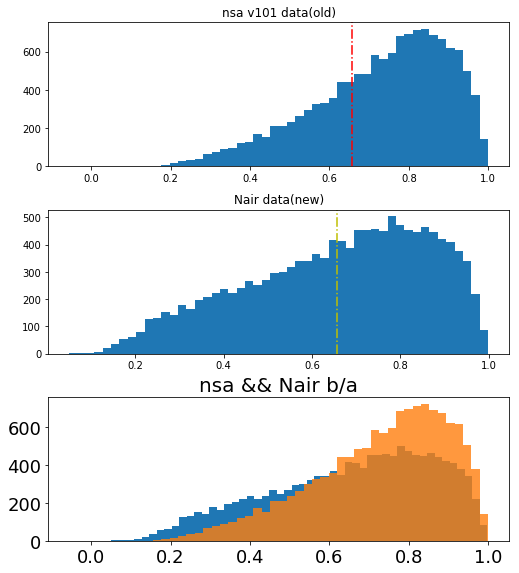

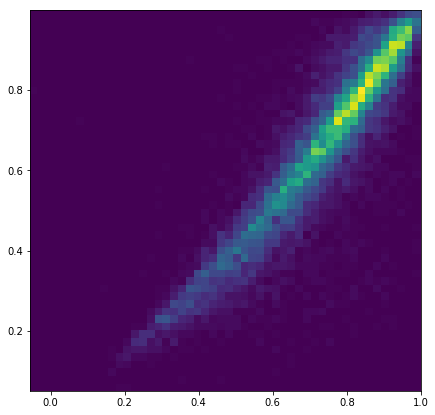

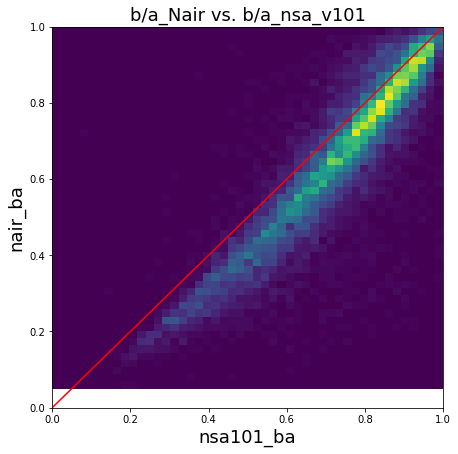

In [211]:
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)


old_ba = nsa_ba[tmp_num_ij[:,0]]    #nsa_v101数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[tmp_num_ij[:,1]]    #Nair catalog数据中的b/a
#tmp_new_ba = new_ba[np.where(new_ba<=1)]    # 去除nair catalog数据中无效数据999999



sdss_ba = old_ba[np.where(new_ba<=1)]
nair_ba = new_ba[np.where(new_ba<=1)]
print("sdss_ba = ",sdss_ba)
print("nair_ba = ",nair_ba)
print("sdss_ba数组形状为 ",sdss_ba.shape)
print("nair_ba数组形状为 ",nair_ba.shape)

'''
画图
'''
plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

# 检查数组
print("old_ba = ",old_ba)
print("new_ba = ",new_ba)
print("old_ba数组形状为 ",old_ba.shape)
print("new_ba数组形状为 ",new_ba.shape)


delta_bins = 50    # 设置分组大小

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)

plt.subplot(3,1,1)
plt.hist(sdss_ba,bins=delta_bins);
plt.axvline(np.mean(nair_ba),color='r',linestyle='-.');
plt.title('nsa v101 data(old)');

plt.subplot(3,1,2)
plt.hist(nair_ba,bins=delta_bins);
plt.axvline(np.mean(nair_ba),color='y',linestyle='-.');
plt.title('Nair data(new)');

plt.subplot(3,1,3)
plt.hist(nair_ba,bins=delta_bins);
plt.hist(old_ba,bins=delta_bins,alpha=0.8);


plt.title('nsa && Nair b/a',fontsize=20);
plt.tick_params(labelsize=18)


# 使用hist2D画出 b/a_sdss vs. b/a_Nair
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
#print(xbins)
#print(ybins)
#xbins[1]

plt.figure(figsize=(7,7))
xx=np.linspace(0,1,10)
plt.plot(xx,xx,color = 'r')
plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
plt.xlabel("nsa101_ba",fontsize = 18)
plt.ylabel("nair_ba",fontsize = 18)
plt.title("b/a_Nair vs. b/a_nsa_v101",fontsize = 18)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [236]:
# 临时检查数组是否有重复以及无效数据
print(last_same_gal[:,0].shape)
print(np.unique(last_same_gal[np.where(last_same_gal[:,0]!=-999),0]).shape)
print(np.unique(last_same_gal[np.where(last_same_gal[:,0]!=-999),1]).shape)
print(np.min(last_same_gal[np.where(last_same_gal[:,0]!=-999),0]))
print(np.min(last_same_gal[np.where(last_same_gal[:,1]!=-999),1]))

(641409,)
(4562,)
(4562,)
22286.0
0.0


In [216]:
# Hsiang-Chih Hwang1, Jorge K. Barrera-Ballesteros1 2018
# Manga中的金属丰度反常区域是由于吸积所造成的吗？
# 读取NASA-Sloan catalog v1 0 1中的 ra dec b/a数据
# catalog简介：https://www.sdss.org/dr13/manga/manga-target-selection/nsa/
# Catalog参数详细说明：https://data.sdss.org/datamodel/files/ATLAS_DATA/ATLAS_MAJOR_VERSION/nsa.html#hdu0
# 下载地址：https://data.sdss.org/sas/dr13/sdss/atlas/v1/nsa_v1_0_1.fits
# 本地文件路径 /root/cosmos/data/nsa_v1_0_1.fits
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from pylab import *
import copy
# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic = nsa101[1].data

# get data and remove the read-only property
nsa_ra = copy.copy(basic['RA'])
nsa_dec = copy.copy(basic['DEC'])
nsa_ra2 = copy.copy(basic['PLUG_RA'])
nsa_dec2 = copy.copy(basic['PLUG_DEC'])
nsa_ba = copy.copy(basic['PETRO_BA90'])

###################################################################
###### 寻找ASA-Sloan catalog v1 0 1与manga中一样的星系#############
###################################################################


# 获取ra和dec信息
old_ra = nsa_ra
old_dec = nsa_dec

# read the new data of ra and dec
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic = copy.copy(vac0[1].data)    # 去除只读属性
# 获取ra和dec信息
new_ra = basic['OBJRA']
new_dec = basic['OBJDEC']
# 根据编号取出 b_over_a数据
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
new_ba = np.abs(b_over_a)    #Manga数据中的b/a
#old_ba = b_over_a[tmp_num_ij[:,0]]    #Manga数据中的b/a

# 0 = ra, dec = 1, b/a = 2
new_ra_dec = np.zeros([new_ra.size,3])
new_ra_dec[:,0] = new_ra
new_ra_dec[:,1] = new_dec
new_ra_dec[:,2] = new_ba
#new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

old_same_gal = np.zeros((old_ra.size,1))
new_same_gal = np.zeros((new_ra_dec[:,0].size,1))
last_same_gal =  np.zeros((old_ra.size,2))-999
delta_radec = 0.001
for i in range(0,old_ra.size):
#for i in range(0,50):
    for j in range(0,new_ra_dec[:,0].size):
        if (old_ra[i]<new_ra_dec[j,0]+delta_radec) and (old_ra[i]>new_ra_dec[j,0]-delta_radec) and (old_dec[i]>new_ra_dec[j,1]-delta_radec) and (old_dec[i]<new_ra_dec[j,1]+delta_radec):
            old_same_gal[i,0] += 1
            new_same_gal[j,0] += 1
            last_same_gal[i,0] = i
            last_same_gal[i,1] = j
            #print("find **** one same *******")
            print("Bingo!  ","i = ",i,"j = ",j)
#            print("finish ",i," galaxies, there're ",old_ra.size-i," remaining")





Bingo!   i =  22286 j =  3557
Bingo!   i =  22298 j =  1544
Bingo!   i =  22301 j =  4008
Bingo!   i =  22333 j =  2533
Bingo!   i =  22347 j =  4471
Bingo!   i =  22383 j =  1156
Bingo!   i =  22412 j =  4244
Bingo!   i =  22414 j =  2509
Bingo!   i =  22438 j =  1098
Bingo!   i =  22662 j =  3013
Bingo!   i =  22942 j =  1071
Bingo!   i =  22948 j =  161
Bingo!   i =  23023 j =  1377
Bingo!   i =  23372 j =  3407
Bingo!   i =  23665 j =  2503
Bingo!   i =  23670 j =  1289
Bingo!   i =  23679 j =  2175
Bingo!   i =  23687 j =  1177
Bingo!   i =  23712 j =  1688
Bingo!   i =  23729 j =  4028
Bingo!   i =  23731 j =  1878
Bingo!   i =  23745 j =  1978
Bingo!   i =  23746 j =  16
Bingo!   i =  23784 j =  2087
Bingo!   i =  23786 j =  3560
Bingo!   i =  23811 j =  3478
Bingo!   i =  23818 j =  1970
Bingo!   i =  23866 j =  2044
Bingo!   i =  23877 j =  4532
Bingo!   i =  23890 j =  1112
Bingo!   i =  23891 j =  963
Bingo!   i =  23894 j =  4186
Bingo!   i =  23914 j =  1198
Bingo!   i =  

Bingo!   i =  38368 j =  3118
Bingo!   i =  38373 j =  4106
Bingo!   i =  38374 j =  314
Bingo!   i =  38377 j =  2879
Bingo!   i =  38379 j =  2123
Bingo!   i =  38380 j =  4350
Bingo!   i =  38381 j =  1714
Bingo!   i =  38392 j =  152
Bingo!   i =  38398 j =  3608
Bingo!   i =  38428 j =  1898
Bingo!   i =  38461 j =  1729
Bingo!   i =  38463 j =  3189
Bingo!   i =  38470 j =  1452
Bingo!   i =  38486 j =  1102
Bingo!   i =  38506 j =  1726
Bingo!   i =  38510 j =  3825
Bingo!   i =  38514 j =  3432
Bingo!   i =  38521 j =  2714
Bingo!   i =  38523 j =  1702
Bingo!   i =  38528 j =  1823
Bingo!   i =  38541 j =  594
Bingo!   i =  38543 j =  4448
Bingo!   i =  38550 j =  2438
Bingo!   i =  38553 j =  4027
Bingo!   i =  38567 j =  3423
Bingo!   i =  38612 j =  2186
Bingo!   i =  38617 j =  2593
Bingo!   i =  38618 j =  3983
Bingo!   i =  38663 j =  2574
Bingo!   i =  38713 j =  3871
Bingo!   i =  38764 j =  3659
Bingo!   i =  38770 j =  2978
Bingo!   i =  38775 j =  566
Bingo!   i =  

Bingo!   i =  51968 j =  3912
Bingo!   i =  51970 j =  2043
Bingo!   i =  52037 j =  1338
Bingo!   i =  52169 j =  184
Bingo!   i =  52259 j =  721
Bingo!   i =  52284 j =  695
Bingo!   i =  52357 j =  2090
Bingo!   i =  52367 j =  2487
Bingo!   i =  52368 j =  2328
Bingo!   i =  52462 j =  2983
Bingo!   i =  52494 j =  1191
Bingo!   i =  52554 j =  2710
Bingo!   i =  52578 j =  3857
Bingo!   i =  52588 j =  113
Bingo!   i =  52590 j =  4038
Bingo!   i =  52600 j =  2651
Bingo!   i =  52602 j =  891
Bingo!   i =  52603 j =  1965
Bingo!   i =  52637 j =  240
Bingo!   i =  52660 j =  3598
Bingo!   i =  52677 j =  840
Bingo!   i =  52701 j =  772
Bingo!   i =  52720 j =  1158
Bingo!   i =  52782 j =  217
Bingo!   i =  53753 j =  1639
Bingo!   i =  53870 j =  4155
Bingo!   i =  53880 j =  1551
Bingo!   i =  53883 j =  1093
Bingo!   i =  53885 j =  4478
Bingo!   i =  53897 j =  342
Bingo!   i =  53916 j =  974
Bingo!   i =  53952 j =  87
Bingo!   i =  53954 j =  4402
Bingo!   i =  53968 j =

Bingo!   i =  113322 j =  3091
Bingo!   i =  113343 j =  3372
Bingo!   i =  113346 j =  3568
Bingo!   i =  113368 j =  496
Bingo!   i =  113375 j =  798
Bingo!   i =  113375 j =  1060
Bingo!   i =  113379 j =  151
Bingo!   i =  113379 j =  3699
Bingo!   i =  113403 j =  1238
Bingo!   i =  113404 j =  2244
Bingo!   i =  113405 j =  302
Bingo!   i =  113418 j =  2780
Bingo!   i =  113468 j =  4569
Bingo!   i =  113469 j =  126
Bingo!   i =  113469 j =  2118
Bingo!   i =  113476 j =  252
Bingo!   i =  113518 j =  3023
Bingo!   i =  113520 j =  89
Bingo!   i =  113521 j =  775
Bingo!   i =  113525 j =  295
Bingo!   i =  113525 j =  1121
Bingo!   i =  113525 j =  3883
Bingo!   i =  113539 j =  1579
Bingo!   i =  113540 j =  466
Bingo!   i =  113551 j =  3268
Bingo!   i =  113567 j =  544
Bingo!   i =  113567 j =  3460
Bingo!   i =  113585 j =  1694
Bingo!   i =  113587 j =  3428
Bingo!   i =  113647 j =  3333
Bingo!   i =  113651 j =  296
Bingo!   i =  113654 j =  3366
Bingo!   i =  113663 

Bingo!   i =  138140 j =  3986
Bingo!   i =  138157 j =  2198
Bingo!   i =  138164 j =  1050
Bingo!   i =  145741 j =  2317
Bingo!   i =  145771 j =  3332
Bingo!   i =  145783 j =  497
Bingo!   i =  145828 j =  1638
Bingo!   i =  145842 j =  3735
Bingo!   i =  145856 j =  1749
Bingo!   i =  145884 j =  4507
Bingo!   i =  145894 j =  1901
Bingo!   i =  145913 j =  3225
Bingo!   i =  145920 j =  1846
Bingo!   i =  145922 j =  3818
Bingo!   i =  145963 j =  1255
Bingo!   i =  145995 j =  3406
Bingo!   i =  146001 j =  1335
Bingo!   i =  146028 j =  1708
Bingo!   i =  146046 j =  2720
Bingo!   i =  146067 j =  3488
Bingo!   i =  146106 j =  202
Bingo!   i =  146247 j =  3624
Bingo!   i =  146271 j =  3729
Bingo!   i =  146292 j =  1200
Bingo!   i =  146337 j =  2670
Bingo!   i =  146344 j =  4613
Bingo!   i =  146360 j =  3959
Bingo!   i =  146380 j =  449
Bingo!   i =  146408 j =  872
Bingo!   i =  146420 j =  2649
Bingo!   i =  146432 j =  3180
Bingo!   i =  146440 j =  3832
Bingo!   i =

Bingo!   i =  167113 j =  535
Bingo!   i =  167141 j =  3291
Bingo!   i =  167148 j =  4285
Bingo!   i =  167166 j =  1189
Bingo!   i =  167167 j =  892
Bingo!   i =  167169 j =  703
Bingo!   i =  167242 j =  4390
Bingo!   i =  167334 j =  2105
Bingo!   i =  167336 j =  319
Bingo!   i =  167337 j =  3059
Bingo!   i =  167342 j =  1463
Bingo!   i =  167356 j =  1545
Bingo!   i =  167356 j =  4063
Bingo!   i =  167360 j =  3661
Bingo!   i =  167380 j =  1724
Bingo!   i =  167392 j =  1285
Bingo!   i =  167403 j =  2786
Bingo!   i =  167423 j =  1308
Bingo!   i =  167488 j =  2389
Bingo!   i =  167519 j =  2008
Bingo!   i =  167555 j =  2067
Bingo!   i =  167564 j =  1026
Bingo!   i =  167582 j =  2635
Bingo!   i =  167610 j =  4498
Bingo!   i =  167627 j =  1229
Bingo!   i =  167678 j =  3558
Bingo!   i =  167688 j =  2954
Bingo!   i =  172936 j =  3481
Bingo!   i =  172948 j =  2568
Bingo!   i =  172962 j =  3545
Bingo!   i =  172986 j =  2965
Bingo!   i =  172987 j =  4665
Bingo!   i =

Bingo!   i =  188803 j =  4214
Bingo!   i =  188844 j =  3131
Bingo!   i =  188888 j =  4322
Bingo!   i =  189145 j =  4359
Bingo!   i =  189197 j =  4122
Bingo!   i =  190560 j =  1739
Bingo!   i =  190574 j =  1138
Bingo!   i =  196580 j =  258
Bingo!   i =  196597 j =  3215
Bingo!   i =  196737 j =  1398
Bingo!   i =  196753 j =  3711
Bingo!   i =  196861 j =  2757
Bingo!   i =  196863 j =  2298
Bingo!   i =  196929 j =  266
Bingo!   i =  197013 j =  2721
Bingo!   i =  197017 j =  2456
Bingo!   i =  197044 j =  3583
Bingo!   i =  197045 j =  416
Bingo!   i =  197063 j =  2488
Bingo!   i =  197092 j =  200
Bingo!   i =  197121 j =  2844
Bingo!   i =  197166 j =  1252
Bingo!   i =  197186 j =  4526
Bingo!   i =  197218 j =  4510
Bingo!   i =  197230 j =  1328
Bingo!   i =  197264 j =  4302
Bingo!   i =  197270 j =  1019
Bingo!   i =  197278 j =  1232
Bingo!   i =  197280 j =  2549
Bingo!   i =  197287 j =  4277
Bingo!   i =  197292 j =  3401
Bingo!   i =  197307 j =  3726
Bingo!   i =

Bingo!   i =  211017 j =  1033
Bingo!   i =  211017 j =  2842
Bingo!   i =  211019 j =  3028
Bingo!   i =  211023 j =  3227
Bingo!   i =  211027 j =  2752
Bingo!   i =  211028 j =  2612
Bingo!   i =  211044 j =  3790
Bingo!   i =  211049 j =  1374
Bingo!   i =  211051 j =  2973
Bingo!   i =  211055 j =  1110
Bingo!   i =  211059 j =  3582
Bingo!   i =  211063 j =  2140
Bingo!   i =  211067 j =  3725
Bingo!   i =  211073 j =  2250
Bingo!   i =  211074 j =  2501
Bingo!   i =  211077 j =  508
Bingo!   i =  211079 j =  864
Bingo!   i =  211082 j =  4264
Bingo!   i =  211084 j =  795
Bingo!   i =  211098 j =  1756
Bingo!   i =  211100 j =  1003
Bingo!   i =  211103 j =  4033
Bingo!   i =  211105 j =  843
Bingo!   i =  211227 j =  287
Bingo!   i =  211239 j =  4477
Bingo!   i =  211241 j =  4421
Bingo!   i =  211257 j =  3559
Bingo!   i =  211264 j =  1856
Bingo!   i =  211266 j =  1883
Bingo!   i =  211273 j =  4097
Bingo!   i =  211311 j =  4056
Bingo!   i =  212201 j =  4518
Bingo!   i = 

Bingo!   i =  246064 j =  3116
Bingo!   i =  246108 j =  3742
Bingo!   i =  246175 j =  2731
Bingo!   i =  246177 j =  3440
Bingo!   i =  246191 j =  4495
Bingo!   i =  246196 j =  2905
Bingo!   i =  246203 j =  3124
Bingo!   i =  246212 j =  157
Bingo!   i =  246216 j =  2902
Bingo!   i =  246219 j =  2788
Bingo!   i =  246270 j =  2004
Bingo!   i =  246298 j =  3365
Bingo!   i =  246331 j =  3448
Bingo!   i =  246362 j =  3176
Bingo!   i =  246383 j =  940
Bingo!   i =  246437 j =  589
Bingo!   i =  246442 j =  213
Bingo!   i =  246470 j =  2253
Bingo!   i =  246484 j =  1087
Bingo!   i =  246517 j =  3148
Bingo!   i =  246525 j =  2590
Bingo!   i =  246535 j =  1386
Bingo!   i =  246542 j =  2878
Bingo!   i =  246543 j =  1745
Bingo!   i =  246549 j =  1952
Bingo!   i =  246565 j =  3186
Bingo!   i =  246570 j =  2801
Bingo!   i =  246599 j =  719
Bingo!   i =  246614 j =  592
Bingo!   i =  246618 j =  529
Bingo!   i =  246633 j =  2585
Bingo!   i =  246635 j =  2665
Bingo!   i =  2

Bingo!   i =  258726 j =  1011
Bingo!   i =  258737 j =  3310
Bingo!   i =  258746 j =  4283
Bingo!   i =  258747 j =  408
Bingo!   i =  258748 j =  2741
Bingo!   i =  258750 j =  3528
Bingo!   i =  258752 j =  2563
Bingo!   i =  258758 j =  1987
Bingo!   i =  258760 j =  650
Bingo!   i =  258774 j =  4089
Bingo!   i =  258777 j =  2459
Bingo!   i =  258778 j =  1130
Bingo!   i =  258782 j =  1368
Bingo!   i =  258795 j =  3053
Bingo!   i =  258804 j =  1817
Bingo!   i =  258820 j =  4535
Bingo!   i =  258823 j =  2715
Bingo!   i =  258876 j =  560
Bingo!   i =  258879 j =  3956
Bingo!   i =  258947 j =  2029
Bingo!   i =  258988 j =  3601
Bingo!   i =  259001 j =  2701
Bingo!   i =  259050 j =  343
Bingo!   i =  259058 j =  1294
Bingo!   i =  259068 j =  418
Bingo!   i =  259079 j =  2181
Bingo!   i =  259091 j =  681
Bingo!   i =  259104 j =  618
Bingo!   i =  259108 j =  1936
Bingo!   i =  259117 j =  4645
Bingo!   i =  259136 j =  4112
Bingo!   i =  259142 j =  219
Bingo!   i =  25

Bingo!   i =  279120 j =  1787
Bingo!   i =  279123 j =  517
Bingo!   i =  279147 j =  1990
Bingo!   i =  279188 j =  2293
Bingo!   i =  279252 j =  420
Bingo!   i =  279279 j =  3635
Bingo!   i =  279314 j =  2164
Bingo!   i =  279320 j =  1841
Bingo!   i =  279329 j =  2081
Bingo!   i =  279381 j =  2061
Bingo!   i =  279410 j =  2960
Bingo!   i =  279412 j =  1045
Bingo!   i =  279532 j =  1123
Bingo!   i =  279544 j =  1031
Bingo!   i =  279554 j =  3202
Bingo!   i =  279617 j =  2864
Bingo!   i =  279666 j =  1668
Bingo!   i =  279675 j =  3834
Bingo!   i =  279676 j =  1010
Bingo!   i =  279690 j =  70
Bingo!   i =  280053 j =  3567
Bingo!   i =  280104 j =  1166
Bingo!   i =  280965 j =  4333
Bingo!   i =  281037 j =  3997
Bingo!   i =  281050 j =  392
Bingo!   i =  281234 j =  4355
Bingo!   i =  281439 j =  3819
Bingo!   i =  282020 j =  2650
Bingo!   i =  282021 j =  2260
Bingo!   i =  282035 j =  1758
Bingo!   i =  282043 j =  1253
Bingo!   i =  282106 j =  2001
Bingo!   i = 

Bingo!   i =  318364 j =  1813
Bingo!   i =  318401 j =  970
Bingo!   i =  318434 j =  3400
Bingo!   i =  318435 j =  1109
Bingo!   i =  318463 j =  1244
Bingo!   i =  318499 j =  3019
Bingo!   i =  318513 j =  2858
Bingo!   i =  318518 j =  1008
Bingo!   i =  318519 j =  536
Bingo!   i =  318601 j =  2491
Bingo!   i =  318621 j =  2700
Bingo!   i =  318725 j =  3362
Bingo!   i =  318728 j =  988
Bingo!   i =  320324 j =  2221
Bingo!   i =  320328 j =  1950
Bingo!   i =  320337 j =  1395
Bingo!   i =  320584 j =  1239
Bingo!   i =  320606 j =  316
Bingo!   i =  320642 j =  1906
Bingo!   i =  320655 j =  751
Bingo!   i =  320664 j =  1126
Bingo!   i =  320677 j =  2270
Bingo!   i =  320681 j =  3835
Bingo!   i =  320912 j =  2486
Bingo!   i =  320922 j =  3802
Bingo!   i =  321069 j =  4256
Bingo!   i =  321074 j =  371
Bingo!   i =  321165 j =  4460
Bingo!   i =  321167 j =  611
Bingo!   i =  321170 j =  3133
Bingo!   i =  321215 j =  1273
Bingo!   i =  321221 j =  4058
Bingo!   i =  3

Bingo!   i =  375364 j =  632
Bingo!   i =  375695 j =  515
Bingo!   i =  376285 j =  826
Bingo!   i =  376413 j =  979
Bingo!   i =  376419 j =  2839
Bingo!   i =  376429 j =  2901
Bingo!   i =  376608 j =  4278
Bingo!   i =  376616 j =  325
Bingo!   i =  377125 j =  1848
Bingo!   i =  377167 j =  3931
Bingo!   i =  377176 j =  1624
Bingo!   i =  377221 j =  2793
Bingo!   i =  377321 j =  357
Bingo!   i =  377378 j =  454
Bingo!   i =  377439 j =  572
Bingo!   i =  377471 j =  2361
Bingo!   i =  377508 j =  846
Bingo!   i =  377560 j =  2480
Bingo!   i =  377576 j =  1820
Bingo!   i =  377617 j =  2800
Bingo!   i =  377626 j =  3165
Bingo!   i =  377679 j =  1554
Bingo!   i =  377686 j =  4014
Bingo!   i =  377702 j =  3664
Bingo!   i =  377720 j =  748
Bingo!   i =  377780 j =  3320
Bingo!   i =  377781 j =  3414
Bingo!   i =  377787 j =  3419
Bingo!   i =  377841 j =  2303
Bingo!   i =  377978 j =  3085
Bingo!   i =  377986 j =  764
Bingo!   i =  377990 j =  4023
Bingo!   i =  37803

Bingo!   i =  387106 j =  2196
Bingo!   i =  387140 j =  3100
Bingo!   i =  387155 j =  1969
Bingo!   i =  387161 j =  2676
Bingo!   i =  389238 j =  1168
Bingo!   i =  389244 j =  1276
Bingo!   i =  389285 j =  2107
Bingo!   i =  389479 j =  2862
Bingo!   i =  389499 j =  3249
Bingo!   i =  389503 j =  742
Bingo!   i =  389509 j =  3541
Bingo!   i =  389514 j =  1539
Bingo!   i =  389685 j =  4553
Bingo!   i =  389720 j =  1353
Bingo!   i =  389730 j =  3761
Bingo!   i =  389743 j =  237
Bingo!   i =  390054 j =  2519
Bingo!   i =  390056 j =  390
Bingo!   i =  390066 j =  4443
Bingo!   i =  390086 j =  2357
Bingo!   i =  390130 j =  382
Bingo!   i =  390151 j =  4373
Bingo!   i =  390168 j =  3814
Bingo!   i =  390223 j =  2182
Bingo!   i =  390228 j =  2959
Bingo!   i =  390232 j =  4554
Bingo!   i =  390277 j =  2174
Bingo!   i =  390282 j =  300
Bingo!   i =  390389 j =  1824
Bingo!   i =  390514 j =  2868
Bingo!   i =  390521 j =  3654
Bingo!   i =  390999 j =  4313
Bingo!   i = 

Bingo!   i =  456370 j =  149
Bingo!   i =  456371 j =  285
Bingo!   i =  456376 j =  3031
Bingo!   i =  456380 j =  728
Bingo!   i =  456381 j =  834
Bingo!   i =  456405 j =  3381
Bingo!   i =  456418 j =  2606
Bingo!   i =  456434 j =  1523
Bingo!   i =  456471 j =  4207
Bingo!   i =  456505 j =  4182
Bingo!   i =  456508 j =  3533
Bingo!   i =  456516 j =  1678
Bingo!   i =  456518 j =  1371
Bingo!   i =  456526 j =  3095
Bingo!   i =  456530 j =  1404
Bingo!   i =  456537 j =  1890
Bingo!   i =  456540 j =  3768
Bingo!   i =  456559 j =  648
Bingo!   i =  456567 j =  3206
Bingo!   i =  456583 j =  391
Bingo!   i =  456589 j =  2776
Bingo!   i =  456590 j =  4544
Bingo!   i =  456610 j =  1219
Bingo!   i =  456616 j =  3383
Bingo!   i =  456618 j =  3968
Bingo!   i =  456631 j =  2734
Bingo!   i =  456632 j =  2084
Bingo!   i =  456634 j =  1223
Bingo!   i =  456635 j =  351
Bingo!   i =  456637 j =  282
Bingo!   i =  456639 j =  1379
Bingo!   i =  456656 j =  3650
Bingo!   i =  45

Bingo!   i =  542370 j =  349
Bingo!   i =  542375 j =  3607
Bingo!   i =  542392 j =  2371
Bingo!   i =  542414 j =  3720
Bingo!   i =  545611 j =  1805
Bingo!   i =  545621 j =  4351
Bingo!   i =  545654 j =  870
Bingo!   i =  545674 j =  1326
Bingo!   i =  546807 j =  2923
Bingo!   i =  546813 j =  3373
Bingo!   i =  546816 j =  683
Bingo!   i =  546834 j =  959
Bingo!   i =  546873 j =  402
Bingo!   i =  546894 j =  3925
Bingo!   i =  546912 j =  4006
Bingo!   i =  546965 j =  3551
Bingo!   i =  546966 j =  272
Bingo!   i =  547018 j =  3349
Bingo!   i =  547039 j =  1286
Bingo!   i =  547086 j =  1199
Bingo!   i =  547106 j =  2880
Bingo!   i =  547107 j =  159
Bingo!   i =  547131 j =  3880
Bingo!   i =  547135 j =  556
Bingo!   i =  547159 j =  766
Bingo!   i =  547180 j =  4575
Bingo!   i =  547185 j =  867
Bingo!   i =  547210 j =  370
Bingo!   i =  547290 j =  3302
Bingo!   i =  547295 j =  137
Bingo!   i =  547339 j =  1916
Bingo!   i =  547341 j =  1782
Bingo!   i =  547375

Bingo!   i =  588894 j =  3496
Bingo!   i =  589092 j =  3363
Bingo!   i =  589908 j =  1261
Bingo!   i =  590053 j =  739
Bingo!   i =  590159 j =  3614
Bingo!   i =  591006 j =  4607
Bingo!   i =  591068 j =  3089
Bingo!   i =  591183 j =  543
Bingo!   i =  591248 j =  1310
Bingo!   i =  591255 j =  4145
Bingo!   i =  591260 j =  3922
Bingo!   i =  591279 j =  831
Bingo!   i =  591308 j =  267
Bingo!   i =  591379 j =  715
Bingo!   i =  591474 j =  2912
Bingo!   i =  591580 j =  3259
Bingo!   i =  591588 j =  3788
Bingo!   i =  591917 j =  4248
Bingo!   i =  591961 j =  937
Bingo!   i =  592031 j =  1681
Bingo!   i =  592049 j =  468
Bingo!   i =  592100 j =  395
Bingo!   i =  592128 j =  284
Bingo!   i =  592743 j =  19
Bingo!   i =  592810 j =  2952
Bingo!   i =  592881 j =  1066
Bingo!   i =  592881 j =  3070
Bingo!   i =  592984 j =  3238
Bingo!   i =  593159 j =  2616
Bingo!   i =  593328 j =  1435
Bingo!   i =  593543 j =  3852
Bingo!   i =  593544 j =  1465
Bingo!   i =  59364

Bingo!   i =  633356 j =  2866
Bingo!   i =  633587 j =  352
Bingo!   i =  633591 j =  4102
Bingo!   i =  633608 j =  4272
Bingo!   i =  633729 j =  169
Bingo!   i =  633759 j =  459
Bingo!   i =  633815 j =  1847
Bingo!   i =  633832 j =  842
Bingo!   i =  633839 j =  192
Bingo!   i =  633856 j =  2907
Bingo!   i =  633934 j =  2816
Bingo!   i =  633942 j =  4146
Bingo!   i =  633943 j =  602
Bingo!   i =  633947 j =  4262
Bingo!   i =  633969 j =  1016
Bingo!   i =  633981 j =  3808
Bingo!   i =  633990 j =  2407
Bingo!   i =  633994 j =  4386
Bingo!   i =  634055 j =  3901
Bingo!   i =  634056 j =  667
Bingo!   i =  634089 j =  2811
Bingo!   i =  634093 j =  465
Bingo!   i =  634119 j =  4150
Bingo!   i =  634138 j =  531
Bingo!   i =  634238 j =  3329
Bingo!   i =  634274 j =  1957
Bingo!   i =  634299 j =  778
Bingo!   i =  634328 j =  3952
Bingo!   i =  634350 j =  784
Bingo!   i =  634477 j =  1424
Bingo!   i =  634515 j =  2427
Bingo!   i =  634538 j =  2481
Bingo!   i =  63462

In [237]:
# 暂存46万+个匹配结果
# 第一列：nsa101中的数组位置
# 第二列：manga中的数组位置
# ASA-Sloan catalog v1 0 1 vs manga
np.savetxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat",last_same_gal)
# 读取 ASA-Sloan catalog v1 0 1 vs manga
#np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_nair.dat",last_same_gal)

In [316]:
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")
print(last_same_gal.shape)
print(np.max(last_same_gal))
print(np.min(last_same_gal))
print(last_same_gal[np.where(last_same_gal[:,0]!=-999)].shape)
print(last_same_gal[np.where(last_same_gal[:,0]>-20)].shape)

(641409, 2)
639152.0
-999.0
(4562, 2)
(4562, 2)


In [318]:
print(np.max(new_ba))
print(np.max(new_ba))
print(np.max(new_ba))
print(np.max(new_ba))

999999.0
999999.0


/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='/root/cosmos/data/nsa_v1_0_1.fits' mode='rb' closefd=True>
  """


sdss_ba =  [0.64317125 0.70890856 0.84701777 ... 0.7529868  0.6122307  0.5516911 ]
nair_ba =  [0.85124633 0.68426807 0.79767208 ... 0.75380264 0.70195384 0.56631757]
sdss_ba数组形状为  (4561,)
nair_ba数组形状为  (4561,)
old_ba =  [0.64317125 0.70890856 0.84701777 ... 0.7529868  0.6122307  0.5516911 ]
new_ba =  [0.85124633 0.68426807 0.79767208 ... 0.75380264 0.70195384 0.56631757]
old_ba数组形状为  (4561,)
new_ba数组形状为  (4561,)


(0, 1)

<Figure size 576x432 with 0 Axes>

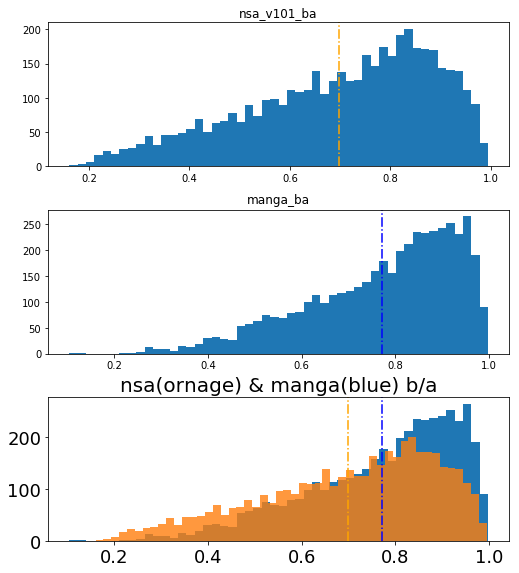

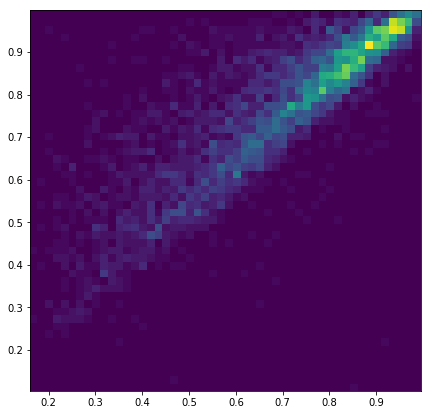

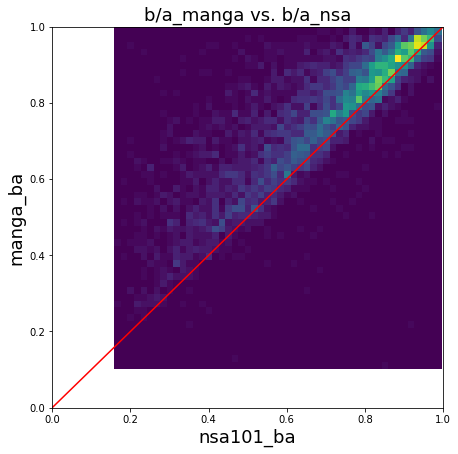

In [319]:
# 读取nsa与manga的匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic = nsa101[1].data
# get data and remove the read-only property
nsa_ba = copy.copy(basic['PETRO_BA90'])

# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)


old_ba = nsa_ba[tmp_num_ij[:,0]]    #nsa_v101数据中的b/a
# tmp_new_ba = new_ra_dec[:,2]
# new_ba = tmp_new_ba[tmp_num_ij[:,1]]    #manga数据中的b/a
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
new_ba = np.abs(b_over_a)    #Manga数据中的b/a
new_ba = new_ba[tmp_num_ij[:,1]]    #匹配到的星系的b/a
#tmp_new_ba = new_ba[np.where(new_ba<=1)]    # 去除nair catalog数据中无效数据999999



# sdss_ba = old_ba[np.where(new_ba<=1)]
# nair_ba = new_ba[np.where(new_ba<=1)]
sdss_ba = old_ba
nair_ba = new_ba
print("sdss_ba = ",sdss_ba)
print("nair_ba = ",nair_ba)
print("sdss_ba数组形状为 ",sdss_ba.shape)
print("nair_ba数组形状为 ",nair_ba.shape)

'''
画图
'''
plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

# 检查数组
print("old_ba = ",old_ba)
print("new_ba = ",new_ba)
print("old_ba数组形状为 ",old_ba.shape)
print("new_ba数组形状为 ",new_ba.shape)


delta_bins = 50    # 设置分组大小

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)

plt.subplot(3,1,1)
plt.hist(sdss_ba,bins=delta_bins);
plt.axvline(np.mean(sdss_ba),color='orange',linestyle='-.');
plt.title('nsa_v101_ba');

plt.subplot(3,1,2)
plt.hist(nair_ba,bins=delta_bins);
plt.axvline(np.mean(nair_ba),color='blue',linestyle='-.');
plt.title('manga_ba');

plt.subplot(3,1,3)
plt.hist(nair_ba,bins=delta_bins);
plt.hist(old_ba,bins=delta_bins,alpha=0.8);
plt.axvline(np.mean(sdss_ba),color='orange',linestyle='-.');
plt.axvline(np.mean(nair_ba),color='blue',linestyle='-.');

plt.title('nsa(ornage) & manga(blue) b/a',fontsize=20);
plt.tick_params(labelsize=18)


# 使用hist2D画出 b/a_sdss vs. b/a_Nair
plt.figure(figsize=(7,7))
hist, xbins, ybins, cax = plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
#print(xbins)
#print(ybins)
#xbins[1]

plt.figure(figsize=(7,7))
xx=np.linspace(0,1,10)
plt.plot(xx,xx,color = 'r')
plt.hist2d(sdss_ba,nair_ba,bins=(50,50));
plt.xlabel("nsa101_ba",fontsize = 18)
plt.ylabel("manga_ba",fontsize = 18)
plt.title("b/a_manga vs. b/a_nsa",fontsize = 18)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [320]:
sdss_ba = old_ba
nair_ba = new_ba
print("sdss_ba = ",sdss_ba)
print("nair_ba = ",nair_ba)
print("sdss_ba数组形状为 ",sdss_ba.shape)
print("nair_ba数组形状为 ",nair_ba.shape)

sdss_ba =  [0.64317125 0.70890856 0.84701777 ... 0.7529868  0.6122307  0.5516911 ]
nair_ba =  [0.85124633 0.68426807 0.79767208 ... 0.75380264 0.70195384 0.56631757]
sdss_ba数组形状为  (4561,)
nair_ba数组形状为  (4561,)


In [217]:
np.mean(old_ba)
np.max(old_ba)
np.min(old_ba)
nsa_ba.shape
np.where(nsa_ba==np.nan)
np.argwhere(np.isnan(nsa_ba)).shape
np.where(np.isnan(nsa_ba)).shape

AttributeError: 'tuple' object has no attribute 'shape'

In [225]:
a =1
b = 2

# 2


dfdfdfdsdfdf is 
# 3
# 6
# 5

# 4efefef j id
# dfdff
# 7
# 8
# 9

NameError: name 'fddfdf' is not defined

"\n# 显示图片\n#9888-12703\nplate = 9888\nifu = 12703\npath_image_data = '/root/cosmos/data/images'\nimage_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))\nname_pla_ifu = ''.join([str(plate),'-',str(ifu)])\n\ntemp_image = mpimg.imread(image_path)\n\n\nfig, ax = plt.subplots(figsize=(7, 7))\nplt.title(name_pla_ifu,fontsize=18)\nplt.imshow(temp_image) # 显示图片\nplt.axis('off') # 不显示坐标轴\nplt.show()\n"

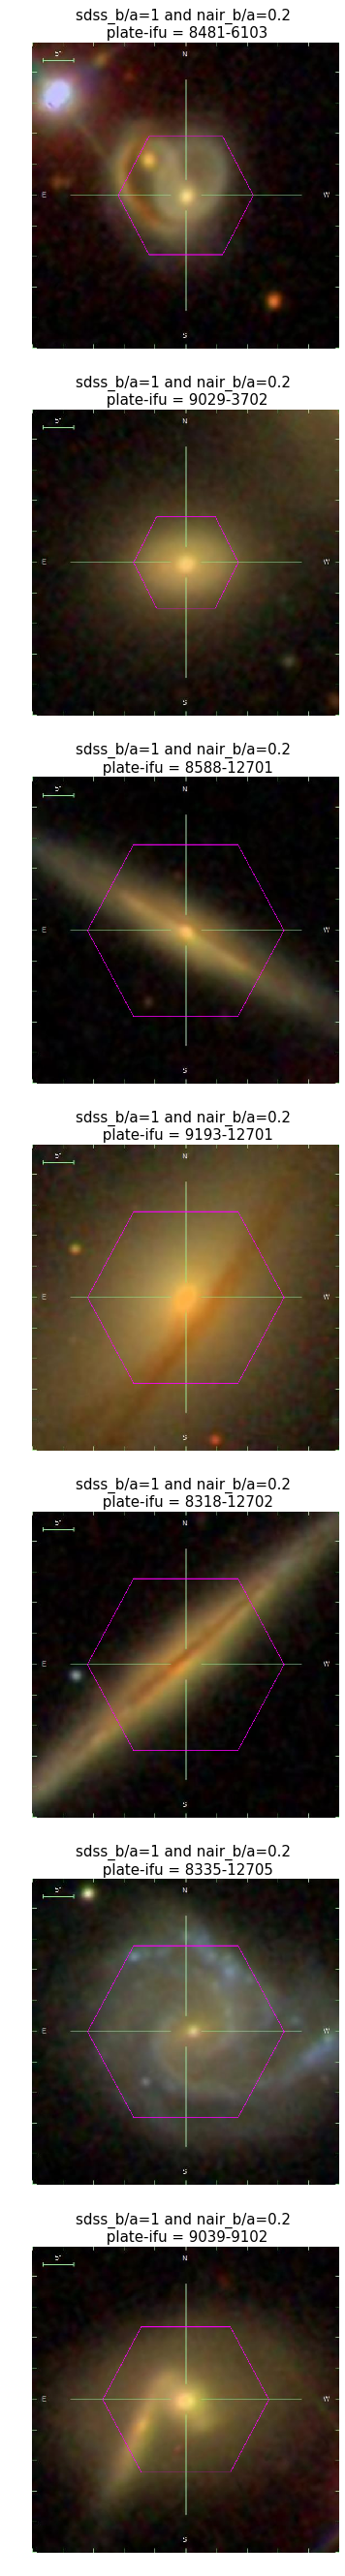

In [123]:
# 找出0.2~1 的星系，找到ra dec，再找到plate-ifu，再读取图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from os.path import join

# 寻找nair_ba and sdss_ba中0.2~1的星系编号
temp_plate = basic['plate']    # 读取plate
temp_ifu = basic['ifudsgn']    # 读取ifu
old_ra = basic['OBJRA']
old_dec = basic['OBJDEC']

sel_image = np.zeros((b_over_a.size,6))
sel_image[:,0] = temp_plate    # 第1列存储plate，源于Manga
sel_image[:,1] = temp_ifu    # 第2列存储ifu，源于Manga
sel_image[:,2] = old_ra    # 第3列存储ra，源于Manga
sel_image[:,3] = old_dec    # 第4列存储dec，源于Manga
sel_image[:,4] = b_over_a    # 第5列存储b/a，源于Manga
# 第6列存储b/a，源于nair catalog
#############################################################

old_ba = b_over_a[tmp_num_ij[:,0]]    #Manga数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[tmp_num_ij[:,1]]    #Nair catalog数据中的b/a
num_sel_np = tmp_num_ij[np.where(new_ba<=1)]    # 最终的数组编号位置

sel_image2 = sel_image[num_sel_np[:,0]]
sel_image2[:,5] = tmp_new_ba[num_sel_np[:,1]]


# 寻找数组编号对应的星系的ra dec
tmp_delta =0.1
signal_stop1 = 0
signal_stop2 = 0
rst_02_1 = np.zeros([sel_image2[:,4].size,2])
rst_1_02 = np.zeros([sel_image2[:,4].size,2])
for i in range(0,sel_image2[:,4].size):
    if  (signal_stop1<20) and (sel_image2[i,4]<0.2+tmp_delta) and (sel_image2[i,4]>0.2-tmp_delta) and (sel_image2[i,5]<1+tmp_delta) and (sel_image2[i,5]>1-tmp_delta):     
        rst_02_1[signal_stop1,0] = sel_image2[i,0]    # 存储符合条件的星系的plate
        rst_02_1[signal_stop1,1] = sel_image2[i,1]    # 存储符合条件的星系的ifu  
        signal_stop1+=1
    if (signal_stop2<20) and (sel_image2[i,5]<0.2+tmp_delta) and (sel_image2[i,5]>0.2-tmp_delta) and (sel_image2[i,4]<1+tmp_delta) and (sel_image2[i,4]>1-tmp_delta):
        rst_1_02[signal_stop2,0] = sel_image2[i,0]    # 存储符合条件的星系的plate
        rst_1_02[signal_stop2,1] = sel_image2[i,1]    # 存储符合条件的星系的ifu
        signal_stop2+=1
# convert to int format
rst_02_1 = rst_02_1.astype(np.int64)
rst_1_02 = rst_1_02.astype(np.int64)
rst_02_1 = rst_02_1[np.where(rst_02_1[:,0]!=0)]
rst_1_02 = rst_1_02[np.where(rst_1_02[:,0]!=0)]
path_image_data = '/root/cosmos/data/images'
#plt.figure(figsize=(20,80))
plt.figure(figsize=(10,30))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

'''
for i in range(0,rst_02_1[:,0].size):
    plate = rst_02_1[i,0]
    ifu = rst_02_1[i,1]   
    image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
    name_pla_ifu = ''.join([str(plate),'-',str(ifu)])
    temp_image = mpimg.imread(image_path)
    
    plt.subplot(rst_02_1[:,0].size,2,2*i+1) 
    #plt.title("The slope of the line is %s and the max of y is %s"%(k, max(y)))
    plt.title("sdss_b/a=0.2 and nair_b/a=1 \n plate-ifu = %s"%(name_pla_ifu),fontsize=15)
    plt.imshow(temp_image) # 显示图片
    plt.axis('off') # 不显示坐标轴
'''

for i in range(0,rst_1_02[:,0].size):    
    plate = rst_1_02[i,0]
    ifu = rst_1_02[i,1]   
    image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
    name_pla_ifu = ''.join([str(plate),'-',str(ifu)])
    temp_image = mpimg.imread(image_path)
    
    plt.subplot(rst_1_02[:,0].size,1,i+1)   
    #plt.title("星系：",name_pla_ifu,"sdss_b/a~0.2 and nair_b/a~1",fontsize=18)
    plt.title("sdss_b/a=1 and nair_b/a=0.2 \n plate-ifu = %s"%(name_pla_ifu),fontsize=15)
    plt.imshow(temp_image) # 显示图片
    plt.axis('off') # 不显示坐标轴
  
#
#根据ra dec 寻找plate-ifu
#rst_02_1 = rst_02_1[np.where(rst_02_1!=0)]
#rst_1_02 = rst_1_02[np.where(rst_1_02!=0)]


'''
# 显示图片
#9888-12703
plate = 9888
ifu = 12703
path_image_data = '/root/cosmos/data/images'
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])

temp_image = mpimg.imread(image_path)


fig, ax = plt.subplots(figsize=(7, 7))
plt.title(name_pla_ifu,fontsize=18)
plt.imshow(temp_image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
'''


In [126]:
# 检查9043-3701星系是否正常
lala_plate = 8318
lala_ifu = 12702

nair_cata = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')
# 寻找此星系所对应的sel_image2中的数组位置
num_check = np.where((sel_image2[:,0]==lala_plate) & (sel_image2[:,1]==lala_ifu))
print("i= ",num_sel_np[num_check,0][0][0],"j= ",num_sel_np[num_check,1][0][0])

print(sel_image2[num_check,2:5][0][0])
print("nair_ra=",nair_cata[num_sel_np[num_check,1][0][0],0]," nair_dec=",nair_cata[num_sel_np[num_check,1][0][0],1]," nair_b/a=",nair_cata[num_sel_np[num_check,1][0][0],2])





i=  4099 j=  12016
[196.44403076  46.46185684   0.94185154]
nair_ra= 196.445  nair_dec= 46.462  nair_b/a= 0.171


In [68]:
nair_cata[num_sel_np[num_check,1][0][0]]

array([212.117,  13.599,   0.22 ])

In [82]:
num_sel_np.shape

(1194, 2)

In [45]:
print(sel_image2.shape)
print(tmp_num_ij.shape)


(1194, 6)
(1199, 2)


In [34]:
np.savetxt("/root/manga_b_over_a.dat",b_over_a)

In [1]:

i = 1    
plate = rst_1_02[i,0]
ifu = rst_1_02[i,1]   
image_path = join(path_image_data, '{}.png'.format(''.join([str(plate),'-',str(ifu)])))
name_pla_ifu = ''.join([str(plate),'-',str(ifu)])
temp_image = mpimg.imread(image_path)

plt.figure(figsize=(20,80))
plt.subplot(rst_02_1[:,0].size,2,2*i+2)
#fig2, ax = plt.subplots(figsize=(5, 5))
plt.imshow(temp_image) # 显示图片

plt.title(name_pla_ifu,fontsize=18)

plt.axis('off') # 不显示坐标轴
#plt.show()

NameError: name 'rst_1_02' is not defined

In [161]:
rst_1_02 = rst_1_02.astype(np.int64)
rst_1_02[np.where(rst_1_02[:,0]!=0)]
rst_1_02.shape

(1194, 2)

In [129]:
rst_1_02 = np.array([:,2])
rst_1_02[0,0] = 1
rst_1_02[1,1] = 2
rst_1_02[2,2] = 3
rst_1_02[3,0] = 4
print(rst_1_02)

SyntaxError: invalid syntax (<ipython-input-129-ff906322fbb5>, line 1)

In [116]:
b_over_a.shape

(4675,)

In [115]:
print(b_over_a[np.where((b_over_a<=1)&(b_over_a>0))].shape)
print(np.unique(b_over_a[np.where((b_over_a<=1)&(b_over_a>0))]).shape)

(4675,)
(4598,)


In [124]:
 rst_0.2_1 = 88

SyntaxError: invalid syntax (<ipython-input-124-9068989932ed>, line 1)

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <matplotlib.collections.QuadMesh at 0x7f21724f54a8>)

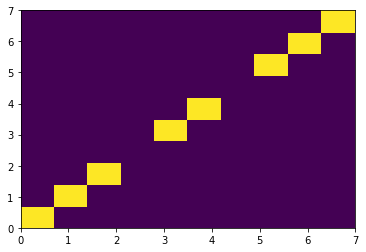

In [82]:
tmpa = np.array([0,1,2,3,4,5,6,7])
tmpb = np.array([0,1,2,3,4,5,6,7])
plt.hist2d(tmpa,tmpb)

In [7]:
'''
去除重复的编号
数组编号为标准
'''
# 临时变量，取出ra dec一致的星系编号
# 去除重复筛选出的编号
old_num_same_gal = np.unique(np.where(old_same_gal[:,0]!=0))
new_num_same_gal = np.unique(np.where(new_same_gal[:,0]!=0))
a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(last_same_gal[num_last_same_gal,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号

#print(old_num_same_gal)
#print(new_num_same_gal)

# 根据编号取出 b_over_a数据
q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)
old_ba = b_over_a[old_num_same_gal]    #Manga数据中的b/a
tmp_new_ba = new_ra_dec[:,2]
new_ba = tmp_new_ba[new_num_same_gal]    #Nair catalog数据中的b/a


In [6]:
tmp = last_same_gal.astype(np.int32)
tmp[np.where(tmp>=0)].shape

(2794,)

In [24]:
np.shape(np.where(last_same_gal>0))


(2, 2794)

In [23]:
np.shape(np.where(old_same_gal[:,0]!=0))

(1, 1397)

In [15]:
new_ba[np.where(new_ba>1)]

array([999999., 999999., 999999., 999999., 999999., 999999., 999999.,
       999999.])

In [20]:
print(old_ba.shape)
print(tmp_new_ba.shape)


(1397,)
(1433,)


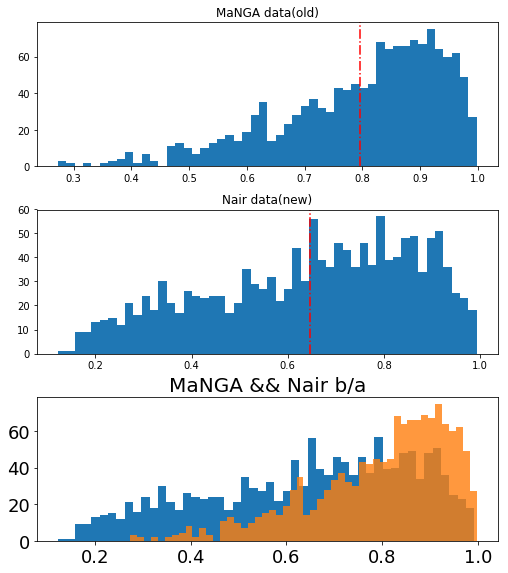

In [19]:
# 去除nair catalog数据中无效数据999999
tmp_new_ba = new_ba[np.where(new_ba<=1)]
delta_bins = 50

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.3,wspace=0.2)

plt.subplot(3,1,1)
plt.hist(old_ba,bins=delta_bins);
plt.axvline(np.mean(old_ba),color='r',linestyle='-.');
plt.title('MaNGA data(old)');

plt.subplot(3,1,2)
plt.hist(tmp_new_ba,bins=delta_bins);
plt.axvline(np.mean(tmp_new_ba),color='r',linestyle='-.');
plt.title('Nair data(new)');

plt.subplot(3,1,3)
plt.hist(tmp_new_ba,bins=delta_bins);
plt.hist(old_ba,bins=delta_bins,alpha=0.8);


plt.title('MaNGA && Nair b/a',fontsize=20);
plt.tick_params(labelsize=18)

In [20]:
lala = np.zeros((3,1))
lala[1,0]=1
lala[np.where(lala==0)]

array([0., 0.])

In [ ]:
# 粗略筛选为2组
import matplotlib.pyplot as plt
from pylab import *

q_u = np.loadtxt('manga_Q_U_4675.txt')
b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1
b_over_a = np.abs(b_over_a)

plt.figure(figsize=(8,6))
subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=0.8,hspace=0.2,wspace=0.2)

temp_old_ba = b_over_a[np.where(old_same_gal[:,0]!=0),0]
temp_new_ba = new_ra_dec[np.where(new_same_gal[:,0]!=0),2]
print(temp_old.shape)
print(temp_new.shape)

plt.subplot(2,1,1)
plt.hist(temp_old,bins=300);
#plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');
plt.title('MaNGA data(old)');

plt.subplot(2,1,2)
plt.hist(temp_new,bins=300);
#plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');
plt.title('Nair data(new)');




(1, 1397)
(1, 1441)


In [34]:
np.where(old_same_gal!=0)

(array([   1,    8,   11, ..., 4663, 4667, 4667]),
 array([0, 0, 0, ..., 0, 0, 1]))

In [9]:
# 二次筛选重复星系
delta2_radec = 0.0005
for i in range(0,old_ra.size):
    if (old_same_gal[i,0]!=0) and (old_same_gal[i,0]!=1):
        for j in range(0,new_ra_dec[:,0].size):
            if ((old_ra[i]<new_ra_dec[j,0]+delta2_radec) and (old_ra[i]>new_ra_dec[j,0]-delta2_radec) and (old_dec[i]>new_ra_dec[j,1]-delta2_radec) and (old_dec[i]>new_ra_dec[j,1]-delta2_radec)):
                old_same_gal[i,1] += 1
                new_same_gal[j,1] += 1
                print("find **** one same *******")
                print("i = ",i,"j = ",j)
print(np.where((old_same_gal[:,1] != 0)&(old_same_gal[:,1] != 1)))            
print(np.where((new_same_gal[:,1] != 0)&(new_same_gal[:,1] != 1))) 

find **** one same *******
i =  181 j =  10782
find **** one same *******
i =  238 j =  1764
find **** one same *******
i =  238 j =  11101
find **** one same *******
i =  244 j =  9481
find **** one same *******
i =  338 j =  6908
find **** one same *******
i =  343 j =  12596
find **** one same *******
i =  343 j =  13129
find **** one same *******
i =  368 j =  6875
find **** one same *******
i =  368 j =  7154
find **** one same *******
i =  378 j =  7393
find **** one same *******
i =  485 j =  8544
find **** one same *******
i =  528 j =  9600
find **** one same *******
i =  581 j =  5127
find **** one same *******
i =  581 j =  13542
find **** one same *******
i =  585 j =  8468
find **** one same *******
i =  690 j =  13756
find **** one same *******
i =  696 j =  9548
find **** one same *******
i =  760 j =  2478
find **** one same *******
i =  760 j =  7997
find **** one same *******
i =  769 j =  11431
find **** one same *******
i =  951 j =  7393
find **** one same *******


In [ ]:
# 第三次筛选重复星系


delta3_radec = 0.0002
last_same = np.zeros((old_ra.size,4))
for i in range(0,old_ra.size):
    if (old_same_gal[i,1]!=0) and (old_same_gal[i,1]!=1):
        for j in range(0,new_ra_dec[:,0].size):
            if ((old_ra[i]<new_ra_dec[j,0]+delta3_radec) and (old_ra[i]>new_ra_dec[j,0]-delta3_radec) and (old_dec[i]>new_ra_dec[j,1]-delta3_radec) and (old_dec[i]>new_ra_dec[j,1]-delta3_radec)):
                old_same_gal[i,1] += 1
                new_same_gal[j,1] += 1
                print("find **** one same *******")
                print("i = ",i,"j = ",j)
print(np.where((old_same_gal[:,1] != 0)&(old_same_gal[:,1] != 1)))            
print(np.where((new_same_gal[:,1] != 0)&(new_same_gal[:,1] != 1))) 

In [ ]:
plt.hist(b_over_a,bins=300);
plt.axvline(np.mean(b_over_a),color='r',linestyle='-.');
plt.title('Observed b/a');

In [14]:
temp = np.where(new_same_gal[:,0]!=0)
np.shape(temp)

(1, 1441)

In [15]:
temp = np.where(old_same_gal[:,0]!=0)
np.shape(temp)

(1, 1397)

In [16]:
new_same_gal.shape

(42102, 2)

In [17]:
old_same_gal.shape

(4675, 2)

In [18]:
new_ra_dec.shape

(14034, 3)

In [19]:
temp = np.zeros((new_ra_dec.size,2))
temp.shape

(42102, 2)

In [25]:
temp = np.where(new_same_gal[:,0]==0)
np.shape(temp)

(1, 40661)

In [26]:
old_ra.shape

(4675,)

###################################################
### 【开始】
>### 导出画图数组为csv格式，再使用pandas读取 #######

In [99]:
from os.path import join
import pandas as pd
from marvin.tools import Maps
new_maps = Maps(''.join([str(plate),'-',str(ifu)])) 
# path_data = join( '/root/cosmos/galaxies-mzr/data/')
# mstar = pd.read_csv(join( '/root/cosmos/lalala-test.csv'))
mstar = pd.read_csv( '/root/cosmos/lalala-test.csv')

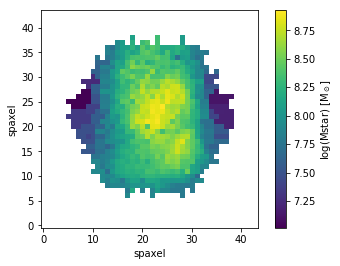

In [100]:
fig, ax = plt.subplots()
p = ax.imshow(mstar, origin='lower')
ax.set_xlabel('spaxel')
ax.set_ylabel('spaxel')
cb = fig.colorbar(p)
cb.set_label('log(Mstar) [M$_\odot$]')

### 【结束】
>### 导出画图数组为csv格式，再使用pandas读取
###################################################

################################################
### 【开始】
>### 尝试读取csv文件，画出 金属丰度-质量密度 图

In [42]:
import pandas as pd
from os.path import join
mstar = pd.read_csv(join( '/root/cosmos/galaxies-mzr/data/manga-8077-6104_mstar.csv'))
spaxel_size = 0.5  # [arcsec]

# or programmatically:
# spaxel_size = float(maps.getCube().header['CD2_2']) * 3600
c = 299792  # speed of light [km/s]
H0 = 70  # [km s^-1 Mpc^-1]
D = c * redshift / H0  # approx. distance to galaxy [Mpc]
scale = 1 / 206265 * D * 1e6  # 1 radian = 206265 arcsec [pc / arcsec]
spaxel_area = (scale * spaxel_size)**2  # [pc^2]
sigma_star = np.log10(10**mstar / spaxel_area)  # [Msun / pc^2]
# 使用N/O的mask
mask = new_mask


[0, 5, 0, 12]

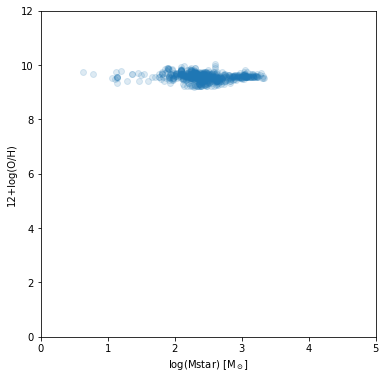

In [46]:
fig, ax = plt.subplots(figsize=(7, 7))
temp_sigma_star = sigma_star.values[0:44,0:44]
ax.scatter(temp_sigma_star[mask == 0], oh.value[mask == 0], alpha=0.15)
ax.set_xlabel('log(Mstar) [M$_\odot$]')
ax.set_ylabel('12+log(O/H)')
ax.axis([0, 5, 0, 12])

### 【结束】
>### 尝试成功！！！
##########################################

###################################
### 【开始】
>### 检查不同星系的mask维度是否相同

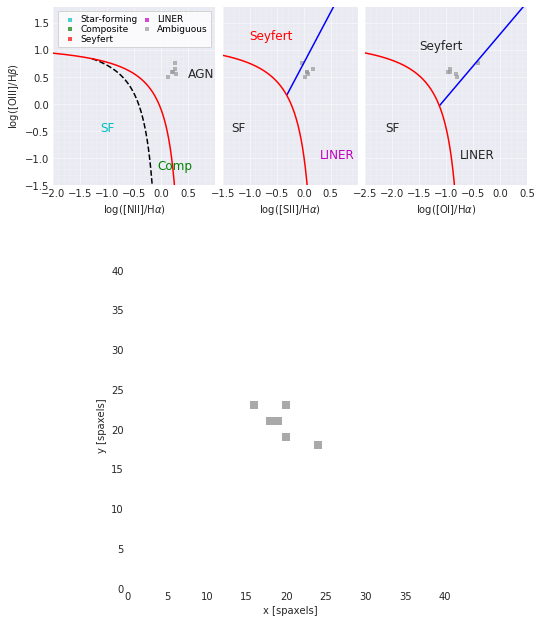


 星系 8077-3701 
 mask维度是 (42, 42)


In [402]:
from marvin.tools import Maps
plate = 8077
ifu = 3701

new_maps = Maps(''.join([str(plate),'-',str(ifu)]))
masks_bpt, __, __ = new_maps.get_bpt()    # 使用bpt图筛选star-forming区域
#RR.pixmask.schema    # 查看mask的种类列表
mask_non_sf = ~masks_bpt['sf']['global']
print('\n','星系',''.join([str(plate),'-',str(ifu)]),'\n','mask维度是',mask_non_sf.shape)

### 【结束】
>### 检查结果：不相同 【与Marvin的网页端的结果检查一致】
>### 策略，以Marvin获取的mask的维度为准，调整其他矩阵
>### 因为必须要用到Marvin的mask
>### 问题：直接调整 0:维度  是否正确？？？    
###################################################################

###############################################
### 【开始】
>### 尝试直接用画图数组画出 金属丰度-质量密度 图
>### 绕开pandas读取csv这一步
>### 矩阵维度以Marvin的mask的维度为准
>>#### new_mask Marvin的mask
>>#### oh 金属丰度
>>#### maps 表面质量密度

In [406]:
image_sz = 30
oh = oh[0:image_sz,0:image_sz]    # 调整oh金属丰度矩阵与标准mask维度一致
# x轴为maps，即 surface mass density
# y轴为oh, 即 metallicity
temp_maps = new_maps[new_mask == 0]
temp_oh = oh.value[new_mask == 0]
maps_min = np.min(temp_maps)    # x轴最小值
maps_max = np.max(temp_maps)    # x轴最大值
oh_min = np.min(temp_oh)    # y轴最小值
oh_max = np.max(temp_oh)    # y轴最大值

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(temp_maps, temp_oh, alpha=0.15)
ax.set_xlabel('log($\Sigma_*$/M$_\odot$kpc$^{-2}$)',fontsize=20)
ax.set_ylabel('12+log(O/H)',fontsize=20)
ax.axis([6, oh_max, oh_min-1, oh_max+1])

MarvinError: invalid type for getitem.
You can submit this error to Marvin GitHub Issues (https://github.com/sdss/marvin/issues/new).
Fill out a subject and some text describing the error that just occurred.
If able, copy and paste the full traceback information into the issue as well.

### 【结束】
>### 成功画出 金属丰度-质量密度 图   
###########################################################    

#############################################
### 【开始】
### 使用Marvin示例中的星系以及金属丰度算法
### 对比是否一致
### 即确认调整维度是否正确

/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: invalid value encountered in true_divide
  return np.log10(np.e) * ivar**-0.5 / value
/root/anaconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True


NameError: name 'maps' is not defined

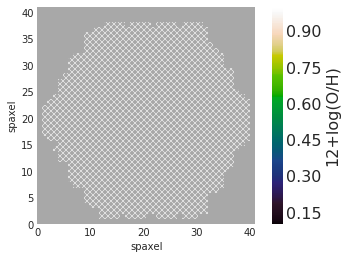

In [404]:
nii = new_maps.emline_gflux_nii_6585
ha = new_maps.emline_gflux_ha_6564
n2 = nii / ha
logn2 = np.log10(n2)
oh =  0.57 * logn2 + 8.90 

mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
ig, ax = oh.plot(mask=new_mask, cblabel='12+log(O/H)')
#oh = [0:image_sz,0:image_sz]    # 调整oh金属丰度矩阵与标准mask维度一致
# x轴为maps，即 surface mass density
# y轴为oh, 即 metallicity
temp_maps = maps[new_mask == 0]
temp_oh = oh.value[new_mask == 0]
maps_min = np.min(temp_maps)    # x轴最小值
maps_max = np.max(temp_maps)    # x轴最大值
oh_min = np.min(temp_oh)    # y轴最小值
oh_max = np.max(temp_oh)    # y轴最大值
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(temp_maps, temp_oh, alpha=0.15)
ax.set_xlabel('log($\Sigma_*$/M$_\odot$kpc$^{-2}$)',fontsize=20)
ax.set_ylabel('12+log(O/H)',fontsize=20)
ax.axis([6, oh_max, oh_min-1, oh_max+1])
#ax.axis([0, 4, 8.0, 8.8])

### 【结束】
>### 结果：和Marvin网站不同
>### 初步推测：Marvin示例教程中所用8077-6104的表面质量密度的数据与我们不同？？？
>### 或者有可能是由于需要*b/a，根据论文，需要计算出deprojected mass density

#######################################################

***
***
##############################################
### 导出plate 和 ifu，保存为文件


In [1]:
# 导出4675个星系的plate和ifu
# 分别保存为manga_plate.dat manga_ifu.dat
# 使用的命令为numpy.savetxt("result.txt", numpy_data);

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性
basic = vac[1].data 

In [2]:
# 获取plate和ifu信息
manga_plate = basic['plate']
manga_ifu = basic['ifudsgn']

# plate转换为int
manga_plate=manga_plate.astype(np.int)
# ifu转换为int【先map，再list，再numpy即可成功转换】
manga_ifu = np.array(list(map(int, manga_ifu)))

# 使用np将数组保存为文件
#np.savetxt("/root/bash_file/manga_plate.dat", manga_plate,fmt="%.18f",delimiter="\n")
#np.savetxt("/root/bash_file/manga_ifu.dat", manga_ifu,fmt="%.18f",delimiter="\n")
np.savetxt("/root/bash_file/manga_plate.dat", manga_plate, fmt="%d")
np.savetxt("/root/bash_file/manga_ifu.dat", manga_ifu, fmt="%d")

### 【结束】
***
***
######################################

***
***
########################################
### 以下为临时测试，无用

In [12]:
np.chararray.astype?

In [51]:
# numpy数组转换格式
manga_plate.dtype
manga_plate=manga_plate.astype(np.int)
manga_plate=np.array(manga_ifu)

In [18]:
np.array(manga_ifu)

array([12701, 12701,  6102, ...,  3702, 12704, 12704])

In [16]:
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

In [17]:
fracDeV.shape

(4675,)